In [69]:
# !pip install torchdiffeq

# Data preprocessing

In [2]:
# Data preprocessing
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

df = pd.read_csv('arabido_example_genes.csv')

print(df)
df.info()  # Check data types
df.describe()  # Statistical summary

print(df.columns)
# print(df.columns.tolist())




  Unnamed: 0  Hpa-NO_1d  Hpa-NO_2d  Hpa-NO_4d
0  AT5G40100  -0.447960  -0.560155  -5.091964
1  AT1G06930   1.778359   0.000000   0.000000
2  AT1G04470   0.000000   1.175150   0.000000
3  AT5G66730   0.055375   0.098435  -0.101757
4  AT2G38472   0.900000   0.500000   0.000000
5  AT2G38474   0.000000   0.500000   0.000000
6  AT2G38470   0.906000   0.906000   0.906000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  7 non-null      object 
 1   Hpa-NO_1d   7 non-null      float64
 2   Hpa-NO_2d   7 non-null      float64
 3   Hpa-NO_4d   7 non-null      float64
dtypes: float64(3), object(1)
memory usage: 356.0+ bytes
Index(['Unnamed: 0', 'Hpa-NO_1d', 'Hpa-NO_2d', 'Hpa-NO_4d'], dtype='object')


# 4. Neural ode +Inverse Pinn

## Parametric ODE Model for Each Gene: dy/dt = α + β * y(t) + γ * t


Original Data:
  Unnamed: 0  Hpa-NO_1d  Hpa-NO_2d  Hpa-NO_4d
0  AT5G40100  -0.447960  -0.560155  -5.091964
1  AT1G06930   1.778359   0.000000   0.000000
2  AT1G04470   0.000000   1.175150   0.000000
3  AT5G66730   0.055375   0.098435  -0.101757
4  AT2G38472   0.900000   0.500000   0.000000
5  AT2G38474   0.000000   0.500000   0.000000
6  AT2G38470   0.906000   0.906000   0.906000
Epoch    0 | Total Loss: 3.1150 | Data Loss: 3.0890 | Physics Loss: 0.2601
Epoch  100 | Total Loss: 0.2029 | Data Loss: 0.1498 | Physics Loss: 0.5309
Epoch  200 | Total Loss: 0.1867 | Data Loss: 0.1343 | Physics Loss: 0.5244
Epoch  300 | Total Loss: 0.1780 | Data Loss: 0.1262 | Physics Loss: 0.5181


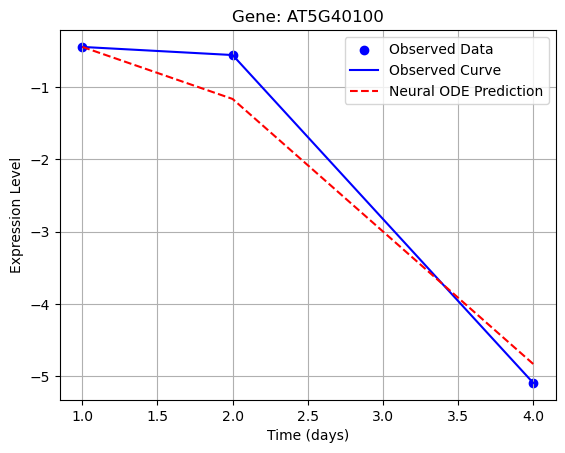

Learned ODE for Gene AT5G40100:
  dy/dt = -0.0296 + 0.3638 * y + -0.2747 * t
Formatted ODE Equation: dy/dt = -0.0296 + 0.3638 * y(t) + -0.2747 * t



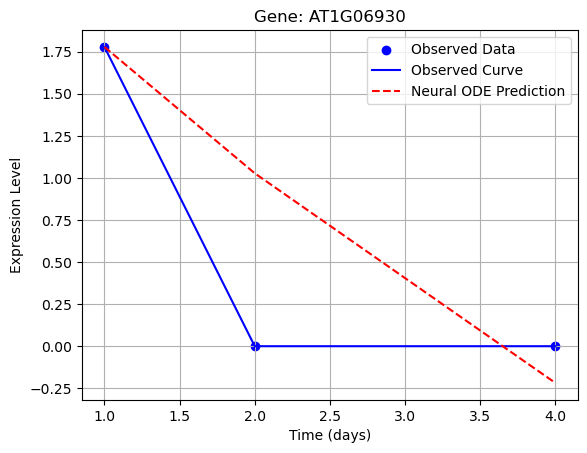

Learned ODE for Gene AT1G06930:
  dy/dt = -0.2006 + -0.2818 * y + -0.1049 * t
Formatted ODE Equation: dy/dt = -0.2006 + -0.2818 * y(t) + -0.1049 * t



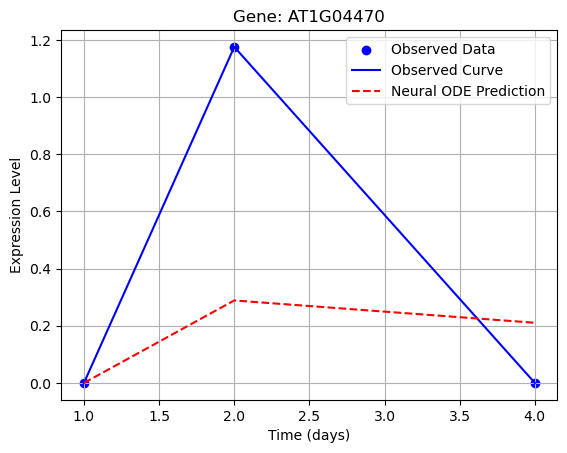

Learned ODE for Gene AT1G04470:
  dy/dt = 0.6269 + -0.3589 * y + -0.1854 * t
Formatted ODE Equation: dy/dt = 0.6269 + -0.3589 * y(t) + -0.1854 * t



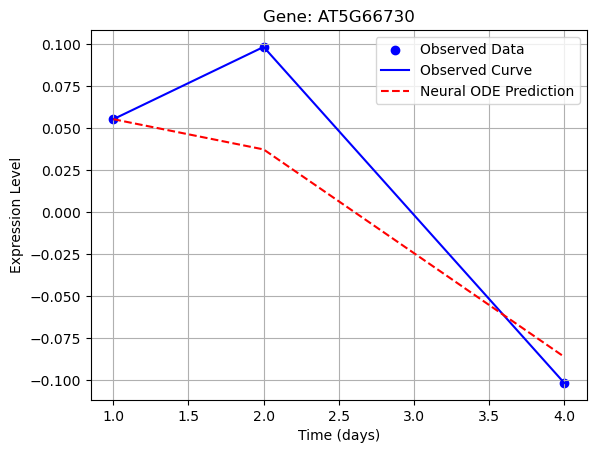

Learned ODE for Gene AT5G66730:
  dy/dt = 0.0316 + -0.0514 * y + -0.0314 * t
Formatted ODE Equation: dy/dt = 0.0316 + -0.0514 * y(t) + -0.0314 * t



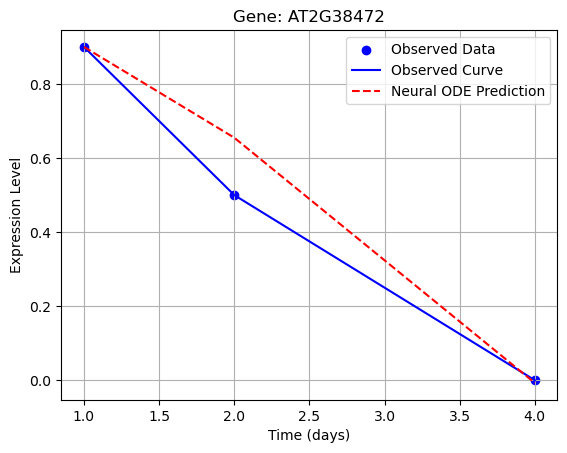

Learned ODE for Gene AT2G38472:
  dy/dt = -0.0514 + -0.0880 * y + -0.0832 * t
Formatted ODE Equation: dy/dt = -0.0514 + -0.0880 * y(t) + -0.0832 * t



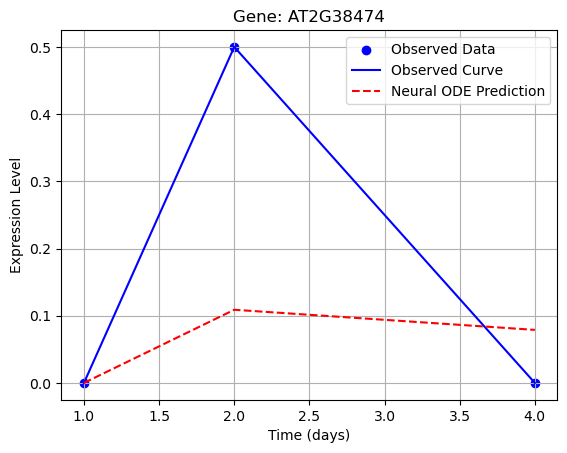

Learned ODE for Gene AT2G38474:
  dy/dt = 0.2333 + -0.1246 * y + -0.0778 * t
Formatted ODE Equation: dy/dt = 0.2333 + -0.1246 * y(t) + -0.0778 * t



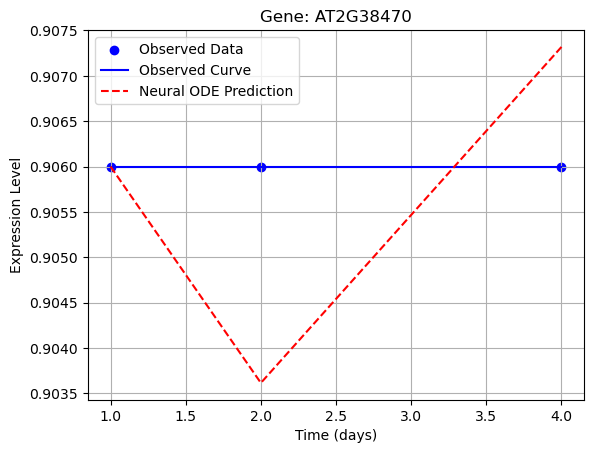

Learned ODE for Gene AT2G38470:
  dy/dt = 0.0081 + -0.0163 * y + 0.0028 * t
Formatted ODE Equation: dy/dt = 0.0081 + -0.0163 * y(t) + 0.0028 * t



In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

print("Original Data:")
print(df)

# Time points (in days)
time_points = np.array([1.0, 2.0, 4.0], dtype=np.float32)  # Day1, Day2, Day4

# Extract gene expression data (each row is one gene)
gene_data = df[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values

# Convert to PyTorch tensors
time_points_tensor = torch.tensor(time_points, dtype=torch.float32, requires_grad=True)
gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)

##############################################################################
# Parametric ODE Model for Each Gene: dy/dt = α + β * y(t) + γ * t
##############################################################################

class GeneParametricODE(nn.Module):
    def __init__(self):
        super(GeneParametricODE, self).__init__()
        # Learnable parameters: α, β, and γ
        self.alpha = nn.Parameter(torch.tensor(0.1))
        self.beta = nn.Parameter(torch.tensor(0.1))
        self.gamma = nn.Parameter(torch.tensor(0.1))

    def forward(self, t, y):
        # ODE: dy/dt = α + β * y(t) + γ * t
        return self.alpha + self.beta * y + self.gamma * t

# Create one ODE model per gene
num_genes = gene_data_tensor.shape[0]
ode_models = nn.ModuleList([GeneParametricODE() for _ in range(num_genes)])

##############################################################################
# Inverse PINN Loss Function (Data Loss + Physics Loss)
##############################################################################

def inverse_pinn_loss(ode_models, time_points, gene_data, lambda_physics=0.1):
    total_data_loss = 0.0
    total_physics_loss = 0.0
    n_genes = gene_data.shape[0]

    for i in range(n_genes):
        # Observed expression for gene i (shape: (num_time_points,))
        y_observed = gene_data[i]
        # Use the first time point as the initial condition
        y0 = y_observed[0].unsqueeze(0)  # shape: (1,)

        # Solve the ODE for gene i over the time points
        preds = odeint(ode_models[i], y0, time_points).squeeze()  # shape: (num_time_points,)

        # Data loss: Mean squared error between predictions and observed values
        data_loss = torch.mean((preds - y_observed)**2)

        # Physics loss: Enforce that the derivative from autograd matches the ODE output
        dy_dt_pred = torch.autograd.grad(
            outputs=preds,
            inputs=time_points,
            grad_outputs=torch.ones_like(preds),
            create_graph=True,
            retain_graph=True
        )[0]

        dy_dt_ode = []
        for t_val, p_val in zip(time_points, preds):
            deriv = ode_models[i](t_val, p_val.unsqueeze(0))
            dy_dt_ode.append(deriv.squeeze())
        dy_dt_ode = torch.stack(dy_dt_ode)

        physics_loss = torch.mean((dy_dt_pred - dy_dt_ode)**2)

        total_data_loss += data_loss
        total_physics_loss += physics_loss

    avg_data_loss = total_data_loss / n_genes
    avg_physics_loss = total_physics_loss / n_genes
    total_loss = avg_data_loss + lambda_physics * avg_physics_loss
    return total_loss, avg_data_loss, avg_physics_loss

##############################################################################
# Training Loop
##############################################################################

optimizer = optim.Adam(ode_models.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

epochs = 400

for epoch in range(epochs):
    optimizer.zero_grad()
    total_loss, data_loss, physics_loss = inverse_pinn_loss(ode_models, time_points_tensor, gene_data_tensor, lambda_physics=0.1)
    total_loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d} | Total Loss: {total_loss.item():.4f} | Data Loss: {data_loss.item():.4f} | Physics Loss: {physics_loss.item():.4f}")

##############################################################################
# Plotting Predictions and Printing Learned ODE Parameters
##############################################################################

with torch.no_grad():
    for i, gene_id in enumerate(df['Unnamed: 0']):
        # Use the Day1 value as the initial condition for each gene
        y0 = gene_data_tensor[i, 0].unsqueeze(0)  # shape: (1,)
        preds = odeint(ode_models[i], y0, time_points_tensor).squeeze().numpy()

        # Plot observed data vs. Neural ODE predictions
        plt.figure()
        plt.scatter(time_points, gene_data[i], c='b', label="Observed Data")
        plt.plot(time_points, gene_data[i], 'b-', label="Observed Curve")
        plt.plot(time_points, preds, 'r--', label="Neural ODE Prediction")
        plt.title(f"Gene: {gene_id}")
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Print learned parameters for the gene
        model = ode_models[i]
        alpha = model.alpha.item()
        beta = model.beta.item()
        gamma = model.gamma.item()
        print(f"Learned ODE for Gene {gene_id}:")
        print(f"  dy/dt = {alpha:.4f} + {beta:.4f} * y + {gamma:.4f} * t")
        print(f"Formatted ODE Equation: dy/dt = {alpha:.4f} + {beta:.4f} * y(t) + {gamma:.4f} * t\n")


In [45]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

print("Original Data:")
print(df)

# Time points (in days)
time_points = np.array([1.0, 2.0, 4.0], dtype=np.float32)  # Day1, Day2, Day4

# Extract gene expression data (each row is one gene)
gene_data = df[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values

# Convert to PyTorch tensors
time_points_tensor = torch.tensor(time_points, dtype=torch.float32)
gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)

##############################################################################
# Parametric ODE Model for Each Gene: dy/dt = α + β * y(t) + γ * t
##############################################################################

class GeneParametricODE(nn.Module):
    def __init__(self):
        super(GeneParametricODE, self).__init__()
        # Better initialization with some randomness
        self.alpha = nn.Parameter(torch.tensor(np.random.uniform(-0.5, 0.5)))
        self.beta = nn.Parameter(torch.tensor(np.random.uniform(-0.5, 0.5)))
        self.gamma = nn.Parameter(torch.tensor(np.random.uniform(-0.5, 0.5)))

    def forward(self, t, y):
        # ODE: dy/dt = α + β * y(t) + γ * t
        dydt = self.alpha + self.beta * y + self.gamma * t
        return dydt
    
    def get_parameters(self):
        return self.alpha.item(), self.beta.item(), self.gamma.item()


Original Data:
  Unnamed: 0  Hpa-NO_1d  Hpa-NO_2d  Hpa-NO_4d
0  AT5G40100  -0.447960  -0.560155  -5.091964
1  AT1G06930   1.778359   0.000000   0.000000
2  AT1G04470   0.000000   1.175150   0.000000
3  AT5G66730   0.055375   0.098435  -0.101757
4  AT2G38472   0.900000   0.500000   0.000000
5  AT2G38474   0.000000   0.500000   0.000000
6  AT2G38470   0.906000   0.906000   0.906000


In [46]:

##############################################################################
# Train each gene separately and track losses
##############################################################################

def train_gene_model(gene_id, gene_idx, gene_values, time_points, epochs=1000):
    # Create model for this gene
    model = GeneParametricODE()
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5)
    
    # Initial condition
    y0 = gene_values[0].unsqueeze(0)
    
    # Storage for losses
    total_losses = []
    data_losses = []
    physics_losses = []
    
    # Training loop
    best_loss = float('inf')
    patience_counter = 0
    max_patience = 50
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Solve ODE
        y_pred = odeint(model, y0, time_points).squeeze()
        
        # Data loss
        data_loss = torch.mean((y_pred - gene_values)**2)
        
        # Physics loss with collocation points
        t_colloc = torch.linspace(1.0, 4.0, 20)
        t_colloc.requires_grad_(True)
        
        # Get predicted y values at collocation points
        y_colloc = odeint(model, y0, t_colloc).squeeze()
        
        # Calculate derivatives at collocation points
        dy_dt = torch.autograd.grad(
            outputs=y_colloc,
            inputs=t_colloc,
            grad_outputs=torch.ones_like(y_colloc),
            create_graph=True
        )[0]
        
        # Calculate ODE residual at collocation points
        model_derivs = []
        for j in range(len(t_colloc)):
            derivs = model(t_colloc[j].item(), y_colloc[j].unsqueeze(0))
            model_derivs.append(derivs)
        
        model_derivs = torch.cat(model_derivs)
        physics_loss = torch.mean((dy_dt - model_derivs)**2)
        
        # Total loss with adaptive weighting
        lambda_physics = min(0.1 * (epoch / 100), 1.0)
        total_loss = data_loss + lambda_physics * physics_loss
        
        # Backward pass and optimization
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        # Store losses
        total_losses.append(total_loss.item())
        data_losses.append(data_loss.item())
        physics_losses.append(physics_loss.item())
        
        # Learning rate scheduler
        scheduler.step(total_loss)
        
        # Early stopping
        if total_loss < best_loss:
            best_loss = total_loss.item()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= max_patience:
            print(f"Early stopping at epoch {epoch}")
            break
        
        # Print progress
        if epoch % 100 == 0 or epoch == epochs-1:
            print(f"Gene {gene_id} - Epoch {epoch}/{epochs}: Loss = {total_loss.item():.6f}, "
                  f"Data = {data_loss.item():.6f}, Physics = {physics_loss.item():.6f}")
    
    losses_dict = {
        'total': total_losses,
        'data': data_losses,
        'physics': physics_losses
    }
    
    return model, losses_dict



Training Neural ODE + Inverse PINN model for gene AT5G40100 (1/7):
Gene AT5G40100 - Epoch 0/1000: Loss = 3.450578, Data = 3.450578, Physics = 2.985141
Early stopping at epoch 72


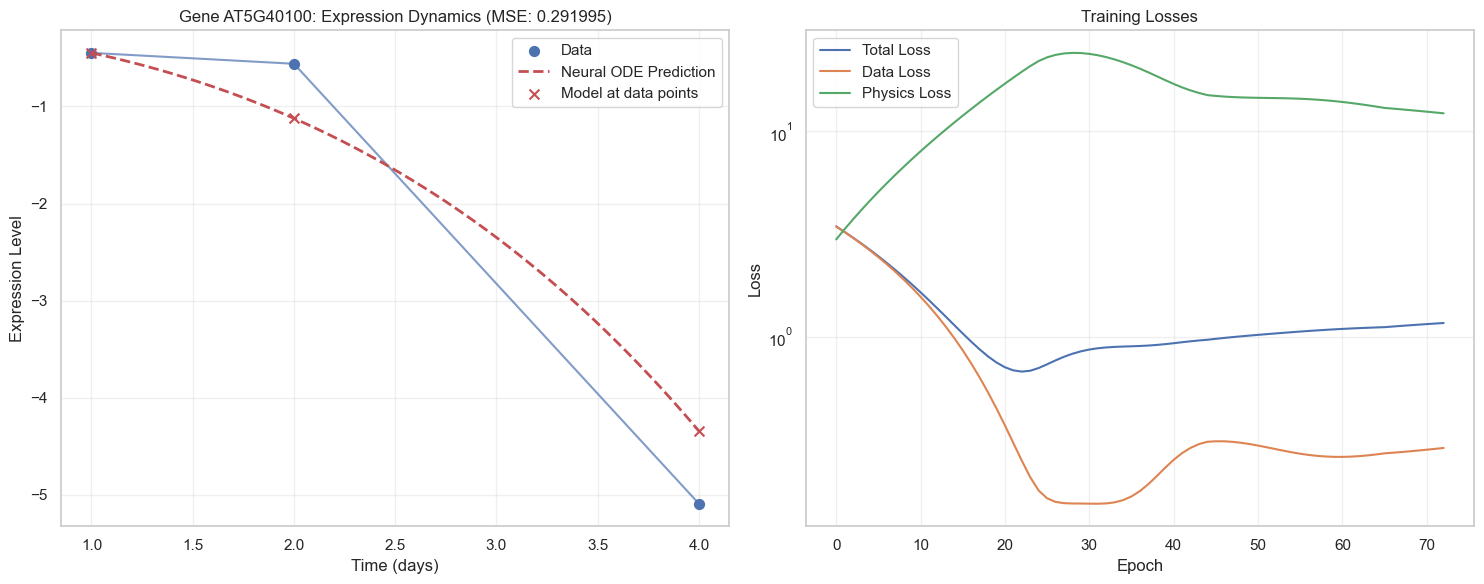

Learned ODE for Gene AT5G40100:
  dy/dt = -0.0630 + 0.3295 * y + -0.2438 * t
  System stability: Unstable (growing over time)
  MSE: 0.291995

Training Neural ODE + Inverse PINN model for gene AT1G06930 (2/7):
Gene AT1G06930 - Epoch 0/1000: Loss = 5.762157, Data = 5.762157, Physics = 8.442064
Early stopping at epoch 85


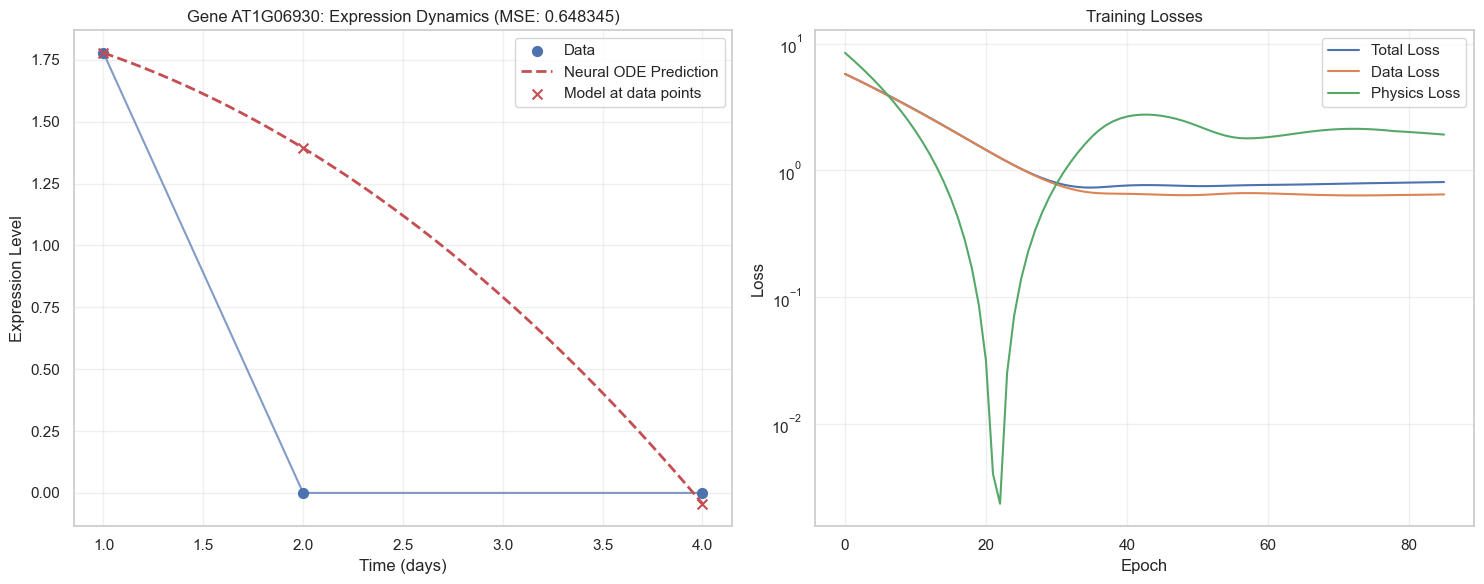

Learned ODE for Gene AT1G06930:
  dy/dt = -0.2044 + 0.0629 * y + -0.1873 * t
  System stability: Unstable (growing over time)
  MSE: 0.648345

Training Neural ODE + Inverse PINN model for gene AT1G04470 (3/7):
Gene AT1G04470 - Epoch 0/1000: Loss = 1.414242, Data = 1.414242, Physics = 0.666969
Early stopping at epoch 70


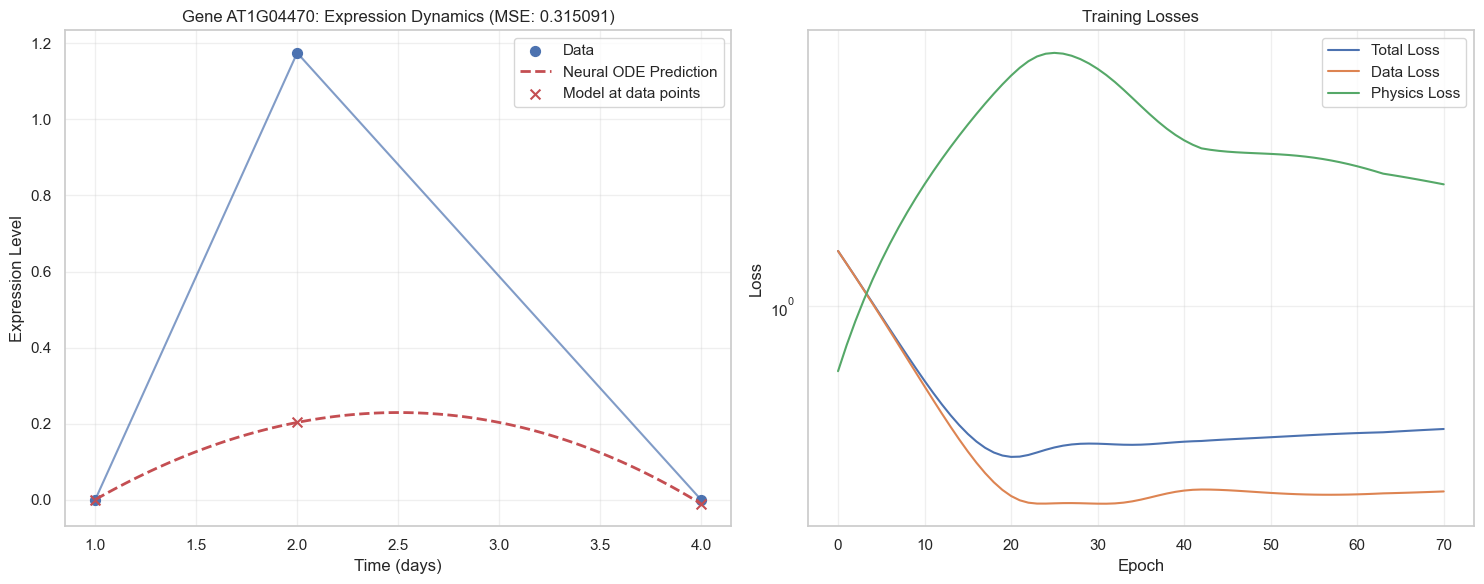

Learned ODE for Gene AT1G04470:
  dy/dt = 0.5092 + 0.0522 * y + -0.2083 * t
  System stability: Unstable (growing over time)
  MSE: 0.315091

Training Neural ODE + Inverse PINN model for gene AT5G66730 (4/7):
Gene AT5G66730 - Epoch 0/1000: Loss = 1.132294, Data = 1.132294, Physics = 4.590214
Early stopping at epoch 93


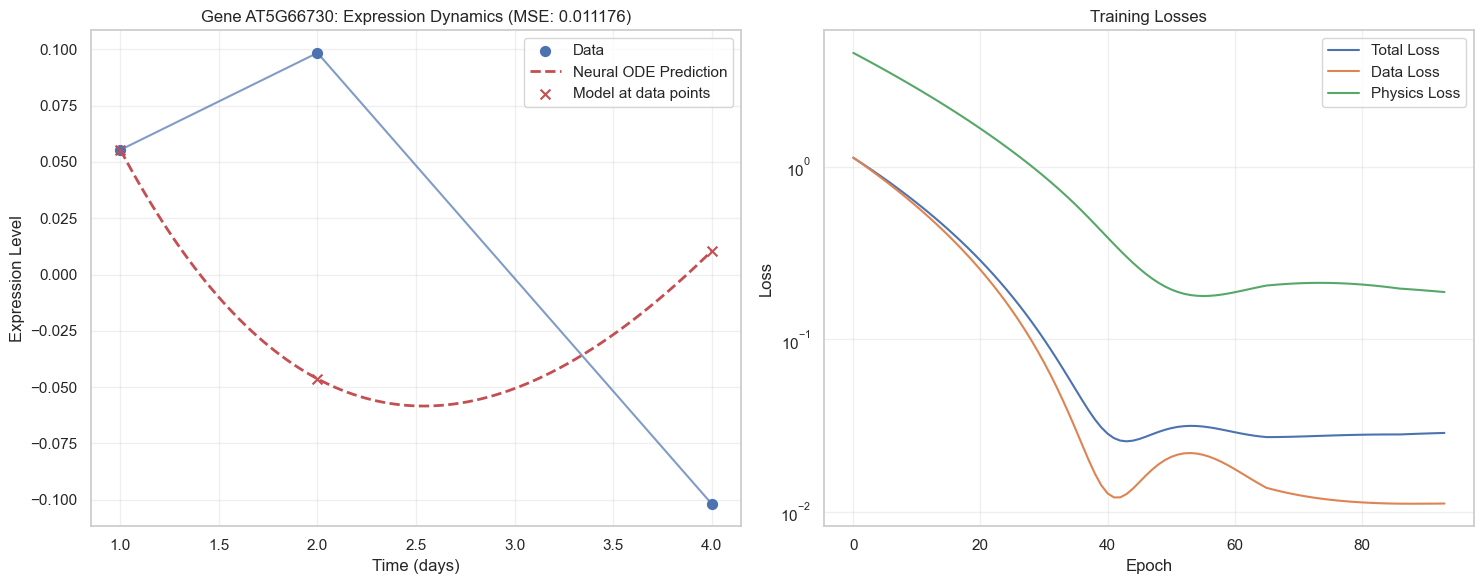

Learned ODE for Gene AT5G66730:
  dy/dt = -0.2200 + -0.3982 * y + 0.0775 * t
  System stability: Stable (decaying over time)
  MSE: 0.011176

Training Neural ODE + Inverse PINN model for gene AT2G38472 (5/7):
Gene AT2G38472 - Epoch 0/1000: Loss = 0.282899, Data = 0.282899, Physics = 1.022483
Early stopping at epoch 70


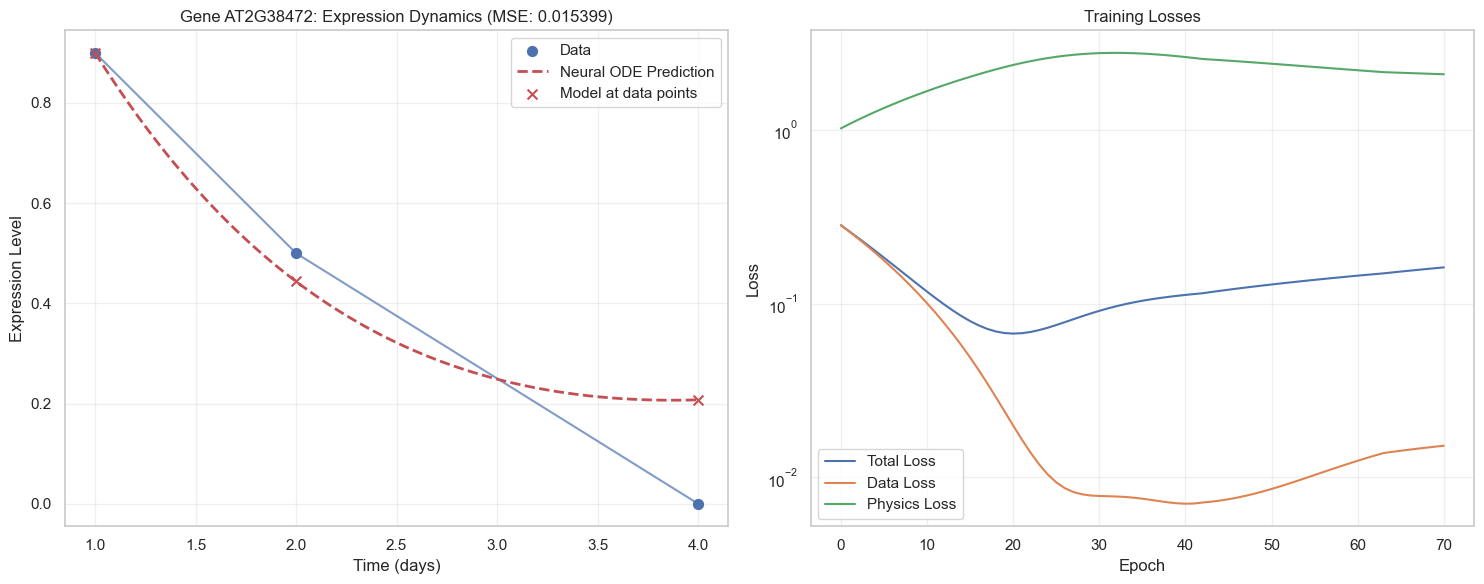

Learned ODE for Gene AT2G38472:
  dy/dt = -0.2551 + -0.5324 * y + 0.0943 * t
  System stability: Stable (decaying over time)
  MSE: 0.015399

Training Neural ODE + Inverse PINN model for gene AT2G38474 (6/7):
Gene AT2G38474 - Epoch 0/1000: Loss = 0.333757, Data = 0.333757, Physics = 0.382544
Gene AT2G38474 - Epoch 100/1000: Loss = 0.073299, Data = 0.067458, Physics = 0.058411
Early stopping at epoch 132


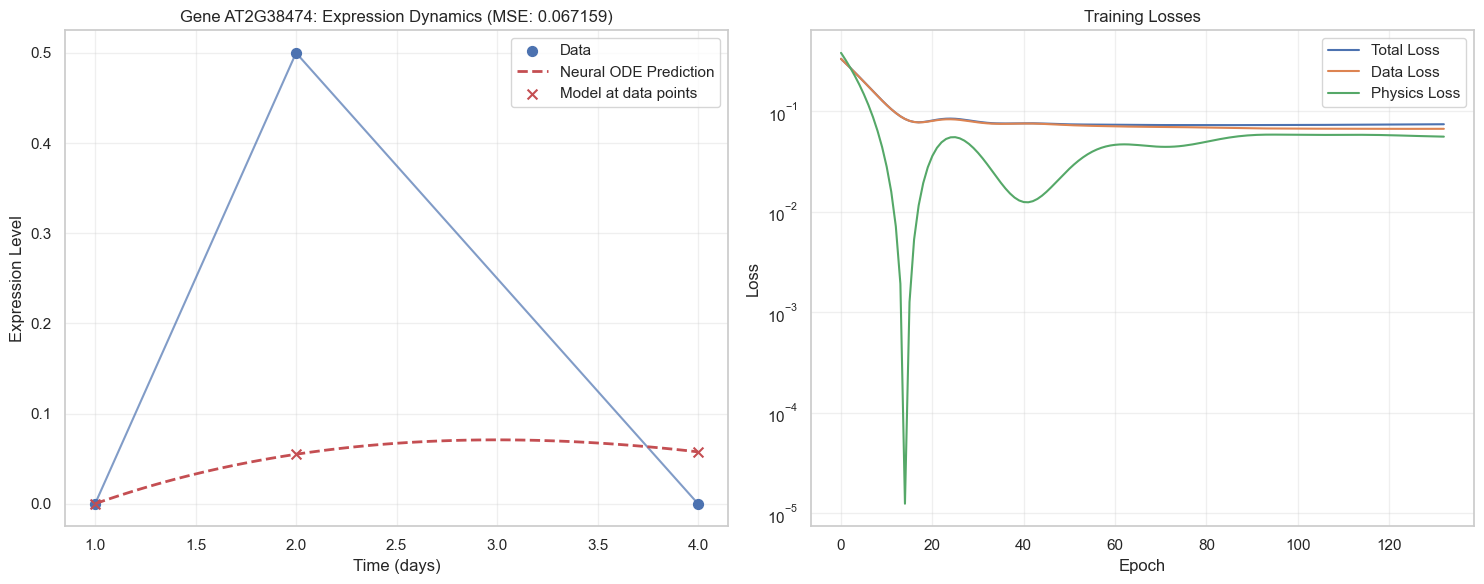

Learned ODE for Gene AT2G38474:
  dy/dt = 0.1073 + -0.2825 * y + -0.0291 * t
  System stability: Stable (decaying over time)
  MSE: 0.067159

Training Neural ODE + Inverse PINN model for gene AT2G38470 (7/7):
Gene AT2G38470 - Epoch 0/1000: Loss = 19.038422, Data = 19.038422, Physics = 37.986736
Gene AT2G38470 - Epoch 100/1000: Loss = 0.041697, Data = 0.006617, Physics = 0.350801
Gene AT2G38470 - Epoch 200/1000: Loss = 0.000007, Data = 0.000003, Physics = 0.000024
Early stopping at epoch 229


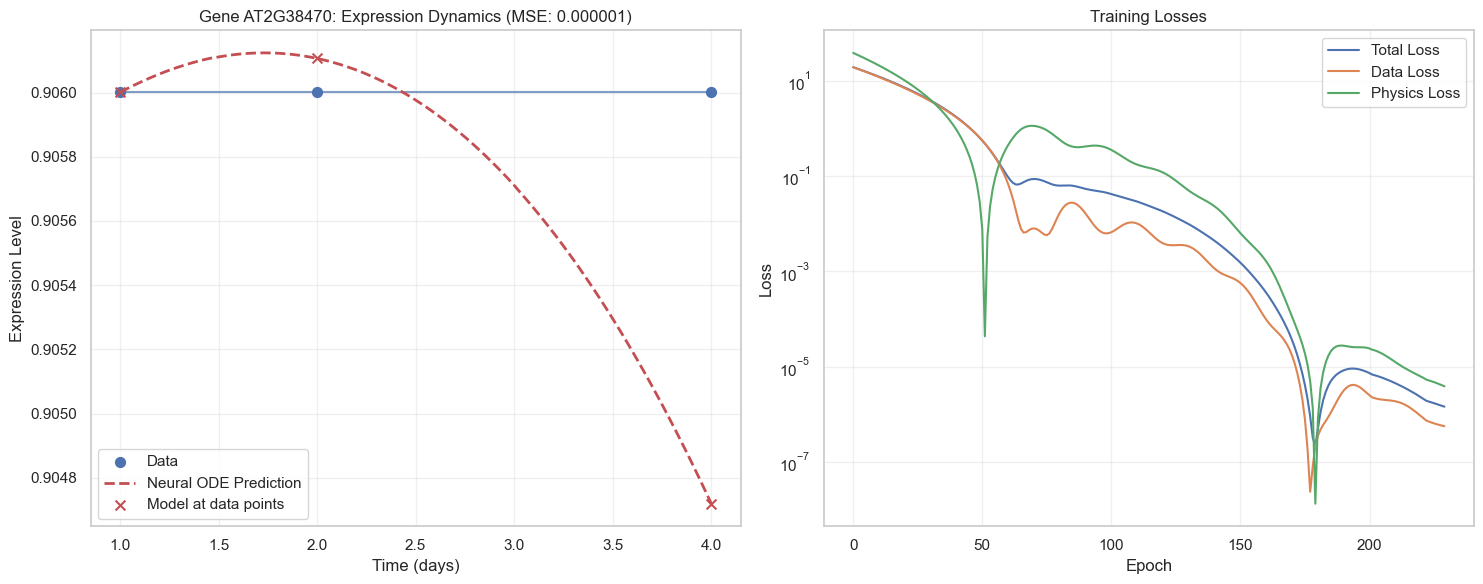

Learned ODE for Gene AT2G38470:
  dy/dt = -0.1519 + 0.1686 * y + -0.0005 * t
  System stability: Unstable (growing over time)
  MSE: 0.000001


In [47]:

##############################################################################
# Train all genes and visualize results
##############################################################################

# Store all models and parameters
all_models = []
all_params = []
all_losses = []

# Train each gene model separately
for i, gene_id in enumerate(df['Unnamed: 0']):
    print(f"\nTraining Neural ODE + Inverse PINN model for gene {gene_id} ({i+1}/{len(df)}):")
    gene_values = gene_data_tensor[i]
    
    # Train model and get losses
    model, losses = train_gene_model(gene_id, i, gene_values, time_points_tensor)
    
    all_models.append(model)
    all_losses.append(losses)
    
    # Extract parameters
    alpha, beta, gamma = model.get_parameters()
    all_params.append([alpha, beta, gamma])
    
    # Generate predictions
    y0 = gene_values[0].unsqueeze(0)
    t_fine = torch.linspace(1.0, 4.0, 100)
    
    with torch.no_grad():
        preds_fine = odeint(model, y0, t_fine).squeeze().numpy()
        preds = odeint(model, y0, time_points_tensor).squeeze().numpy()
    
    # Calculate MSE
    mse = np.mean((preds - gene_values.numpy())**2)
    
    # Create side-by-side plots for results and loss
    plt.figure(figsize=(15, 6))
    
    # Plot 1: Data and predictions
    plt.subplot(1, 2, 1)
    plt.scatter(time_points, gene_values.numpy(), c='b', s=50, label="Data")
    plt.plot(time_points, gene_values.numpy(), 'b-', alpha=0.7)
    plt.plot(t_fine.numpy(), preds_fine, 'r--', linewidth=2, label="Neural ODE Prediction")
    plt.scatter(time_points, preds, c='r', marker='x', s=50, label="Model at data points")
    plt.title(f"Gene {gene_id}: Expression Dynamics (MSE: {mse:.6f})")
    plt.xlabel("Time (days)")
    plt.ylabel("Expression Level")
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Plot 2: Loss curves
    plt.subplot(1, 2, 2)
    plt.plot(losses['total'], label='Total Loss')
    plt.plot(losses['data'], label='Data Loss')
    plt.plot(losses['physics'], label='Physics Loss')
    plt.title(f"Training Losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print learned ODE and stability analysis
    print(f"Learned ODE for Gene {gene_id}:")
    print(f"  dy/dt = {alpha:.4f} + {beta:.4f} * y + {gamma:.4f} * t")
    
    # Stability analysis
    if beta < 0:
        stability = "Stable (decaying over time)"
    elif beta > 0:
        stability = "Unstable (growing over time)"
    else:
        stability = "Neutral"
        
    print(f"  System stability: {stability}")
    print(f"  MSE: {mse:.6f}")


In [48]:

##############################################################################
# Cluster analysis of parameters
##############################################################################

# Convert parameters to array for clustering
param_array = np.array(all_params)

# Create parameter summary dataframe
param_df = pd.DataFrame({
    'Gene': df['Unnamed: 0'],
    'Alpha': param_array[:, 0],
    'Beta': param_array[:, 1],
    'Gamma': param_array[:, 2]
})
print("\nLearned Parameters Summary:")
print(param_df)

# Apply K-means clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Scale the parameters
scaler = StandardScaler()
param_scaled = scaler.fit_transform(param_array)

# Apply K-means clustering
k = 3  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(param_scaled)

# Add cluster information to the dataframe
param_df['Cluster'] = clusters

print("\nCluster Assignments:")
print(param_df[['Gene', 'Cluster']])



Learned Parameters Summary:
        Gene     Alpha      Beta     Gamma
0  AT5G40100 -0.063041  0.329535 -0.243778
1  AT1G06930 -0.204392  0.062905 -0.187261
2  AT1G04470  0.509225  0.052193 -0.208282
3  AT5G66730 -0.220034 -0.398226  0.077516
4  AT2G38472 -0.255129 -0.532350  0.094311
5  AT2G38474  0.107299 -0.282526 -0.029109
6  AT2G38470 -0.151916  0.168570 -0.000479

Cluster Assignments:
        Gene  Cluster
0  AT5G40100        2
1  AT1G06930        2
2  AT1G04470        0
3  AT5G66730        1
4  AT2G38472        1
5  AT2G38474        1
6  AT2G38470        1


c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


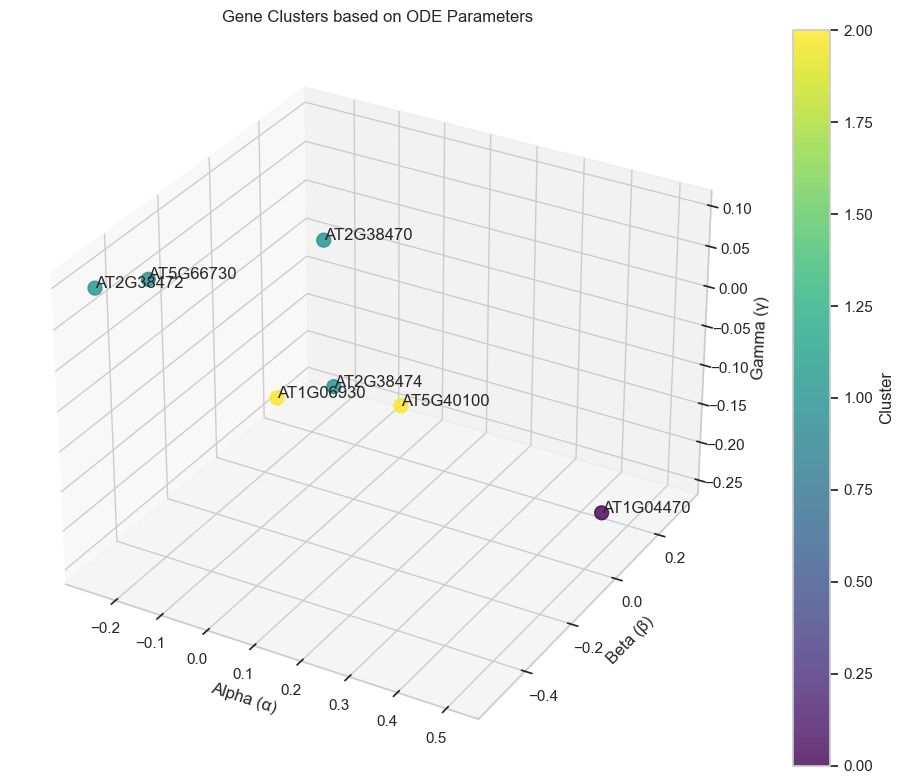

In [49]:

# Visualize clusters in 3D space
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')
scatter = ax.scatter(param_array[:, 0], param_array[:, 1], param_array[:, 2], 
                    c=clusters, cmap='viridis', s=100, alpha=0.8)

# Add gene labels
for i, gene in enumerate(df['Unnamed: 0']):
    ax.text(param_array[i, 0], param_array[i, 1], param_array[i, 2], gene)

ax.set_xlabel('Alpha (α)')
ax.set_ylabel('Beta (β)')
ax.set_zlabel('Gamma (γ)')
plt.colorbar(scatter, label='Cluster')
plt.title('Gene Clusters based on ODE Parameters')
plt.tight_layout()
plt.show()


In [50]:

# Generate cluster statistics
print("\nCluster Statistics:")
for cluster_id in range(k):
    cluster_genes = param_df[param_df['Cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} - {len(cluster_genes)} genes:")
    print(f"Genes: {', '.join(cluster_genes['Gene'].values)}")
    print(f"Alpha: mean = {cluster_genes['Alpha'].mean():.4f}, std = {cluster_genes['Alpha'].std():.4f}")
    print(f"Beta:  mean = {cluster_genes['Beta'].mean():.4f}, std = {cluster_genes['Beta'].std():.4f}")
    print(f"Gamma: mean = {cluster_genes['Gamma'].mean():.4f}, std = {cluster_genes['Gamma'].std():.4f}")


Cluster Statistics:

Cluster 0 - 1 genes:
Genes: AT1G04470
Alpha: mean = 0.5092, std = nan
Beta:  mean = 0.0522, std = nan
Gamma: mean = -0.2083, std = nan

Cluster 1 - 4 genes:
Genes: AT5G66730, AT2G38472, AT2G38474, AT2G38470
Alpha: mean = -0.1299, std = 0.1639
Beta:  mean = -0.2611, std = 0.3041
Gamma: mean = 0.0356, std = 0.0597

Cluster 2 - 2 genes:
Genes: AT5G40100, AT1G06930
Alpha: mean = -0.1337, std = 0.1000
Beta:  mean = 0.1962, std = 0.1885
Gamma: mean = -0.2155, std = 0.0400


Original Data:
  Unnamed: 0  Hpa-NO_1d  Hpa-NO_2d  Hpa-NO_4d
0  AT5G40100  -0.447960  -0.560155  -5.091964
1  AT1G06930   1.778359   0.000000   0.000000
2  AT1G04470   0.000000   1.175150   0.000000
3  AT5G66730   0.055375   0.098435  -0.101757
4  AT2G38472   0.900000   0.500000   0.000000
5  AT2G38474   0.000000   0.500000   0.000000
6  AT2G38470   0.906000   0.906000   0.906000


c:\Users\praba\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch    0 | Total Loss: 2.839941 | Data Loss: 2.839941 | Physics Loss: 0.740290
Epoch   50 | Total Loss: 0.404188 | Data Loss: 0.392387 | Physics Loss: 0.472057
Epoch  100 | Total Loss: 0.133633 | Data Loss: 0.098285 | Physics Loss: 0.706952
Epoch  150 | Total Loss: 0.146919 | Data Loss: 0.094746 | Physics Loss: 0.695645
Early stopping triggered at epoch 176


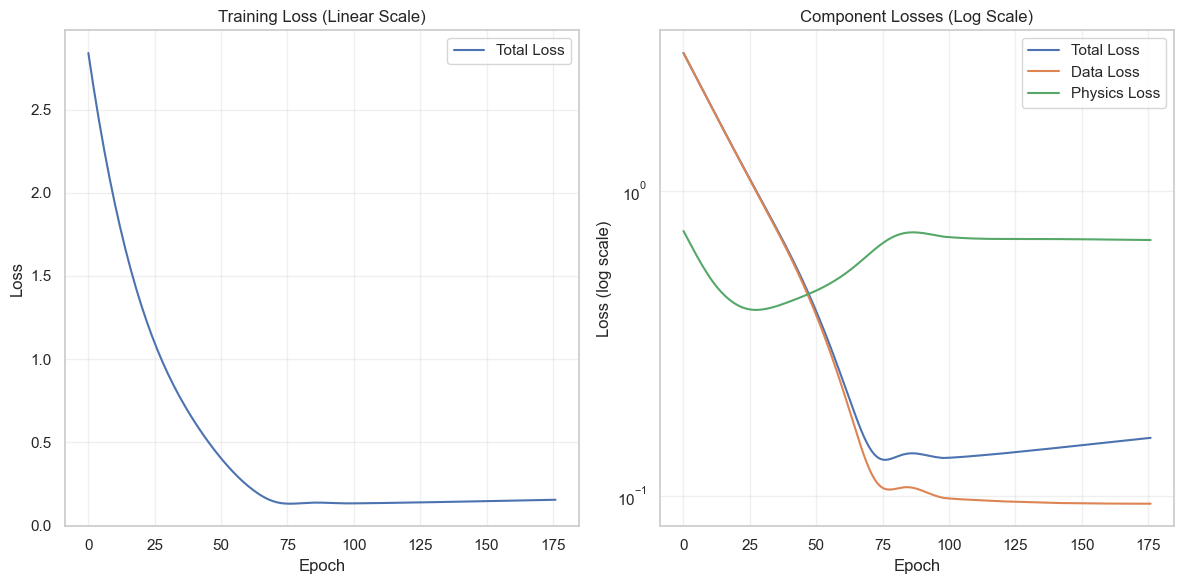

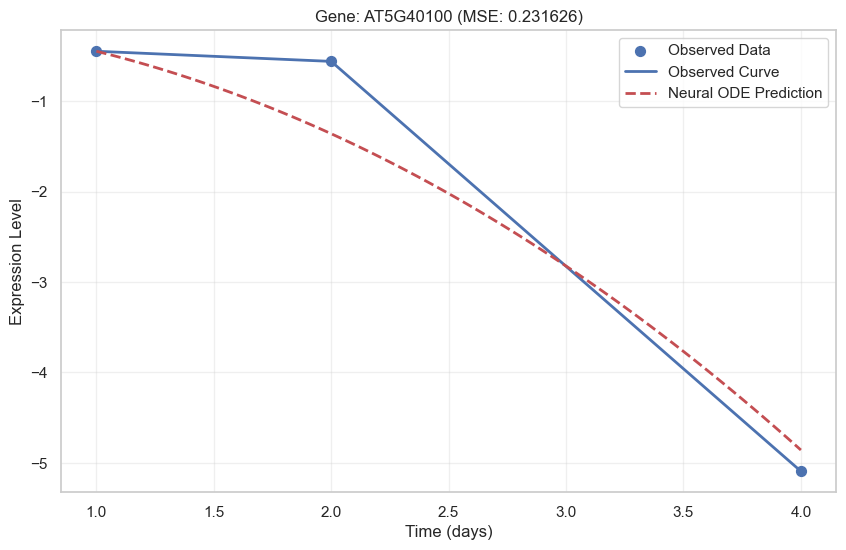

Learned ODE for Gene AT5G40100:
  dy/dt = -0.1204 + 0.0374 * y + -0.5063 * t
  System analysis: Neutral stability (minimal self-feedback)
  MSE: 0.231626



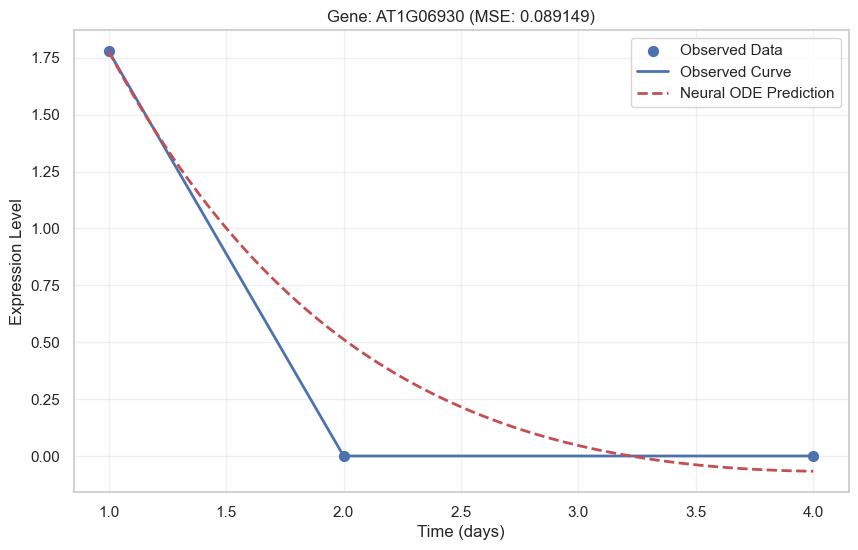

Learned ODE for Gene AT1G06930:
  dy/dt = -0.6154 + -0.8150 * y + 0.1367 * t
  System analysis: Stable system (expression naturally decreases)
  MSE: 0.089149



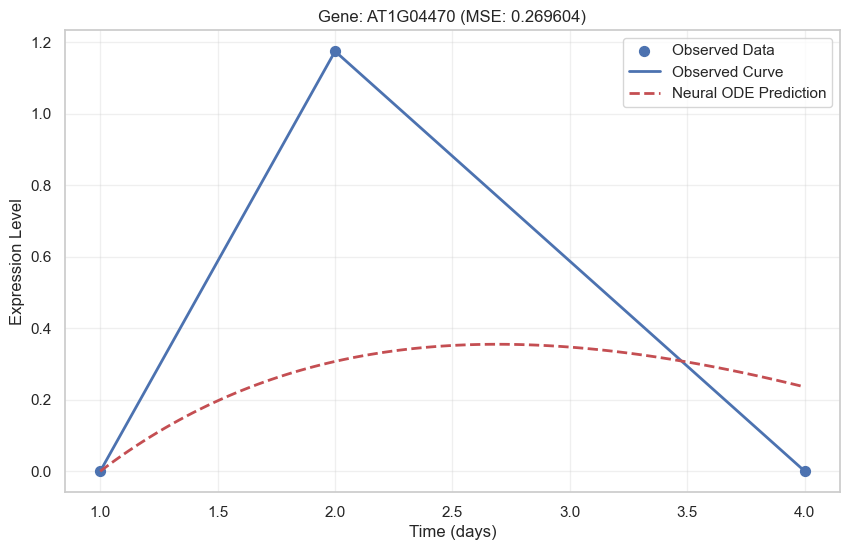

Learned ODE for Gene AT1G04470:
  dy/dt = 0.6746 + -0.5669 * y + -0.1759 * t
  System analysis: Stable system (expression naturally decreases)
  MSE: 0.269604



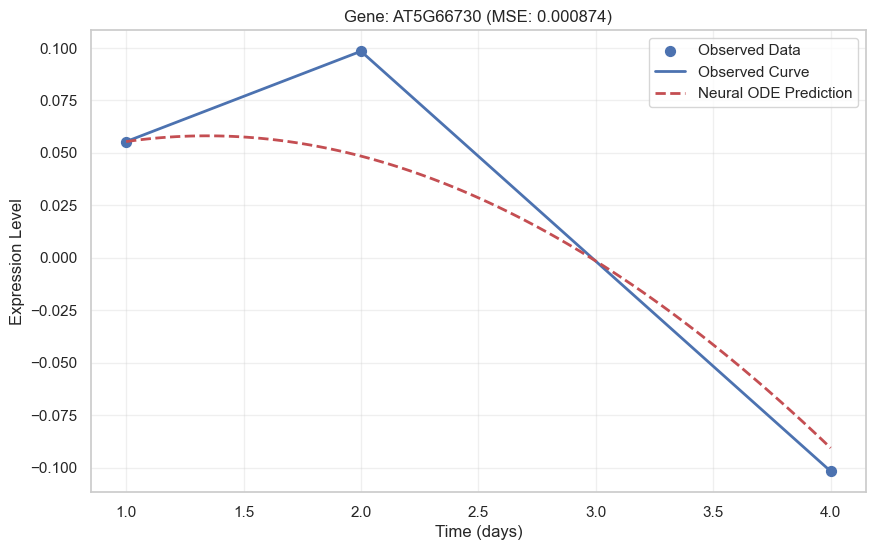

Learned ODE for Gene AT5G66730:
  dy/dt = 0.0674 + -0.0973 * y + -0.0459 * t
  System analysis: Neutral stability (minimal self-feedback)
  MSE: 0.000874



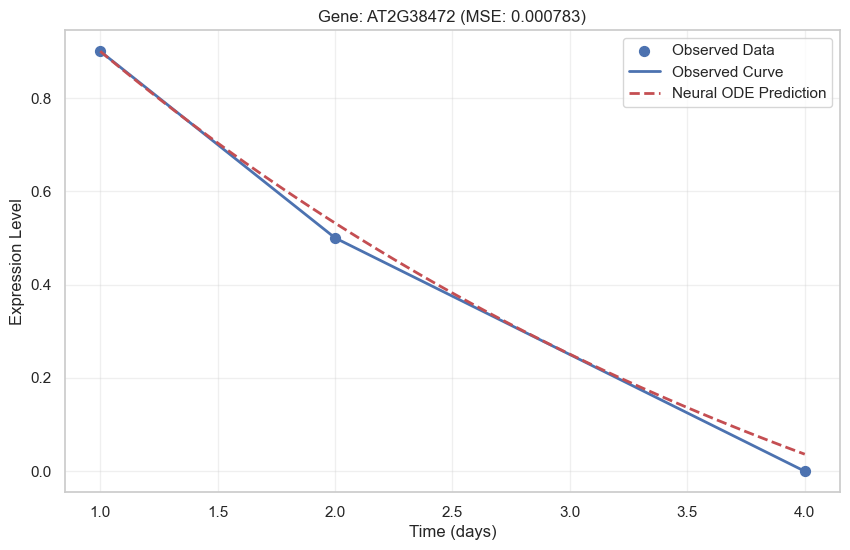

Learned ODE for Gene AT2G38472:
  dy/dt = -0.1797 + -0.2679 * y + 0.0007 * t
  System analysis: Stable system (expression naturally decreases)
  MSE: 0.000783



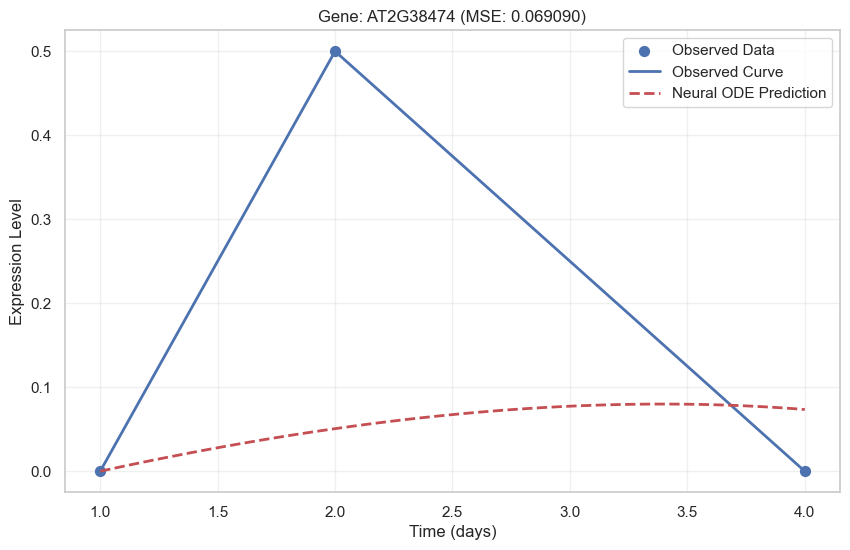

Learned ODE for Gene AT2G38474:
  dy/dt = 0.0945 + 0.2458 * y + -0.0336 * t
  System analysis: Unstable system (expression naturally increases)
  MSE: 0.069090



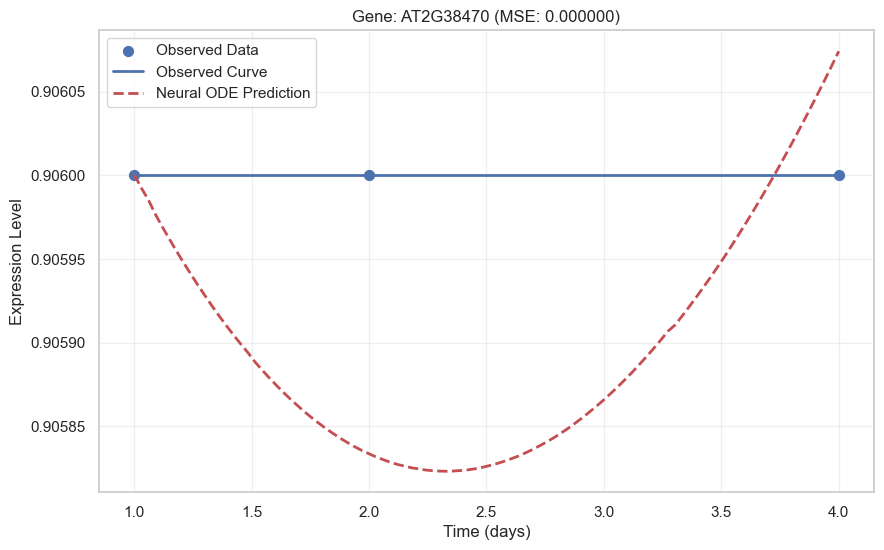

Learned ODE for Gene AT2G38470:
  dy/dt = 0.0997 + -0.1106 * y + 0.0002 * t
  System analysis: Stable system (expression naturally decreases)
  MSE: 0.000000



In [52]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

print("Original Data:")
print(df)

# Time points (in days)
time_points = np.array([1.0, 2.0, 4.0], dtype=np.float32)  # Day1, Day2, Day4

# Extract gene expression data (each row is one gene)
gene_data = df[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values

# Convert to PyTorch tensors
time_points_tensor = torch.tensor(time_points, dtype=torch.float32, requires_grad=True)
gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)

##############################################################################
# Parametric ODE Model for Each Gene: dy/dt = α + β * y(t) + γ * t
##############################################################################

class GeneParametricODE(nn.Module):
    def __init__(self, init_alpha=0.1, init_beta=0.1, init_gamma=0.1):
        super(GeneParametricODE, self).__init__()
        # Learnable parameters: α, β, and γ with better initialization
        self.alpha = nn.Parameter(torch.tensor(init_alpha))
        self.beta = nn.Parameter(torch.tensor(init_beta))
        self.gamma = nn.Parameter(torch.tensor(init_gamma))

    def forward(self, t, y):
        # ODE: dy/dt = α + β * y(t) + γ * t
        return self.alpha + self.beta * y + self.gamma * t

# Create one ODE model per gene with randomized initial parameters
torch.manual_seed(42)  # For reproducibility
num_genes = gene_data_tensor.shape[0]
ode_models = nn.ModuleList([
    GeneParametricODE(
        init_alpha=np.random.uniform(-0.5, 0.5),
        init_beta=np.random.uniform(-0.5, 0.5),
        init_gamma=np.random.uniform(-0.5, 0.5)
    ) for _ in range(num_genes)
])

##############################################################################
# Inverse PINN Loss Function (Data Loss + Physics Loss)
##############################################################################

def inverse_pinn_loss(ode_models, time_points, gene_data, lambda_physics=0.1):
    total_data_loss = 0.0
    total_physics_loss = 0.0
    n_genes = gene_data.shape[0]

    for i in range(n_genes):
        # Observed expression for gene i
        y_observed = gene_data[i]
        # Use the first time point as the initial condition
        y0 = y_observed[0].unsqueeze(0)

        # Solve the ODE for gene i over the time points
        preds = odeint(ode_models[i], y0, time_points).squeeze()

        # Data loss: Mean squared error between predictions and observed values
        data_loss = torch.mean((preds - y_observed)**2)

        # Physics loss: Enforce that the derivative from autograd matches the ODE output
        dy_dt_pred = torch.autograd.grad(
            outputs=preds,
            inputs=time_points,
            grad_outputs=torch.ones_like(preds),
            create_graph=True,
            retain_graph=True
        )[0]

        dy_dt_ode = []
        for t_val, p_val in zip(time_points, preds):
            deriv = ode_models[i](t_val, p_val.unsqueeze(0))
            dy_dt_ode.append(deriv.squeeze())
        dy_dt_ode = torch.stack(dy_dt_ode)

        physics_loss = torch.mean((dy_dt_pred - dy_dt_ode)**2)

        total_data_loss += data_loss
        total_physics_loss += physics_loss

    avg_data_loss = total_data_loss / n_genes
    avg_physics_loss = total_physics_loss / n_genes
    total_loss = avg_data_loss + lambda_physics * avg_physics_loss
    return total_loss, avg_data_loss, avg_physics_loss

##############################################################################
# Training Loop with Loss Tracking
##############################################################################

# Use a lower learning rate for stability
optimizer = optim.Adam(ode_models.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5, verbose=True)

epochs = 500
early_stop_patience = 100
best_loss = float('inf')
patience_counter = 0

# Lists to track losses
total_losses = []
data_losses = []
physics_losses = []

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Compute losses
    total_loss, data_loss, physics_loss = inverse_pinn_loss(
        ode_models, time_points_tensor, gene_data_tensor, 
        lambda_physics=0.1 * min(1.0, epoch/200)  # Gradually increase physics weight
    )
    
    # Store losses for plotting
    total_losses.append(total_loss.item())
    data_losses.append(data_loss.item())
    physics_losses.append(physics_loss.item())
    
    # Backward pass
    total_loss.backward()
    
    # Gradient clipping to prevent exploding gradients
    torch.nn.utils.clip_grad_norm_(ode_models.parameters(), max_norm=1.0)
    
    # Update parameters
    optimizer.step()
    
    # Learning rate scheduler
    scheduler.step(total_loss)
    
    # Early stopping check
    if total_loss < best_loss:
        best_loss = total_loss
        patience_counter = 0
    else:
        patience_counter += 1
        
    if patience_counter >= early_stop_patience:
        print(f"Early stopping triggered at epoch {epoch}")
        break
        
    # Print progress
    if epoch % 50 == 0 or epoch == epochs-1:
        print(f"Epoch {epoch:4d} | Total Loss: {total_loss.item():.6f} | "
              f"Data Loss: {data_loss.item():.6f} | Physics Loss: {physics_loss.item():.6f}")

# Plot the loss curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(total_losses, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss (Linear Scale)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(total_losses, label='Total Loss')
plt.plot(data_losses, label='Data Loss')
plt.plot(physics_losses, label='Physics Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.title('Component Losses (Log Scale)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.tight_layout()
plt.show()

##############################################################################
# Plotting Predictions and Printing Learned ODE Parameters
##############################################################################

with torch.no_grad():
    for i, gene_id in enumerate(df['Unnamed: 0']):
        # Use the Day1 value as the initial condition for each gene
        y0 = gene_data_tensor[i, 0].unsqueeze(0)
        
        # Generate smooth curve for visualization
        t_fine = torch.linspace(1.0, 4.0, 100)
        preds_fine = odeint(ode_models[i], y0, t_fine).squeeze().numpy()
        
        # Get predictions at data points
        preds = odeint(ode_models[i], y0, time_points_tensor).squeeze().numpy()
        
        # Calculate MSE
        mse = np.mean((preds - gene_data[i])**2)

        # Create figure for this gene
        plt.figure(figsize=(10, 6))
        
        # Plot observed data vs predictions
        plt.scatter(time_points, gene_data[i], c='b', s=50, label="Observed Data")
        plt.plot(time_points, gene_data[i], 'b-', linewidth=2, label="Observed Curve")
        plt.plot(t_fine.numpy(), preds_fine, 'r--', linewidth=2, label="Neural ODE Prediction")
        
        plt.title(f"Gene: {gene_id} (MSE: {mse:.6f})")
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        # Print learned parameters
        model = ode_models[i]
        alpha = model.alpha.item()
        beta = model.beta.item()
        gamma = model.gamma.item()
        
        print(f"Learned ODE for Gene {gene_id}:")
        print(f"  dy/dt = {alpha:.4f} + {beta:.4f} * y + {gamma:.4f} * t")
        
        # System stability analysis
        if beta < -0.1:
            stability = "Stable system (expression naturally decreases)"
        elif beta > 0.1:
            stability = "Unstable system (expression naturally increases)"
        else:
            stability = "Neutral stability (minimal self-feedback)"
            
        print(f"  System analysis: {stability}")
        print(f"  MSE: {mse:.6f}\n")

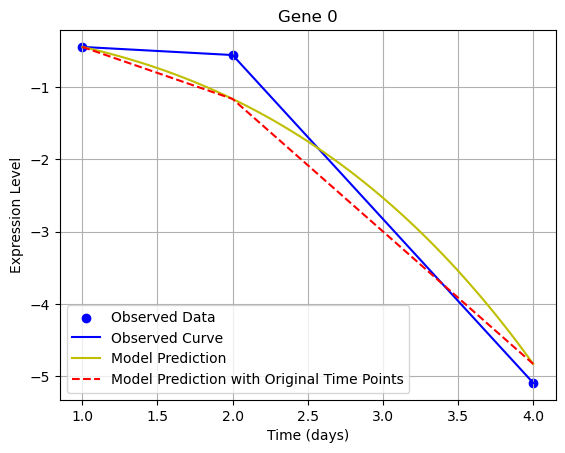

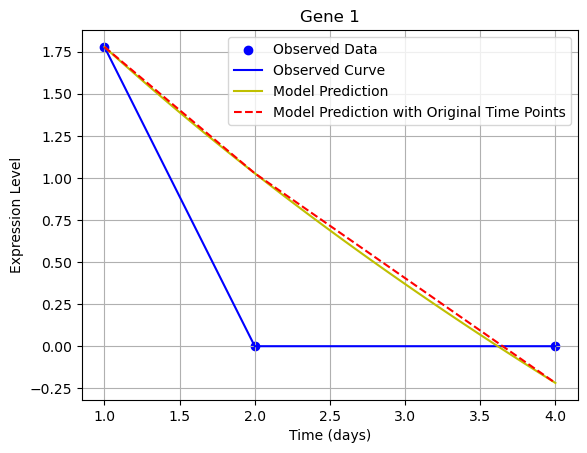

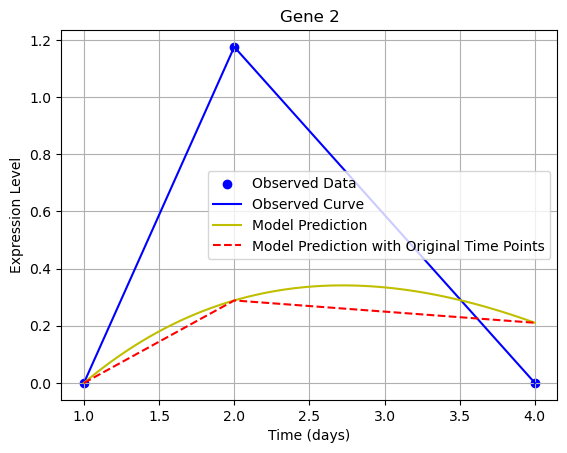

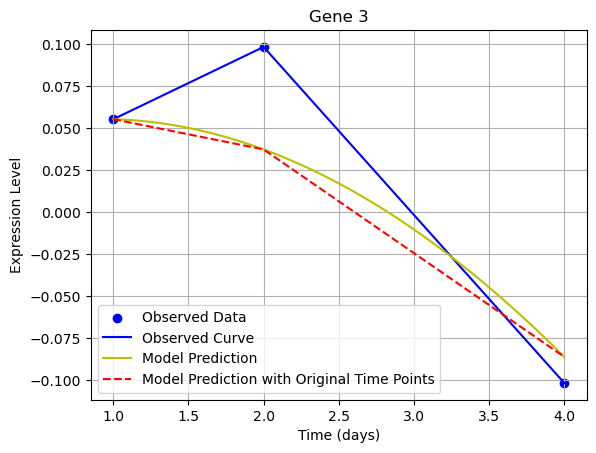

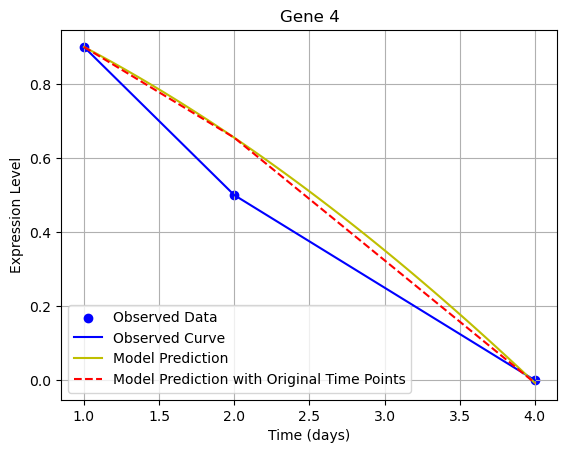

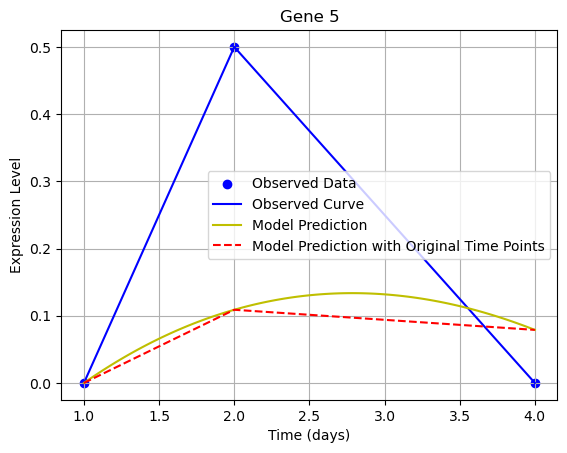

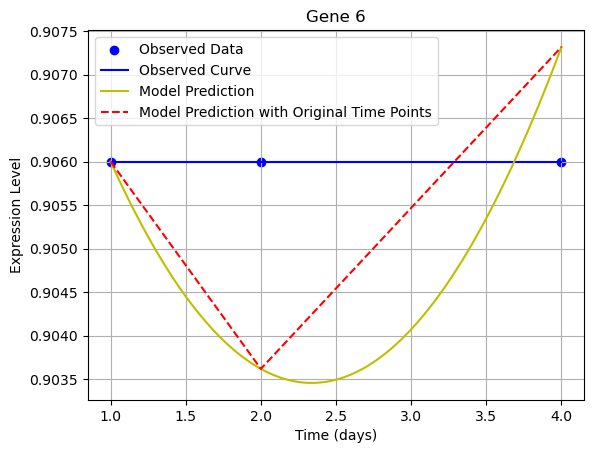

In [6]:
################################################################################
# 4. Predict at original & finer time points, then cluster alpha/beta/gamma
################################################################################
fine_t = torch.linspace(1, 4, steps=100)
for i, model in enumerate(ode_models):
    # Original observed data
    y_obs = gene_data_tensor[i]
    # Solve ODE for a finer range
    y0 = y_obs[0].unsqueeze(0)
    y_pred = odeint(model, y0, fine_t).squeeze().detach().numpy()
    y_pred_3 = odeint(model, y0, time_points_tensor).squeeze().detach().numpy()

    plt.figure()

    plt.scatter(time_points, gene_data[i], c='b', label="Observed Data")

    plt.plot(time_points, gene_data[i], 'b-', label="Observed Curve")

    # plt.plot(time_points.numpy(), y_obs.numpy(), 'ro', label='Data')
    plt.plot(fine_t.numpy(), y_pred, 'y-', label='Model Prediction')
    plt.plot(time_points, y_pred_3, 'r--', label="Model Prediction with Original Time Points")

    plt.title(f'Gene {df.index[i]}')
    plt.xlabel("Time (days)")
    plt.ylabel("Expression Level")
    plt.grid(True)
    
    plt.legend()
    plt.show()






In [7]:
n_genes = gene_data_tensor.shape[0]


Learned Parameters:
        Gene     alpha      beta     gamma
0  AT5G40100 -0.029587  0.363788 -0.274705
1  AT1G06930 -0.200648 -0.281768 -0.104929
2  AT1G04470  0.626873 -0.358907 -0.185361
3  AT5G66730  0.031551 -0.051446 -0.031368
4  AT2G38472 -0.051423 -0.087976 -0.083190
5  AT2G38474  0.233312 -0.124592 -0.077811
6  AT2G38470  0.008094 -0.016265  0.002823


c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



Cluster assignments for each gene:
[2 1 0 1 1 1 1]


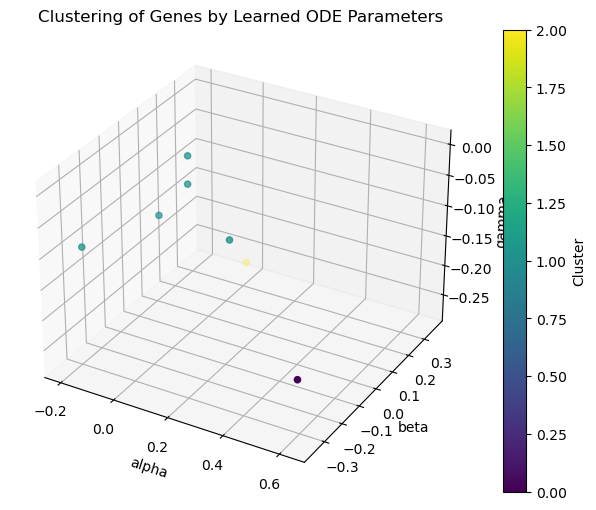

In [8]:
# =============================================================================
# 5. Clustering the Genes Based on Learned ODE Parameters (α, β, γ)
# =============================================================================

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Create a DataFrame to store parameters
params_df = pd.DataFrame(columns=['Gene', 'alpha', 'beta', 'gamma'])

with torch.no_grad():
    for i, gene_id in enumerate(df['Unnamed: 0']):
        model = ode_models[i]
        params_df.loc[i] = [
            gene_id,
            model.alpha.item(),
            model.beta.item(),
            model.gamma.item()
        ]

print("\nLearned Parameters:")
print(params_df)

# Prepare data for clustering
X = params_df[['alpha', 'beta', 'gamma']].values

# (Optional) Scale parameters before clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Choose number of clusters (k=3 here)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

print("\nCluster assignments for each gene:")
print(clusters)

# Extract learned parameters for plotting in 3D
alphas_learned = X[:, 0]
betas_learned = X[:, 1]
gammas_learned = X[:, 2]

# Plot the clusters in 3D parameter space
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(alphas_learned, betas_learned, gammas_learned, c=clusters, cmap='viridis')
ax.set_xlabel("alpha")
ax.set_ylabel("beta")
ax.set_zlabel("gamma")
ax.set_title("Clustering of Genes by Learned ODE Parameters")
plt.colorbar(scatter, ax=ax, label="Cluster")
plt.show()

Average Test MSE on perturbed data: 0.110963
Number of genes in cluster 0: 1
Cluster 0 average parameters:
  α = 0.6269, β = -0.3589, γ = -0.1854
Number of genes in cluster 1: 5
Cluster 1 average parameters:
  α = 0.0042, β = -0.1124, γ = -0.0589
Number of genes in cluster 2: 1
Cluster 2 average parameters:
  α = -0.0296, β = 0.3638, γ = -0.2747


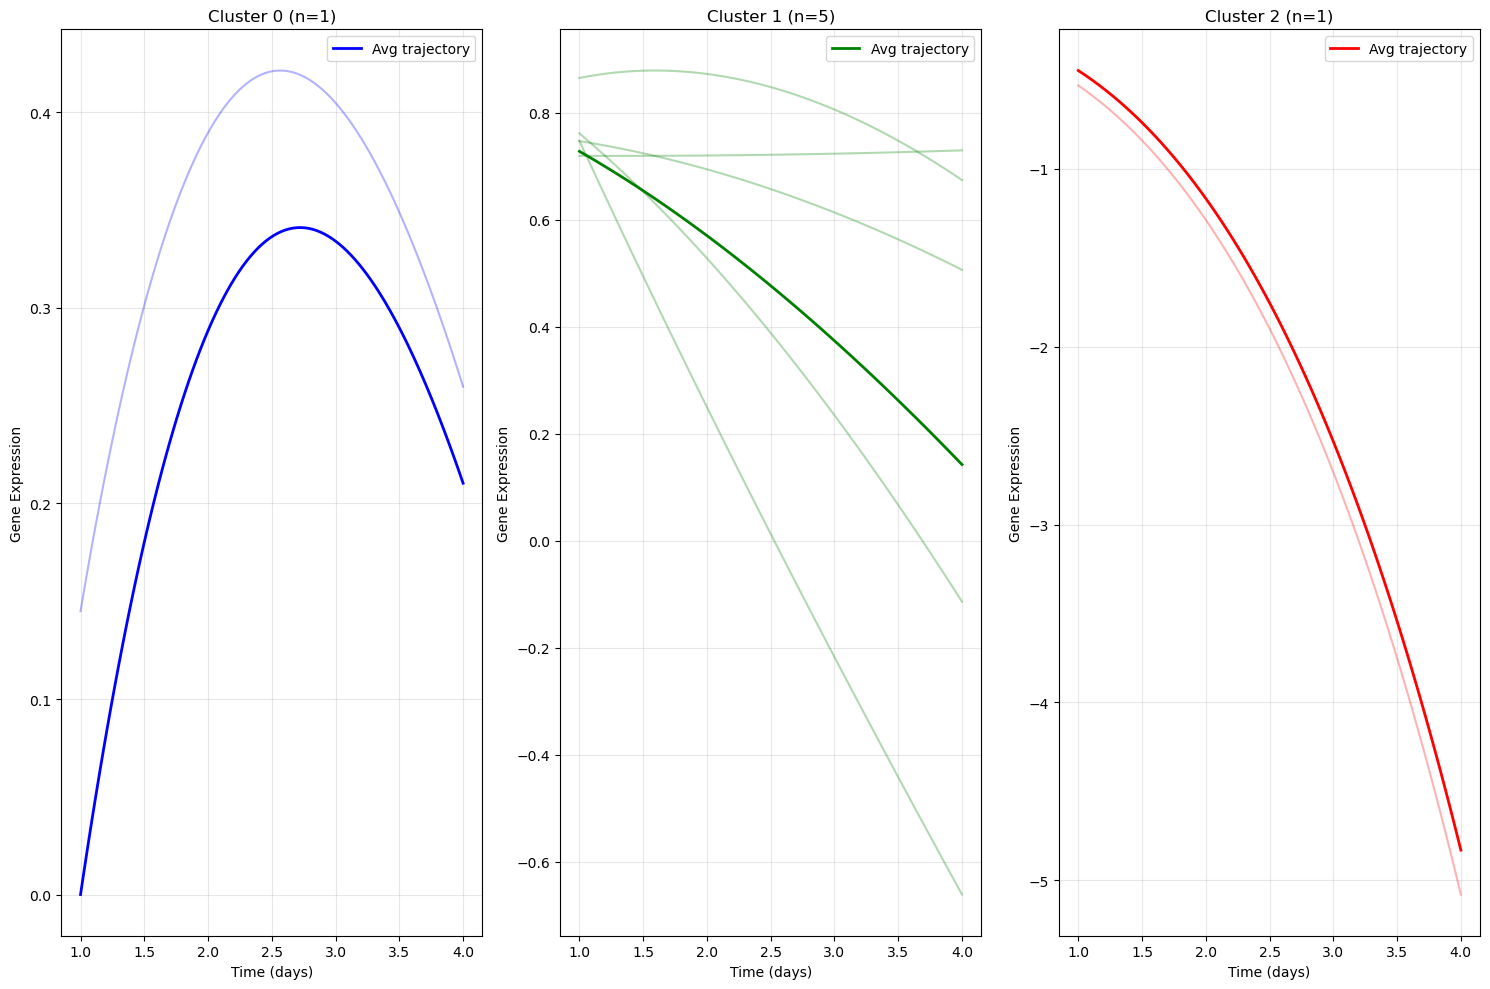

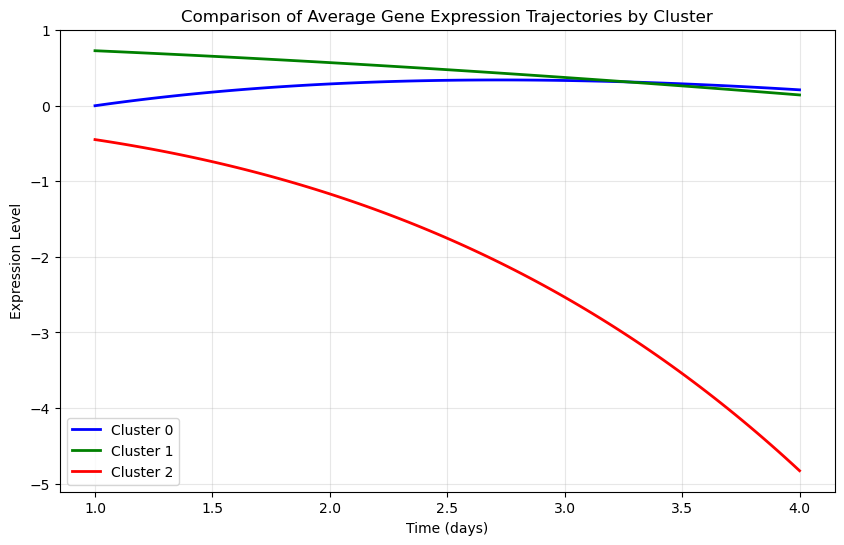


Cluster Parameter Summary:
Cluster   Count     Alpha (α)      Beta (β)       Gamma (γ)      
--------------------------------------------------
0         1         0.6269         -0.3589        -0.1854        
1         5         0.0042         -0.1124        -0.0589        
2         1         -0.0296        0.3638         -0.2747        


In [9]:
# =============================================================================
# 6. Testing on New Data - For All Clusters
# =============================================================================
# (a) Using some test data that falls in the same clusters as the training set.
noise = 0.05 * torch.randn_like(gene_data_tensor)
test_data = gene_data_tensor + noise
x0_test = test_data[:, 0].unsqueeze(1)

# Calculate test loss using all individual models
test_losses = []
for i in range(num_genes):
    pred_traj = odeint(ode_models[i], x0_test[i], time_points_tensor)
    test_loss = torch.mean((pred_traj.squeeze() - test_data[i])**2).item()
    test_losses.append(test_loss)

avg_test_loss = np.mean(test_losses)
print(f"Average Test MSE on perturbed data: {avg_test_loss:.6f}")

# (b) Generate synthetic test data for all clusters
t_synth = torch.linspace(1, 4, steps=100)
cluster_avg_params = []
cluster_avg_trajs = []

plt.figure(figsize=(15, 10))

# Process each cluster
for cluster_id in range(3):  # For all 3 clusters
    indices = np.where(clusters == cluster_id)[0]
    print(f"Number of genes in cluster {cluster_id}: {len(indices)}")
    
    if len(indices) > 0:
        # Extract parameters from models in this cluster
        synth_alphas = torch.tensor([ode_models[i].alpha.item() for i in indices])
        synth_betas = torch.tensor([ode_models[i].beta.item() for i in indices])
        synth_gammas = torch.tensor([ode_models[i].gamma.item() for i in indices])
        
        # Average params for this cluster
        avg_alpha = torch.mean(synth_alphas).item()
        avg_beta = torch.mean(synth_betas).item()
        avg_gamma = torch.mean(synth_gammas).item()
        cluster_avg_params.append((avg_alpha, avg_beta, avg_gamma))
        
        print(f"Cluster {cluster_id} average parameters:")
        print(f"  α = {avg_alpha:.4f}, β = {avg_beta:.4f}, γ = {avg_gamma:.4f}")
        
        # Use first time point as initial condition
        x0 = gene_data_tensor[:, 0]
        avg_x0 = torch.mean(x0[indices])
        synth_x0 = avg_x0 + 0.1 * torch.randn(len(indices), 1)
        
        # Synthetic ODE function
        def synth_ode_func(t, x, params):
            alpha, beta, gamma = params
            return alpha + beta * x + gamma * t
        
        # Generate individual trajectories for this cluster
        synth_trajs = []
        for i in range(len(indices)):
            params_i = (synth_alphas[i].unsqueeze(0), 
                        synth_betas[i].unsqueeze(0), 
                        synth_gammas[i].unsqueeze(0))
            traj = odeint(lambda t, x: synth_ode_func(t, x, params_i),
                          synth_x0[i].unsqueeze(0), t_synth)
            synth_trajs.append(traj.squeeze().detach().numpy())
        
        # Plot individual trajectories with corresponding cluster color
        plt.subplot(1, 3, cluster_id + 1)
        colors = ['blue', 'green', 'red']
        for traj in synth_trajs:
            plt.plot(t_synth.numpy(), traj, color=colors[cluster_id], alpha=0.3)
        
        # Calculate and plot average trajectory
        avg_params = (torch.tensor([avg_alpha]).unsqueeze(0),
                      torch.tensor([avg_beta]).unsqueeze(0),
                      torch.tensor([avg_gamma]).unsqueeze(0))
        avg_traj = odeint(lambda t, x: synth_ode_func(t, x, avg_params),
                          torch.tensor([[avg_x0]]), t_synth)
        avg_traj_np = avg_traj.squeeze().detach().numpy()
        cluster_avg_trajs.append(avg_traj_np)
        
        # Plot average trajectory with bold line
        plt.plot(t_synth.numpy(), avg_traj_np, color=colors[cluster_id], 
                 linewidth=2, label=f"Avg trajectory")
        
        plt.title(f"Cluster {cluster_id} (n={len(indices)})")
        plt.xlabel("Time (days)")
        plt.ylabel("Gene Expression")
        plt.grid(True, alpha=0.3)
        plt.legend()

plt.tight_layout()
plt.show()

# Compare all cluster average trajectories in one plot
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red']
labels = [f"Cluster {i}" for i in range(3)]

for i, avg_traj in enumerate(cluster_avg_trajs):
    plt.plot(t_synth.numpy(), avg_traj, color=colors[i], linewidth=2, label=labels[i])

plt.title("Comparison of Average Gene Expression Trajectories by Cluster")
plt.xlabel("Time (days)")
plt.ylabel("Expression Level")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print a summary table of cluster parameters
print("\nCluster Parameter Summary:")
print("="*50)
print(f"{'Cluster':<10}{'Count':<10}{'Alpha (α)':<15}{'Beta (β)':<15}{'Gamma (γ)':<15}")
print("-"*50)
for cluster_id in range(3):
    indices = np.where(clusters == cluster_id)[0]
    if len(indices) > 0:
        alpha, beta, gamma = cluster_avg_params[cluster_id]
        print(f"{cluster_id:<10}{len(indices):<10}{alpha:<15.4f}{beta:<15.4f}{gamma:<15.4f}")
print("="*50)

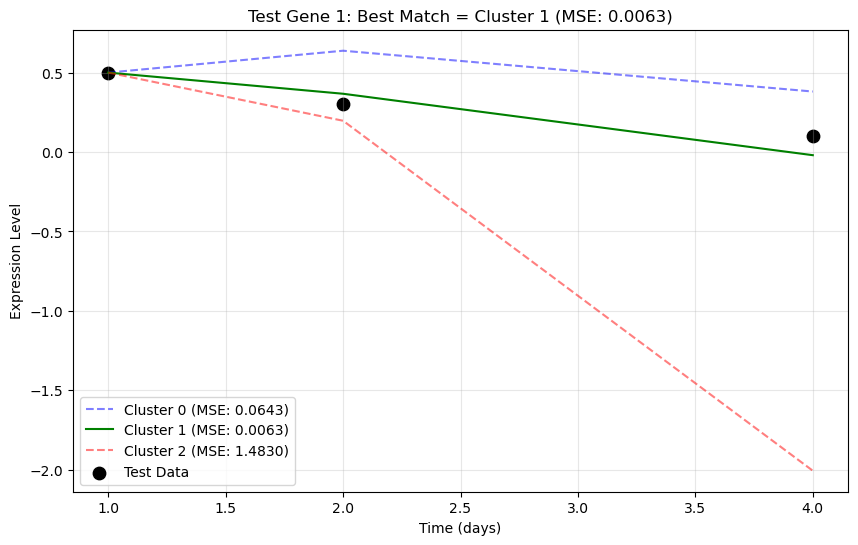

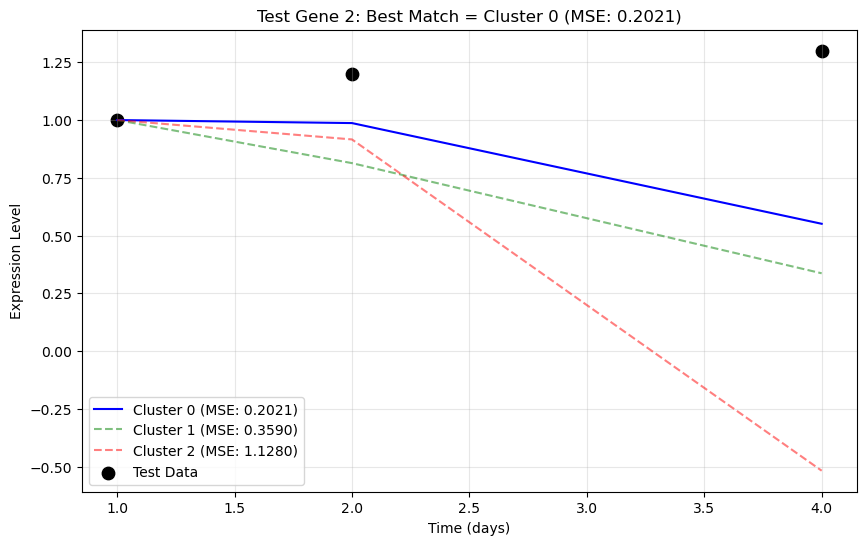

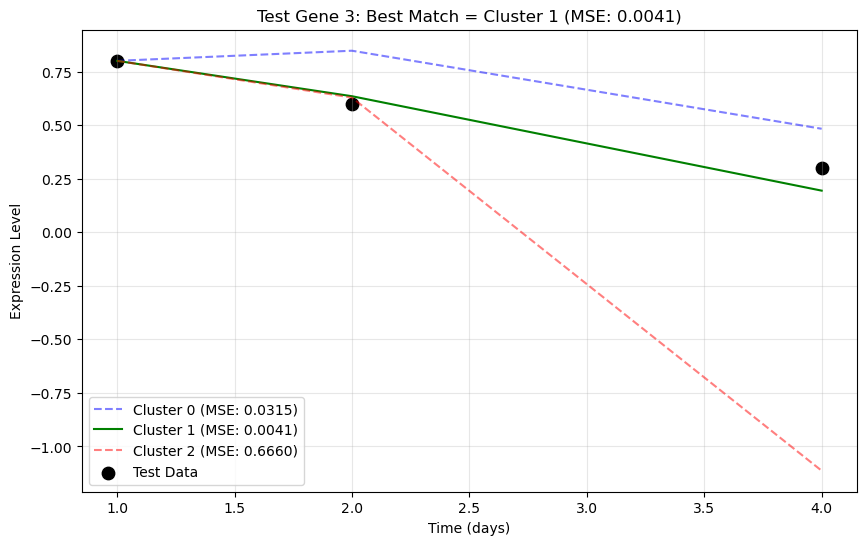

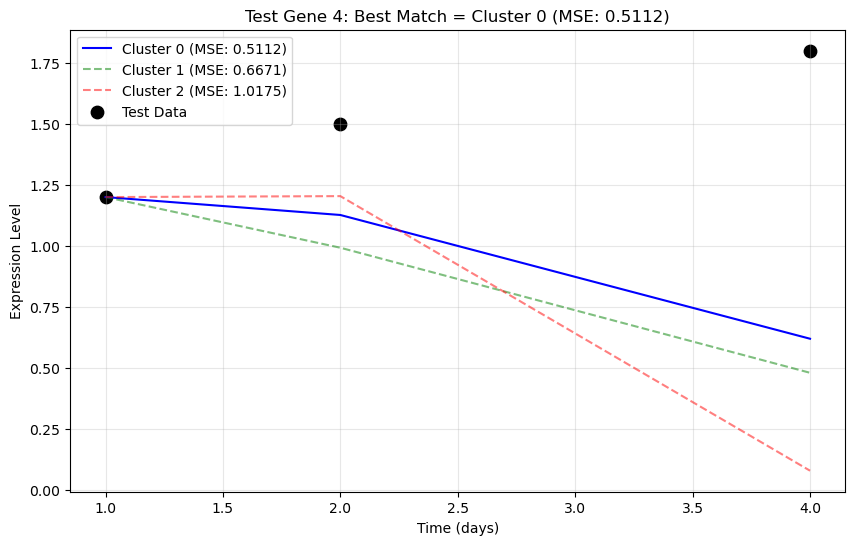

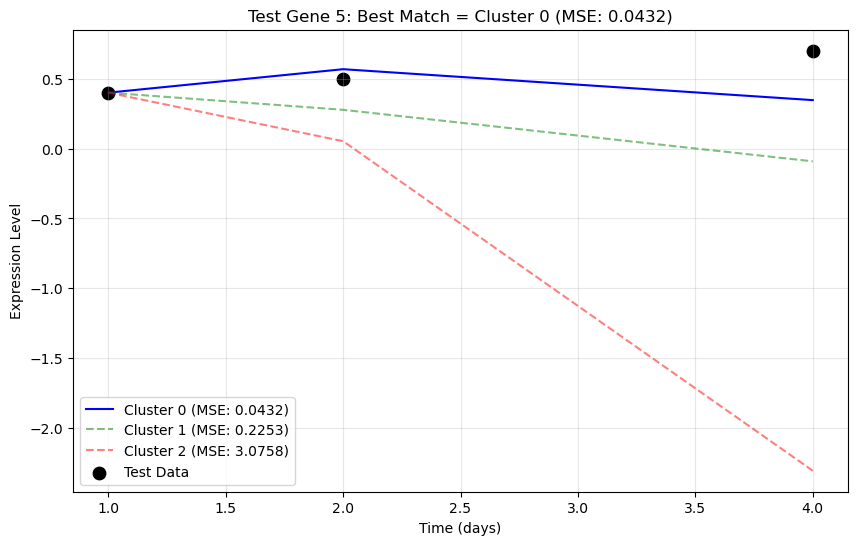


Test Results Summary:
Test Gene   Initial Value  Best Cluster   MSE       All Errors
----------------------------------------------------------------------
1           0.50           1              0.0063    C0:0.0643, C1:0.0063, C2:1.4830
2           1.00           0              0.2021    C0:0.2021, C1:0.3590, C2:1.1280
3           0.80           1              0.0041    C0:0.0315, C1:0.0041, C2:0.6660
4           1.20           0              0.5112    C0:0.5112, C1:0.6671, C2:1.0175
5           0.40           0              0.0432    C0:0.0432, C1:0.2253, C2:3.0758


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [10]:
##############################################################################
# 7. PREDICT UNSEEN GENE TRAJECTORIES USING CLUSTER PARAMETERS
##############################################################################
# Create a synthetic test dataset (each row is: [Day1, Day2, Day4])
test_data = np.array([
    [0.5, 0.3, 0.1],   # Potentially matches cluster 0
    [1.0, 1.2, 1.3],   # Potentially matches cluster 1
    [0.8, 0.6, 0.3],   # Test example 3
    [1.2, 1.5, 1.8],   # Test example 4
    [0.4, 0.5, 0.7]    # Test example 5
], dtype=np.float32)

# Use either the kmeans cluster centers (from scaled data) or compute directly
if 'cluster_avg_params' not in locals():
    # If we haven't already computed cluster_avg_params above, compute them
    cluster_avg_params = []
    for cluster_id in range(3):
        indices = np.where(clusters == cluster_id)[0]
        if len(indices) > 0:
            avg_alpha = np.mean([ode_models[i].alpha.item() for i in indices])
            avg_beta = np.mean([ode_models[i].beta.item() for i in indices])
            avg_gamma = np.mean([ode_models[i].gamma.item() for i in indices])
            cluster_avg_params.append((avg_alpha, avg_beta, avg_gamma))
        else:
            cluster_avg_params.append((0.0, 0.0, 0.0))  # Fallback if empty cluster

def predict_with_cluster_params(cluster_params, time_points, y0):
    """Predict using the [alpha, beta, gamma] parameters of a cluster."""
    alpha, beta, gamma = cluster_params
    
    class ClusterODE(nn.Module):
        def forward(self, t, y):
            return alpha + beta * y + gamma * t

    cluster_model = ClusterODE()
    preds = odeint(cluster_model, y0, time_points).squeeze().numpy()
    return preds

def compute_prediction_error(predictions, actual):
    """Compute mean squared error between predictions and actual values."""
    return np.mean((predictions - actual)**2)

# Results table
results = []

# For each test example, predict with each cluster and find the best match
with torch.no_grad():
    for idx, row in enumerate(test_data):
        # Use Day1 as initial condition
        y0 = torch.tensor([row[0]], dtype=torch.float32)
        
        # Try each cluster and compute error
        errors = []
        predictions = []
        
        for cluster_id in range(len(cluster_avg_params)):
            cluster_preds = predict_with_cluster_params(
                cluster_avg_params[cluster_id], 
                time_points_tensor, 
                y0
            )
            error = compute_prediction_error(cluster_preds, row)
            errors.append(error)
            predictions.append(cluster_preds)
        
        # Find best cluster (lowest error)
        best_cluster = np.argmin(errors)
        best_error = errors[best_cluster]
        best_preds = predictions[best_cluster]
        
        # Store results
        results.append({
            'test_idx': idx,
            'initial_value': row[0],
            'best_cluster': best_cluster,
            'error': best_error,
            'errors_by_cluster': errors
        })
        
        # Plot test data vs. best cluster prediction
        plt.figure(figsize=(10, 6))
        
        # Plot predictions from all clusters
        colors = ['blue', 'green', 'red']
        for c_id, preds in enumerate(predictions):
            linestyle = '-' if c_id == best_cluster else '--'
            alpha = 1.0 if c_id == best_cluster else 0.5
            plt.plot(time_points, preds, 
                     color=colors[c_id], 
                     linestyle=linestyle,
                     alpha=alpha,
                     label=f"Cluster {c_id} (MSE: {errors[c_id]:.4f})")
        
        # Plot test data points
        plt.scatter(time_points, row, c='black', s=80, label="Test Data")
        
        plt.title(f"Test Gene {idx+1}: Best Match = Cluster {best_cluster} (MSE: {best_error:.4f})")
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

# Print summary table of results
print("\nTest Results Summary:")
print("="*70)
print(f"{'Test Gene':<12}{'Initial Value':<15}{'Best Cluster':<15}{'MSE':<10}{'All Errors'}")
print("-"*70)
for res in results:
    errors_str = ", ".join([f"C{i}:{err:.4f}" for i, err in enumerate(res['errors_by_cluster'])])
    print(f"{res['test_idx']+1:<12}{res['initial_value']:<15.2f}{res['best_cluster']:<15}{res['error']:<10.4f}{errors_str}")
print("="*70)

# Visualize cluster assignments of test genes alongside training genes
plt.figure(figsize=(10, 6))


Learned Parameters:
        Gene     alpha      beta     gamma
0  AT5G40100 -0.029587  0.363788 -0.274705
1  AT1G06930 -0.200648 -0.281768 -0.104929
2  AT1G04470  0.626873 -0.358907 -0.185361
3  AT5G66730  0.031551 -0.051446 -0.031368
4  AT2G38472 -0.051423 -0.087976 -0.083190
5  AT2G38474  0.233312 -0.124592 -0.077811
6  AT2G38470  0.008094 -0.016265  0.002823


c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


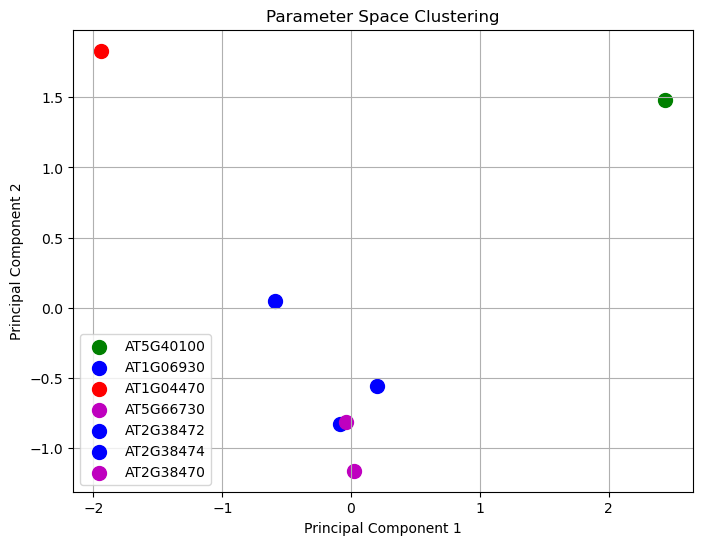


Cluster Analysis:

Cluster 0 - Genes:
AT1G04470
Parameter Statistics:
Alpha: μ = 0.6269 ± nan
Beta:  μ = -0.3589 ± nan
Gamma: μ = -0.1854 ± nan

Cluster 1 - Genes:
AT1G06930, AT2G38472, AT2G38474
Parameter Statistics:
Alpha: μ = -0.0063 ± 0.2205
Beta:  μ = -0.1648 ± 0.1030
Gamma: μ = -0.0886 ± 0.0144

Cluster 2 - Genes:
AT5G40100
Parameter Statistics:
Alpha: μ = -0.0296 ± nan
Beta:  μ = 0.3638 ± nan
Gamma: μ = -0.2747 ± nan

Cluster 3 - Genes:
AT5G66730, AT2G38470
Parameter Statistics:
Alpha: μ = 0.0198 ± 0.0166
Beta:  μ = -0.0339 ± 0.0249
Gamma: μ = -0.0143 ± 0.0242

Parameters saved to gene_ode_parameters.csv


In [11]:
##############################################################################
# Step 1: Store and Print Learned Parameters
##############################################################################

# Create a DataFrame to store parameters
params_df = pd.DataFrame(columns=['Gene', 'alpha', 'beta', 'gamma'])

with torch.no_grad():
    for i, gene_id in enumerate(df['Unnamed: 0']):
        model = ode_models[i]
        params_df.loc[i] = [
            gene_id,
            model.alpha.item(),
            model.beta.item(),
            model.gamma.item()
        ]

print("\nLearned Parameters:")
print(params_df)

##############################################################################
# Step 2: Parameter Clustering using K-means
##############################################################################

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Prepare data for clustering
X = params_df[['alpha', 'beta', 'gamma']].values

# Normalize parameters
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add clusters to DataFrame
params_df['cluster'] = clusters

##############################################################################
# Step 3: Visualize Clusters with PCA
##############################################################################

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Create plot
plt.figure(figsize=(8, 6))
colors = ['r', 'b', 'g', 'm', 'y']
markers = ['o', 's', 'D', '^', 'v']

for i, gene in enumerate(params_df['Gene']):
    plt.scatter(
        principal_components[i, 0],
        principal_components[i, 1],
        c=colors[clusters[i]],
        # marker=markers[i],
        s=100,
        label=gene
    )

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Parameter Space Clustering')
plt.legend()
plt.grid(True)
plt.show()

##############################################################################
# Step 4: Cluster Analysis
##############################################################################

print("\nCluster Analysis:")
for cluster_id in sorted(params_df['cluster'].unique()):
    cluster_data = params_df[params_df['cluster'] == cluster_id]

    print(f"\nCluster {cluster_id} - Genes:")
    print(", ".join(cluster_data['Gene'].values))

    print("Parameter Statistics:")
    print(f"Alpha: μ = {cluster_data['alpha'].mean():.4f} ± {cluster_data['alpha'].std():.4f}")
    print(f"Beta:  μ = {cluster_data['beta'].mean():.4f} ± {cluster_data['beta'].std():.4f}")
    print(f"Gamma: μ = {cluster_data['gamma'].mean():.4f} ± {cluster_data['gamma'].std():.4f}")

##############################################################################
# Step 5: Save Parameters to CSV
##############################################################################

params_df.to_csv('gene_ode_parameters.csv', index=False)
print("\nParameters saved to gene_ode_parameters.csv")

c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


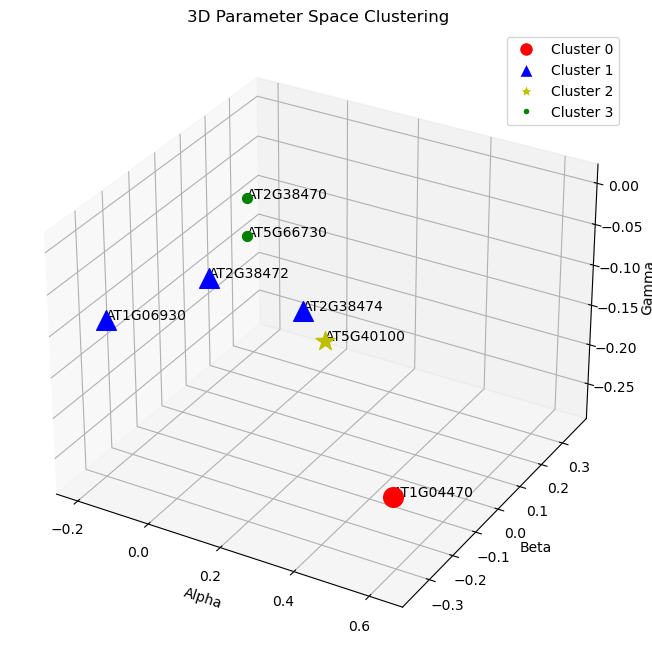

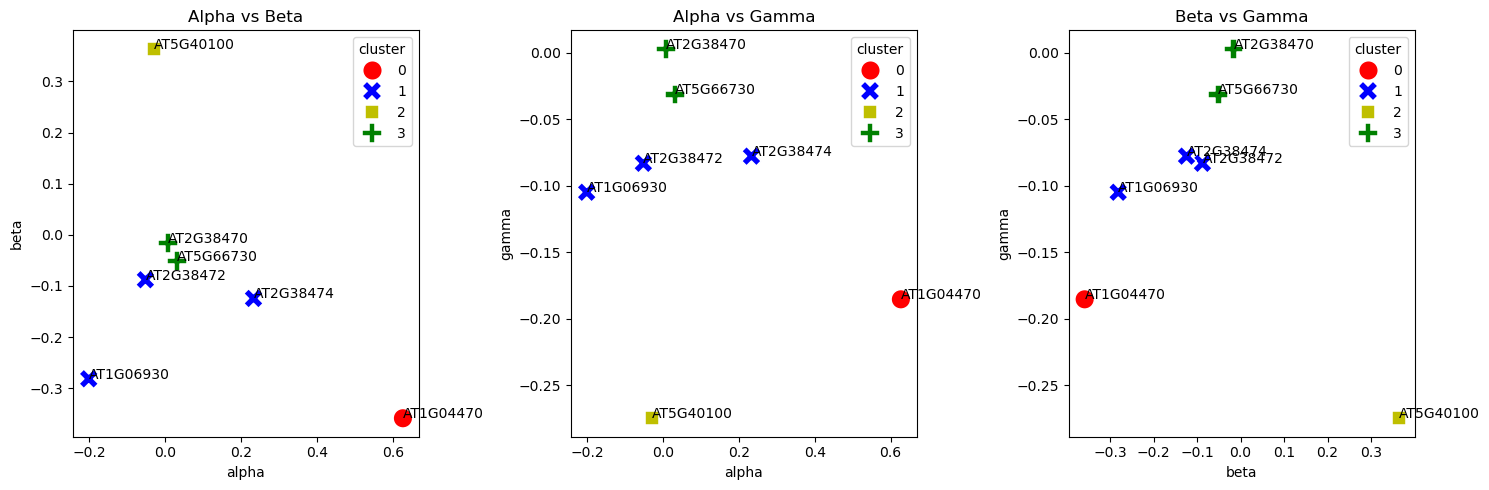


Cluster Characteristics:

Cluster 0 (1 genes):
Genes: AT1G04470
Alpha: μ = 0.6269 ± nan
Beta:  μ = -0.3589 ± nan
Gamma: μ = -0.1854 ± nan

Cluster 1 (3 genes):
Genes: AT1G06930, AT2G38472, AT2G38474
Alpha: μ = -0.0063 ± 0.2205
Beta:  μ = -0.1648 ± 0.1030
Gamma: μ = -0.0886 ± 0.0144

Cluster 2 (1 genes):
Genes: AT5G40100
Alpha: μ = -0.0296 ± nan
Beta:  μ = 0.3638 ± nan
Gamma: μ = -0.2747 ± nan

Cluster 3 (2 genes):
Genes: AT5G66730, AT2G38470
Alpha: μ = 0.0198 ± 0.0166
Beta:  μ = -0.0339 ± 0.0249
Gamma: μ = -0.0143 ± 0.0242


In [12]:
##############################################################################
# Parameter Clustering and Visualization
##############################################################################

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Create a DataFrame with learned parameters
params = []
for i, gene_id in enumerate(df['Unnamed: 0']):
    model = ode_models[i]
    params.append({
        'Gene': gene_id,
        'alpha': model.alpha.item(),
        'beta': model.beta.item(),
        'gamma': model.gamma.item()
    })
params_df = pd.DataFrame(params)

# Normalize parameters for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(params_df[['alpha', 'beta', 'gamma']])

# Perform K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
params_df['cluster'] = kmeans.fit_predict(X_scaled)

##############################################################################
# 3D Parameter Space Visualization
##############################################################################

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Assign colors and markers based on clusters
# colors = ['r', 'b']
# markers = ['o', '^']

colors = ['r', 'b', 'y', 'g']
markers = ['o', '^', '*', '.']
for idx, row in params_df.iterrows():
    ax.scatter(
        row['alpha'],
        row['beta'],
        row['gamma'],
        c=colors[row['cluster']],
        marker=markers[row['cluster']],
        s=200,
        label=row['Gene'] if idx == 0 else ""
    )

ax.set_xlabel('Alpha')
ax.set_ylabel('Beta')
ax.set_zlabel('Gamma')
ax.set_title('3D Parameter Space Clustering')

# Add gene labels
for idx, row in params_df.iterrows():
    ax.text(row['alpha'], row['beta'], row['gamma'], row['Gene'],
            size=10, zorder=1, color='k')

plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10, label='Cluster 0'),
    plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='b', markersize=10, label='Cluster 1'),
    plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='y', markersize=10, label='Cluster 2'),
    plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='g', markersize=10, label='Cluster 3')

])
plt.show()

##############################################################################
# Pairwise Parameter Visualization
##############################################################################

import seaborn as sns

# Create pair plots
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(data=params_df, x='alpha', y='beta', hue='cluster',
                style='cluster', s=200, palette=['r', 'b', 'y', 'g'])
plt.title('Alpha vs Beta')
for line in range(0, params_df.shape[0]):
    plt.text(params_df.alpha[line], params_df.beta[line], params_df.Gene[line])

plt.subplot(1, 3, 2)
sns.scatterplot(data=params_df, x='alpha', y='gamma', hue='cluster',
                style='cluster', s=200, palette=['r', 'b', 'y', 'g'])
plt.title('Alpha vs Gamma')
for line in range(0, params_df.shape[0]):
    plt.text(params_df.alpha[line], params_df.gamma[line], params_df.Gene[line])

plt.subplot(1, 3, 3)
sns.scatterplot(data=params_df, x='beta', y='gamma', hue='cluster',
                style='cluster', s=200, palette=['r', 'b', 'y', 'g'])
plt.title('Beta vs Gamma')
for line in range(0, params_df.shape[0]):
    plt.text(params_df.beta[line], params_df.gamma[line], params_df.Gene[line])

plt.tight_layout()
plt.show()

##############################################################################
# Cluster Analysis
##############################################################################

print("\nCluster Characteristics:")
for cluster in sorted(params_df.cluster.unique()):
    cluster_data = params_df[params_df.cluster == cluster]
    print(f"\nCluster {cluster} ({len(cluster_data)} genes):")
    print("Genes:", ", ".join(cluster_data.Gene.values))
    print(f"Alpha: μ = {cluster_data.alpha.mean():.4f} ± {cluster_data.alpha.std():.4f}")
    print(f"Beta:  μ = {cluster_data.beta.mean():.4f} ± {cluster_data.beta.std():.4f}")
    print(f"Gamma: μ = {cluster_data.gamma.mean():.4f} ± {cluster_data.gamma.std():.4f}")


Learned Parameters:
        Gene     alpha      beta     gamma
0  AT5G40100 -0.029587  0.363788 -0.274705
1  AT1G06930 -0.200648 -0.281768 -0.104929
2  AT1G04470  0.626873 -0.358907 -0.185361
3  AT5G66730  0.031551 -0.051446 -0.031368
4  AT2G38472 -0.051423 -0.087976 -0.083190
5  AT2G38474  0.233312 -0.124592 -0.077811
6  AT2G38470  0.008094 -0.016265  0.002823


c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


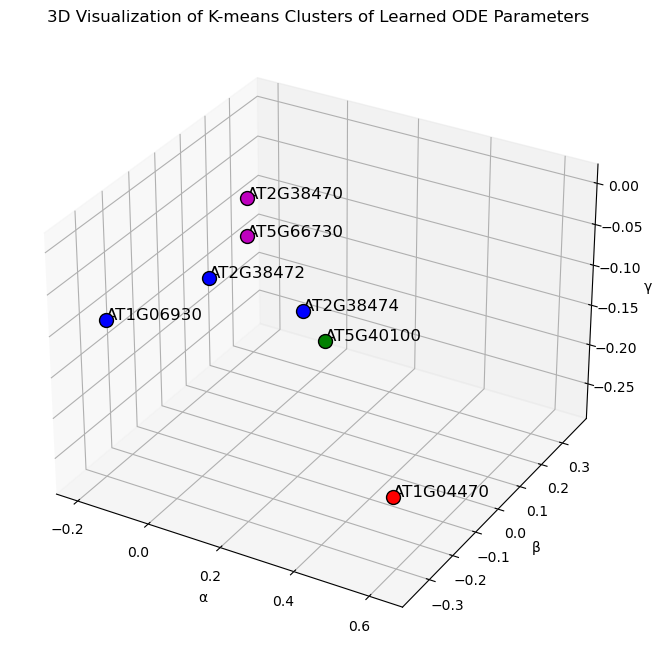


Cluster Analysis:

Cluster 0 - Genes:
AT1G04470
Parameter Statistics:
Alpha: μ = 0.6269 ± nan
Beta:  μ = -0.3589 ± nan
Gamma: μ = -0.1854 ± nan

Cluster 1 - Genes:
AT1G06930, AT2G38472, AT2G38474
Parameter Statistics:
Alpha: μ = -0.0063 ± 0.2205
Beta:  μ = -0.1648 ± 0.1030
Gamma: μ = -0.0886 ± 0.0144

Cluster 2 - Genes:
AT5G40100
Parameter Statistics:
Alpha: μ = -0.0296 ± nan
Beta:  μ = 0.3638 ± nan
Gamma: μ = -0.2747 ± nan

Cluster 3 - Genes:
AT5G66730, AT2G38470
Parameter Statistics:
Alpha: μ = 0.0198 ± 0.0166
Beta:  μ = -0.0339 ± 0.0249
Gamma: μ = -0.0143 ± 0.0242

Parameters saved to gene_ode_parameters.csv


In [13]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

##############################################################################
# Step 1: Store and Print Learned Parameters
##############################################################################

# Assume ode_models is already trained and available from previous steps.
# Create a DataFrame to store parameters
params_df = pd.DataFrame(columns=['Gene', 'alpha', 'beta', 'gamma'])

with torch.no_grad():
    for i, gene_id in enumerate(df['Unnamed: 0']):
        model = ode_models[i]
        params_df.loc[i] = [
            gene_id,
            model.alpha.item(),
            model.beta.item(),
            model.gamma.item()
        ]

print("\nLearned Parameters:")
print(params_df)

##############################################################################
# Step 2: Parameter Clustering using K-means
##############################################################################

from sklearn.preprocessing import StandardScaler

# Prepare data for clustering
X = params_df[['alpha', 'beta', 'gamma']].values

# Normalize parameters
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add clusters to DataFrame
params_df['cluster'] = clusters

##############################################################################
# Step 3: Visualize Clusters in 3D (without PCA)
##############################################################################

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Define a list of colors to use for clusters
colors = ['r', 'b', 'g', 'm', 'y']

for idx, row in params_df.iterrows():
    ax.scatter(row['alpha'], row['beta'], row['gamma'],
               color=colors[row['cluster'] % len(colors)],
               s=100, edgecolor='k')
    ax.text(row['alpha'], row['beta'], row['gamma'], row['Gene'],
            size=12, zorder=1, color='k')

ax.set_xlabel('α')
ax.set_ylabel('β')
ax.set_zlabel('γ')
ax.set_title('3D Visualization of K-means Clusters of Learned ODE Parameters')
plt.show()

##############################################################################
# Step 4: Cluster Analysis
##############################################################################

print("\nCluster Analysis:")
for cluster_id in sorted(params_df['cluster'].unique()):
    cluster_data = params_df[params_df['cluster'] == cluster_id]

    print(f"\nCluster {cluster_id} - Genes:")
    print(", ".join(cluster_data['Gene'].values))

    print("Parameter Statistics:")
    print(f"Alpha: μ = {cluster_data['alpha'].mean():.4f} ± {cluster_data['alpha'].std():.4f}")
    print(f"Beta:  μ = {cluster_data['beta'].mean():.4f} ± {cluster_data['beta'].std():.4f}")
    print(f"Gamma: μ = {cluster_data['gamma'].mean():.4f} ± {cluster_data['gamma'].std():.4f}")

##############################################################################
# Step 5: Save Parameters to CSV
##############################################################################

params_df.to_csv('gene_ode_parameters.csv', index=False)
print("\nParameters saved to gene_ode_parameters.csv")


In [14]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

# Generate synthetic test data
test_data = {
    "Unnamed: 0": ["AT5G40101", "AT1G06930", "AT1G04470", "AT5G66730", "AT2G38471"],
    "Hpa-NO_1d": [-0.5, 1.8, 0.1, 0.05, 0.5],
    "Hpa-NO_2d": [-0.6, 0.1, 1.2, 0.1, 0.8],
    "Hpa-NO_4d": [-5.1, 0.1, 0.1, -0.1, 0.5],
}

test_df = pd.DataFrame(test_data)
print("Test Data:")
print(test_df)


Test Data:
  Unnamed: 0  Hpa-NO_1d  Hpa-NO_2d  Hpa-NO_4d
0  AT5G40101      -0.50       -0.6       -5.1
1  AT1G06930       1.80        0.1        0.1
2  AT1G04470       0.10        1.2        0.1
3  AT5G66730       0.05        0.1       -0.1
4  AT2G38471       0.50        0.8        0.5


In [15]:

# Extract gene expression data from test data
test_gene_data = test_df[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values
print(test_gene_data)
# Convert to PyTorch tensors
test_gene_data_tensor = torch.tensor(test_gene_data, dtype=torch.float32)


[[-0.5  -0.6  -5.1 ]
 [ 1.8   0.1   0.1 ]
 [ 0.1   1.2   0.1 ]
 [ 0.05  0.1  -0.1 ]
 [ 0.5   0.8   0.5 ]]


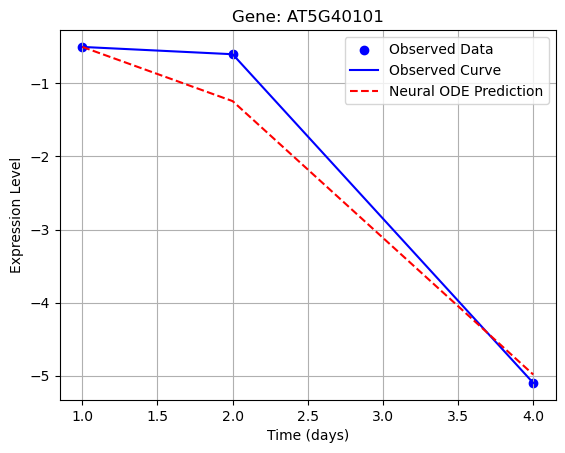

Learned ODE for Gene AT5G40101:
  dy/dt = -0.0296 + 0.3638 * y + -0.2747 * t
Formatted ODE Equation: dy/dt = -0.0296 + 0.3638 * y(t) + -0.2747 * t



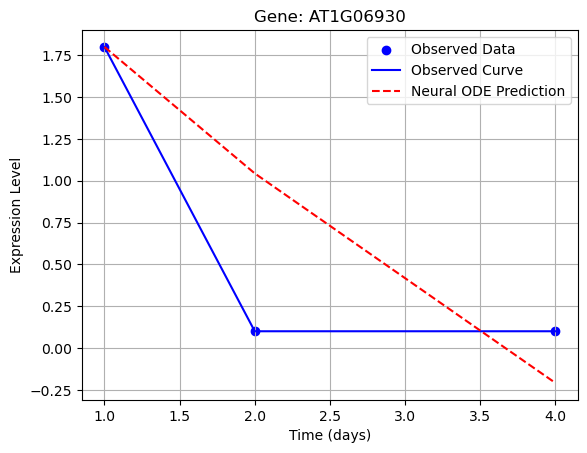

Learned ODE for Gene AT1G06930:
  dy/dt = -0.2006 + -0.2818 * y + -0.1049 * t
Formatted ODE Equation: dy/dt = -0.2006 + -0.2818 * y(t) + -0.1049 * t



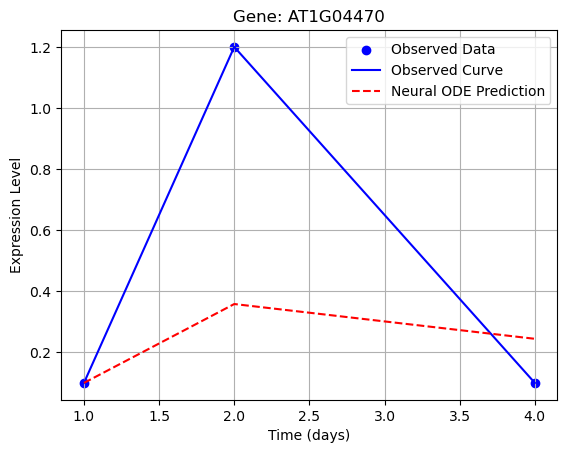

Learned ODE for Gene AT1G04470:
  dy/dt = 0.6269 + -0.3589 * y + -0.1854 * t
Formatted ODE Equation: dy/dt = 0.6269 + -0.3589 * y(t) + -0.1854 * t



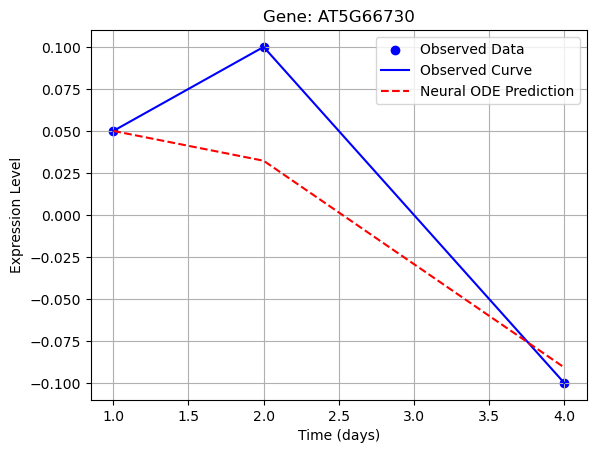

Learned ODE for Gene AT5G66730:
  dy/dt = 0.0316 + -0.0514 * y + -0.0314 * t
Formatted ODE Equation: dy/dt = 0.0316 + -0.0514 * y(t) + -0.0314 * t



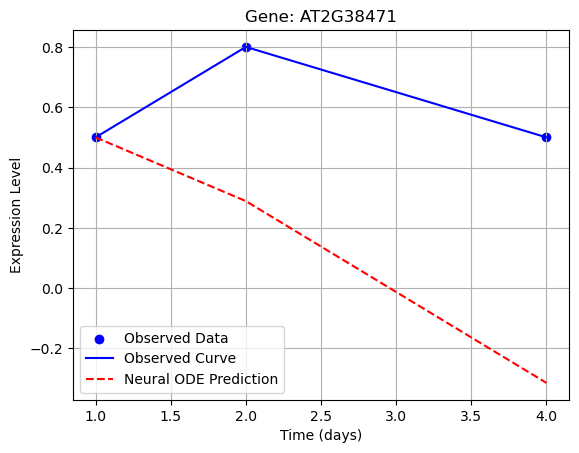

Learned ODE for Gene AT2G38471:
  dy/dt = -0.0514 + -0.0880 * y + -0.0832 * t
Formatted ODE Equation: dy/dt = -0.0514 + -0.0880 * y(t) + -0.0832 * t



In [16]:

# Use the trained model to make predictions on the test data
with torch.no_grad():
    for i, gene_id in enumerate(test_df['Unnamed: 0']):
        # Use the Day1 value as the initial condition for each gene
        y0 = test_gene_data_tensor[i, 0].unsqueeze(0)  # shape: (1,)
        preds = odeint(ode_models[i], y0, time_points_tensor).squeeze().numpy()

        # Plot observed data vs. Neural ODE predictions
        plt.figure()
        plt.scatter(time_points, test_gene_data[i], c='b', label="Observed Data")
        plt.plot(time_points, test_gene_data[i], 'b-', label="Observed Curve")
        plt.plot(time_points, preds, 'r--', label="Neural ODE Prediction")
        plt.title(f"Gene: {gene_id}")
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Print learned parameters for the gene
        model = ode_models[i]
        alpha = model.alpha.item()
        beta = model.beta.item()
        gamma = model.gamma.item()
        print(f"Learned ODE for Gene {gene_id}:")
        print(f"  dy/dt = {alpha:.4f} + {beta:.4f} * y + {gamma:.4f} * t")
        print(f"Formatted ODE Equation: dy/dt = {alpha:.4f} + {beta:.4f} * y(t) + {gamma:.4f} * t\n")

In [17]:

##############################################################################
# Step 4: Parameter Clustering
##############################################################################

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Collect parameters
params = []
for model in ode_models:
    params.append([
        model.alpha.item(),
        model.beta.item(),
        model.gamma.item()
    ])
params = np.array(params)

# Normalize parameters
scaler = StandardScaler()
scaled_params = scaler.fit_transform(params)

# Cluster using K-means
kmeans = KMeans(n_clusters=2, random_state=0).fit(scaled_params)
cluster_labels = kmeans.labels_

# PCA for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_params)



c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


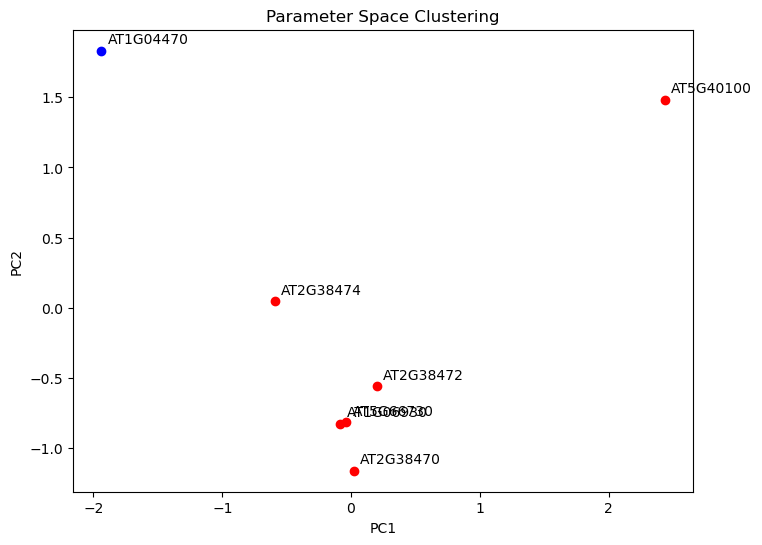


Cluster Analysis:

Cluster 0 Genes:
AT5G40100, AT1G06930, AT5G66730, AT2G38472, AT2G38474, AT2G38470
Average Parameters:
α: -0.0014 ± 0.1286
β: -0.0330 ± 0.1964
γ: -0.0949 ± 0.0880

Cluster 1 Genes:
AT1G04470
Average Parameters:
α: 0.6269 ± 0.0000
β: -0.3589 ± 0.0000
γ: -0.1854 ± 0.0000


In [18]:
# Plot clusters
plt.figure(figsize=(8, 6))
for i, gene in enumerate(df['Unnamed: 0']):
    plt.scatter(principal_components[i, 0], principal_components[i, 1],
                c=['r', 'b'][cluster_labels[i]], label=gene)
    plt.text(principal_components[i, 0]+0.05, principal_components[i, 1]+0.05, gene)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Parameter Space Clustering')
plt.show()

##############################################################################
# Step 5: Print Cluster Analysis
##############################################################################

print("\nCluster Analysis:")
for cluster_id in np.unique(cluster_labels):
    cluster_genes = df['Unnamed: 0'][cluster_labels == cluster_id]
    print(f"\nCluster {cluster_id} Genes:")
    print(", ".join(cluster_genes))

    cluster_params = params[cluster_labels == cluster_id]
    print(f"Average Parameters:")
    print(f"α: {cluster_params[:, 0].mean():.4f} ± {cluster_params[:, 0].std():.4f}")
    print(f"β: {cluster_params[:, 1].mean():.4f} ± {cluster_params[:, 1].std():.4f}")
    print(f"γ: {cluster_params[:, 2].mean():.4f} ± {cluster_params[:, 2].std():.4f}")

In [19]:
# Store learned parameters in a DataFrame
params = []
for i, gene_id in enumerate(df['Unnamed: 0']):
    model = ode_models[i]
    params.append({
        'Unnamed: 0': gene_id,
        'alpha': model.alpha.item(),
        'beta': model.beta.item(),
        'gamma': model.gamma.item()
    })
params_df = pd.DataFrame(params)

print("\nLearned Parameters:")
print(params_df)


Learned Parameters:
  Unnamed: 0     alpha      beta     gamma
0  AT5G40100 -0.029587  0.363788 -0.274705
1  AT1G06930 -0.200648 -0.281768 -0.104929
2  AT1G04470  0.626873 -0.358907 -0.185361
3  AT5G66730  0.031551 -0.051446 -0.031368
4  AT2G38472 -0.051423 -0.087976 -0.083190
5  AT2G38474  0.233312 -0.124592 -0.077811
6  AT2G38470  0.008094 -0.016265  0.002823


In [20]:
from sklearn.cluster import KMeans

# Number of clusters for each parameter
n_clusters = 3

# Cluster alpha values
kmeans_alpha = KMeans(n_clusters=n_clusters, random_state=42)
params_df['alpha_cluster'] = kmeans_alpha.fit_predict(params_df[['alpha']])

# Cluster beta values
kmeans_beta = KMeans(n_clusters=n_clusters, random_state=42)
params_df['beta_cluster'] = kmeans_beta.fit_predict(params_df[['beta']])

# Cluster gamma values
kmeans_gamma = KMeans(n_clusters=n_clusters, random_state=42)
params_df['gamma_cluster'] = kmeans_gamma.fit_predict(params_df[['gamma']])

print("\nClustered Parameters:")
print(params_df)


Clustered Parameters:
  Unnamed: 0     alpha      beta     gamma  alpha_cluster  beta_cluster  \
0  AT5G40100 -0.029587  0.363788 -0.274705              1             2   
1  AT1G06930 -0.200648 -0.281768 -0.104929              2             0   
2  AT1G04470  0.626873 -0.358907 -0.185361              0             0   
3  AT5G66730  0.031551 -0.051446 -0.031368              1             1   
4  AT2G38472 -0.051423 -0.087976 -0.083190              1             1   
5  AT2G38474  0.233312 -0.124592 -0.077811              1             1   
6  AT2G38470  0.008094 -0.016265  0.002823              1             1   

   gamma_cluster  
0              2  
1              1  
2              0  
3              1  
4              1  
5              1  
6              1  


c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


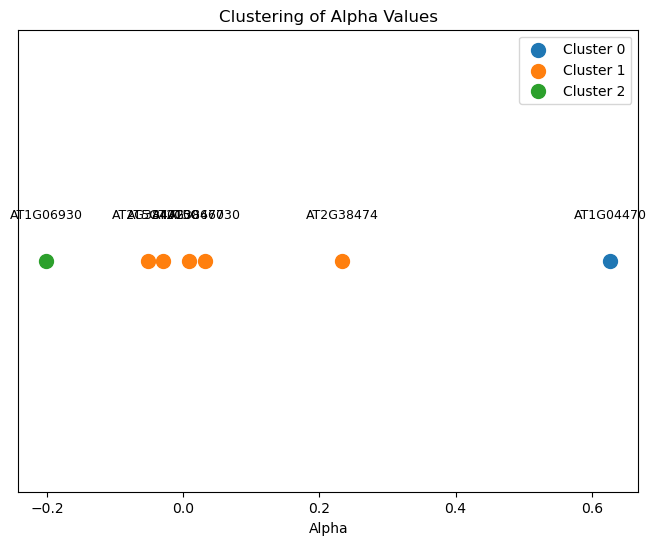

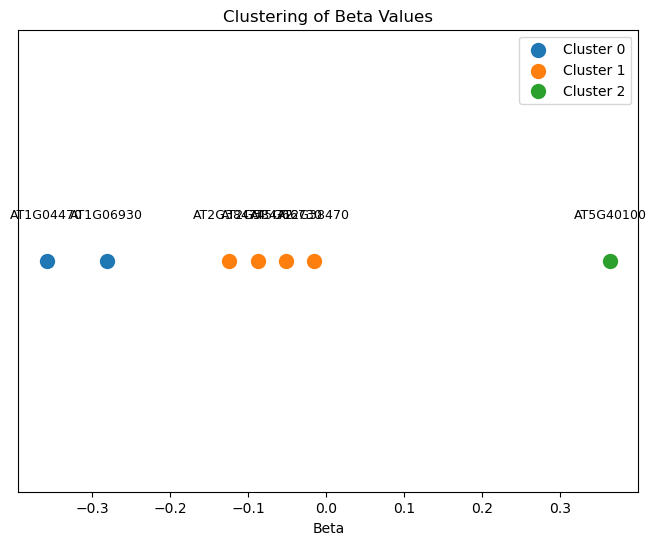

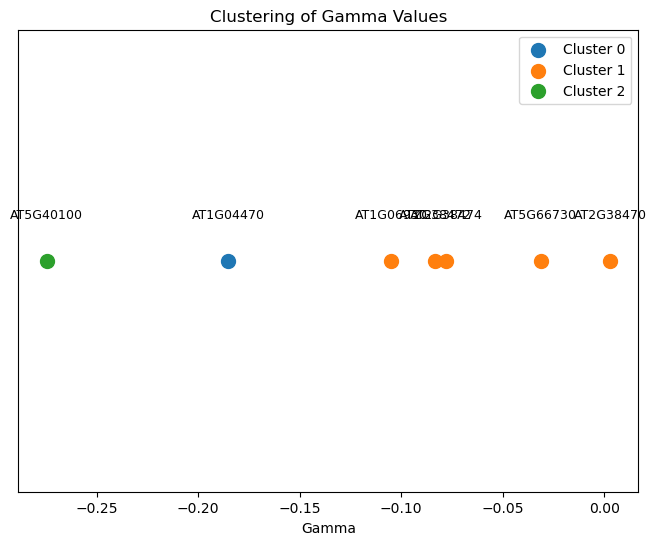

In [21]:
# Plot clusters for alpha
plt.figure(figsize=(8, 6))
for cluster in range(n_clusters):
    cluster_data = params_df[params_df['alpha_cluster'] == cluster]
    plt.scatter(cluster_data['alpha'], np.zeros_like(cluster_data['alpha']),
                label=f'Cluster {cluster}', s=100)
    for _, row in cluster_data.iterrows():
        plt.text(row['alpha'], 0.01, row['Unnamed: 0'], fontsize=9, ha='center')
plt.title('Clustering of Alpha Values')
plt.xlabel('Alpha')
plt.yticks([])
plt.legend()
plt.show()

# Plot clusters for beta
plt.figure(figsize=(8, 6))
for cluster in range(n_clusters):
    cluster_data = params_df[params_df['beta_cluster'] == cluster]
    plt.scatter(cluster_data['beta'], np.zeros_like(cluster_data['beta']),
                label=f'Cluster {cluster}', s=100)
    for _, row in cluster_data.iterrows():
        plt.text(row['beta'], 0.01, row['Unnamed: 0'], fontsize=9, ha='center')
plt.title('Clustering of Beta Values')
plt.xlabel('Beta')
plt.yticks([])
plt.legend()
plt.show()

# Plot clusters for gamma
plt.figure(figsize=(8, 6))
for cluster in range(n_clusters):
    cluster_data = params_df[params_df['gamma_cluster'] == cluster]
    plt.scatter(cluster_data['gamma'], np.zeros_like(cluster_data['gamma']),
                label=f'Cluster {cluster}', s=100)
    for _, row in cluster_data.iterrows():
        plt.text(row['gamma'], 0.01, row['Unnamed: 0'], fontsize=9, ha='center')
plt.title('Clustering of Gamma Values')
plt.xlabel('Gamma')
plt.yticks([])
plt.legend()
plt.show()

In [22]:
print("\nCluster Analysis:")

# Alpha clusters
print("\nAlpha Clusters:")
for cluster in range(n_clusters):
    cluster_genes = params_df[params_df['alpha_cluster'] == cluster]['Unnamed: 0'].values
    
    print(f"Cluster {cluster}: {', '.join(cluster_genes)}")

# Beta clusters
print("\nBeta Clusters:")
for cluster in range(n_clusters):
    cluster_genes = params_df[params_df['beta_cluster'] == cluster]['Unnamed: 0'].values
    print(f"Cluster {cluster}: {', '.join(cluster_genes)}")

# Gamma clusters
print("\nGamma Clusters:")
for cluster in range(n_clusters):
    cluster_genes = params_df[params_df['gamma_cluster'] == cluster]['Unnamed: 0'].values
    print(f"Cluster {cluster}: {', '.join(cluster_genes)}")


Cluster Analysis:

Alpha Clusters:
Cluster 0: AT1G04470
Cluster 1: AT5G40100, AT5G66730, AT2G38472, AT2G38474, AT2G38470
Cluster 2: AT1G06930

Beta Clusters:
Cluster 0: AT1G06930, AT1G04470
Cluster 1: AT5G66730, AT2G38472, AT2G38474, AT2G38470
Cluster 2: AT5G40100

Gamma Clusters:
Cluster 0: AT1G04470
Cluster 1: AT1G06930, AT5G66730, AT2G38472, AT2G38474, AT2G38470
Cluster 2: AT5G40100


In [23]:
params_df.to_csv('clustered_parameters.csv', index=False)
print("\nClustered parameters saved to 'clustered_parameters.csv'.")


Clustered parameters saved to 'clustered_parameters.csv'.


------------------


Synthetic Test Data:
[[-0.7940531  -0.21476406  0.56970559]
 [ 0.38454671  0.33464898 -0.10258746]
 [-0.45872991 -0.81716899 -0.45344458]
 [ 0.95897441  1.0791887   0.42765362]
 [-0.70613061 -0.74082698 -2.60373134]]
True underlying parameters (α, β, γ) for test genes:
[[-0.07930381 -0.82414574  0.13419563]
 [ 0.21735062 -0.44068071 -0.09722352]
 [-0.57026424 -0.31246066  0.16868972]
 [-0.02433206 -0.86341885  0.16396769]
 [-0.63812028 -0.84492066 -0.47356275]]


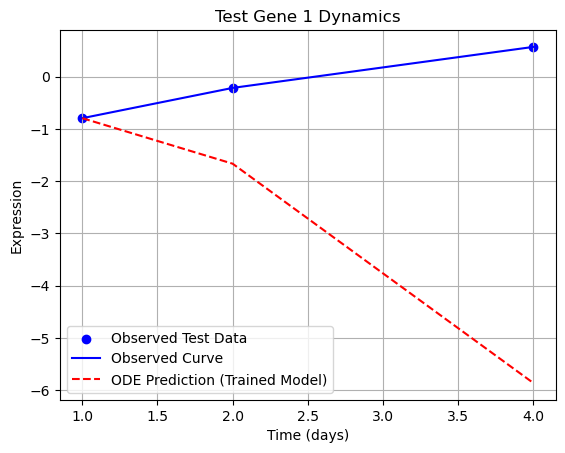

Learned ODE for Test Gene 1 (using Trained Model 1):
  dy/dt = -0.0296 + 0.3638 * y(t) + -0.2747 * t



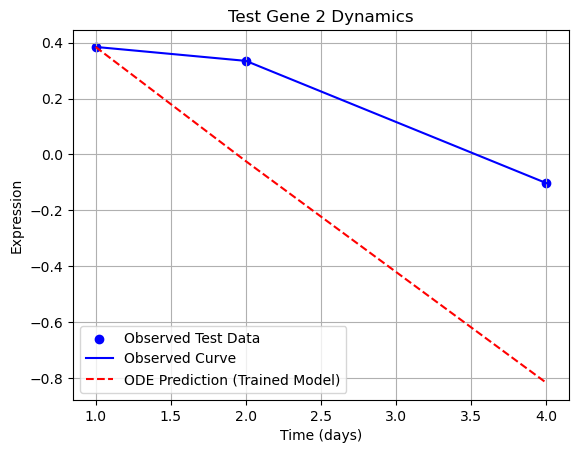

Learned ODE for Test Gene 2 (using Trained Model 2):
  dy/dt = -0.2006 + -0.2818 * y(t) + -0.1049 * t



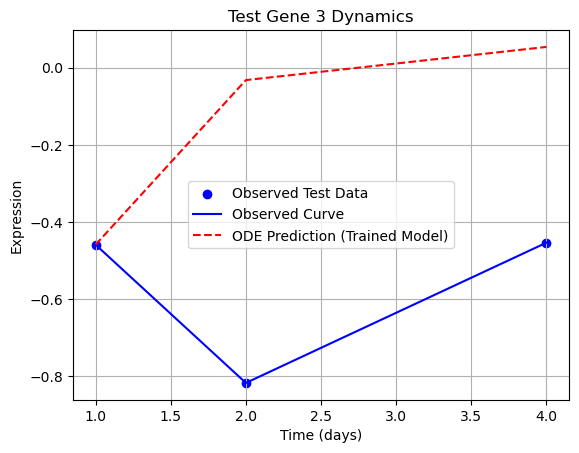

Learned ODE for Test Gene 3 (using Trained Model 3):
  dy/dt = 0.6269 + -0.3589 * y(t) + -0.1854 * t



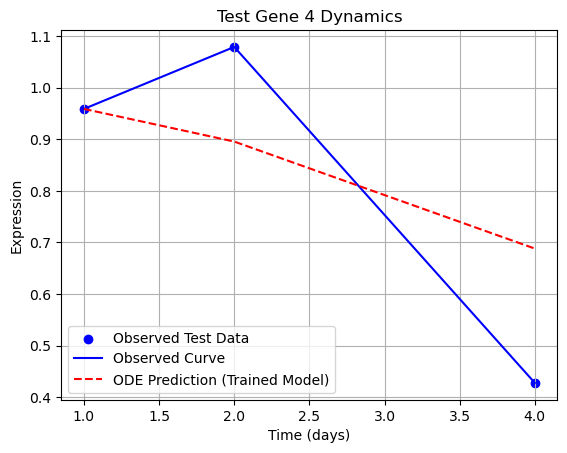

Learned ODE for Test Gene 4 (using Trained Model 4):
  dy/dt = 0.0316 + -0.0514 * y(t) + -0.0314 * t



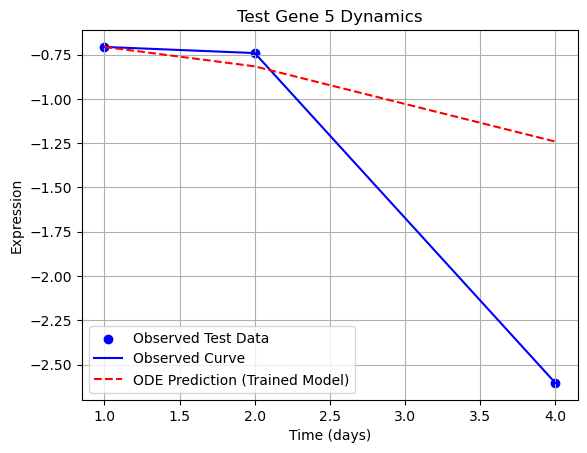

Learned ODE for Test Gene 5 (using Trained Model 5):
  dy/dt = -0.0514 + -0.0880 * y(t) + -0.0832 * t

Cluster assignments for trained ODE parameters (used for testing):
[1 1 0 1 1]


c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


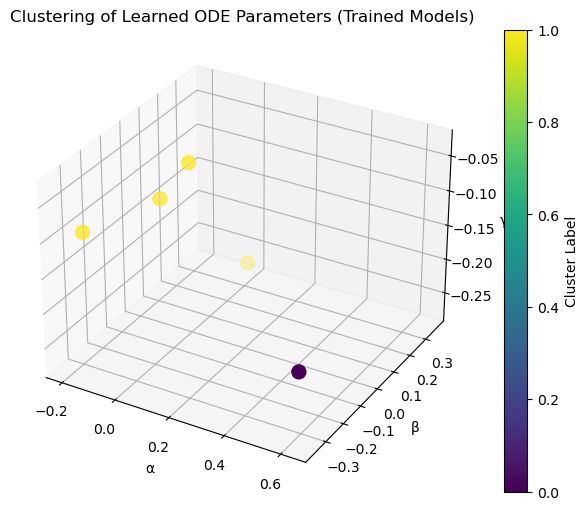

In [24]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from scipy.integrate import odeint as scipy_odeint

# ##############################################################################
# # 1. Data Setup (Training Data)
# ##############################################################################

# data = {
#     "Gene": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730", "AT2G384713"],
#     "Hpa-NO_1d":  [-0.44796,    1.77836,     0.0,         0.05537,    0.505000],
#     "Hpa-NO_2d":  [-0.56015,    0.0,         1.17515,     0.09843,    0.505000],
#     "Hpa-NO_4d":  [-5.09196,    0.0,         0.0,        -0.10176,    0.505000],
# }
# df = pd.DataFrame(data)
# print("Original Training Data:")
# print(df)

# # Time points (in days)
# time_points = np.array([1.0, 2.0, 4.0], dtype=np.float32)  # Day1, Day2, Day4

# # Extract gene expression data (each row is one gene)
# gene_data = df[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values

# # Convert to PyTorch tensors
# time_points_tensor = torch.tensor(time_points, dtype=torch.float32, requires_grad=True)
# gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)

# ##############################################################################
# # 2. Define the Parametric ODE Model for Each Gene: dy/dt = α + β*y(t) + γ*t
# ##############################################################################

# class GeneParametricODE(nn.Module):
#     def __init__(self):
#         super(GeneParametricODE, self).__init__()
#         # Learnable parameters: α, β, and γ
#         self.alpha = nn.Parameter(torch.tensor(0.1))
#         self.beta  = nn.Parameter(torch.tensor(0.1))
#         self.gamma = nn.Parameter(torch.tensor(0.1))

#     def forward(self, t, y):
#         # ODE: dy/dt = α + β*y(t) + γ*t
#         return self.alpha + self.beta * y + self.gamma * t

# # Create one ODE model per gene for training data
# num_genes = gene_data_tensor.shape[0]
# ode_models = nn.ModuleList([GeneParametricODE() for _ in range(num_genes)])

# ##############################################################################
# # 3. Inverse PINN Loss Function (Data Loss + Physics Loss)
# ##############################################################################

# def inverse_pinn_loss(ode_models, time_points, gene_data, lambda_physics=0.1):
#     total_data_loss = 0.0
#     total_physics_loss = 0.0
#     n_genes = gene_data.shape[0]

#     for i in range(n_genes):
#         # Observed expression for gene i (shape: (num_time_points,))
#         y_observed = gene_data[i]
#         # Use the first time point as the initial condition
#         y0 = y_observed[0].unsqueeze(0)  # shape: (1,)

#         # Solve the ODE for gene i over the time points
#         preds = odeint(ode_models[i], y0, time_points).squeeze()  # shape: (num_time_points,)

#         # Data loss: Mean squared error between predictions and observed values
#         data_loss = torch.mean((preds - y_observed)**2)

#         # Physics loss: Enforce that the derivative from autograd matches the ODE output
#         dy_dt_pred = torch.autograd.grad(
#             outputs=preds,
#             inputs=time_points,
#             grad_outputs=torch.ones_like(preds),
#             create_graph=True,
#             retain_graph=True
#         )[0]

#         dy_dt_ode = []
#         for t_val, p_val in zip(time_points, preds):
#             deriv = ode_models[i](t_val, p_val.unsqueeze(0))
#             dy_dt_ode.append(deriv.squeeze())
#         dy_dt_ode = torch.stack(dy_dt_ode)

#         physics_loss = torch.mean((dy_dt_pred - dy_dt_ode)**2)

#         total_data_loss += data_loss
#         total_physics_loss += physics_loss

#     avg_data_loss = total_data_loss / n_genes
#     avg_physics_loss = total_physics_loss / n_genes
#     total_loss = avg_data_loss + lambda_physics * avg_physics_loss
#     return total_loss, avg_data_loss, avg_physics_loss

# ##############################################################################
# # 4. Training Loop on Training Data
# ##############################################################################

# optimizer = optim.Adam(ode_models.parameters(), lr=0.01)
# epochs = 500

# for epoch in range(epochs):
#     optimizer.zero_grad()
#     total_loss, data_loss, physics_loss = inverse_pinn_loss(ode_models, time_points_tensor, gene_data_tensor, lambda_physics=0.1)
#     total_loss.backward()
#     optimizer.step()

#     if epoch % 100 == 0:
#         print(f"Training Epoch {epoch:4d} | Total Loss: {total_loss.item():.4f} | Data Loss: {data_loss.item():.4f} | Physics Loss: {physics_loss.item():.4f}")

##############################################################################
# 5. Generate Synthetic Test Data (Do NOT train on these; only use for testing)
##############################################################################
# Generate synthetic test data using a similar ODE model but with new (synthetic) parameters.
def generate_synthetic_test_data(num_genes, time_points, noise_std=0.1):
    test_data = []
    true_params = []
    for i in range(num_genes):
        # Randomly sample parameters from uniform distributions
        alpha = np.random.uniform(-1, 1)
        beta = np.random.uniform(-1, 1)
        gamma = np.random.uniform(-0.5, 0.5)
        true_params.append([alpha, beta, gamma])

        # Choose an initial condition y0 randomly
        y0 = np.random.uniform(-1, 1)

        # Define the ODE function for simulation
        def ode_func(y, t, alpha=alpha, beta=beta, gamma=gamma):
            return alpha + beta * y + gamma * t

        # Simulate the ODE using SciPy's odeint
        y_sim = scipy_odeint(ode_func, y0, time_points).flatten()
        # Add noise
        y_sim_noisy = y_sim + np.random.normal(0, noise_std, size=y_sim.shape)
        test_data.append(y_sim_noisy)
    return np.array(test_data), np.array(true_params)

num_test_genes = 5
test_time_points = time_points  # same time points for test data
test_data_np, true_test_params = generate_synthetic_test_data(num_test_genes, test_time_points, noise_std=0.2)
print("\nSynthetic Test Data:")
print(test_data_np)
print("True underlying parameters (α, β, γ) for test genes:")
print(true_test_params)

# Convert test data to torch tensor
test_data_tensor = torch.tensor(test_data_np, dtype=torch.float32)

##############################################################################
# 6. Testing: Use Trained Models on Test Data (Do NOT update/train the models)
##############################################################################
# For simplicity, we pair test genes with training models by index
# (using the first min(num_training_genes, num_test_genes) pairs)
num_pairs = min(num_genes, num_test_genes)
learned_params = []  # to collect parameters for clustering

with torch.no_grad():
    for i in range(num_pairs):
        y0_test = test_data_tensor[i, 0].unsqueeze(0)  # use the test gene's Day1 as initial condition
        preds = odeint(ode_models[i], y0_test, time_points_tensor).squeeze().cpu().numpy()

        # Plot observed test data vs. prediction from the trained model
        plt.figure()
        plt.scatter(time_points, test_data_np[i], c='b', label="Observed Test Data")
        plt.plot(time_points, test_data_np[i], 'b-', label="Observed Curve")
        plt.plot(time_points, preds, 'r--', label="ODE Prediction (Trained Model)")
        plt.title(f"Test Gene {i+1} Dynamics")
        plt.xlabel("Time (days)")
        plt.ylabel("Expression")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Extract and print learned parameters from the corresponding trained model
        model_i = ode_models[i]
        alpha = model_i.alpha.item()
        beta = model_i.beta.item()
        gamma = model_i.gamma.item()
        learned_params.append([alpha, beta, gamma])
        print(f"Learned ODE for Test Gene {i+1} (using Trained Model {i+1}):")
        print(f"  dy/dt = {alpha:.4f} + {beta:.4f} * y(t) + {gamma:.4f} * t\n")

learned_params = np.array(learned_params)

##############################################################################
# 7. Cluster the Learned ODE Parameters from Trained Models
##############################################################################
# Cluster the parameter vectors [α, β, γ] from the trained models used for testing.
k = 2  # choose number of clusters (e.g., 2)
kmeans = KMeans(n_clusters=k, random_state=0).fit(learned_params)
cluster_labels = kmeans.labels_
print("Cluster assignments for trained ODE parameters (used for testing):")
print(cluster_labels)

# 3D Scatter Plot of the Clustered Parameters
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(learned_params[:, 0], learned_params[:, 1], learned_params[:, 2],
                     c=cluster_labels, cmap='viridis', s=100)
ax.set_xlabel("α")
ax.set_ylabel("β")
ax.set_zlabel("γ")
ax.set_title("Clustering of Learned ODE Parameters (Trained Models)")
plt.colorbar(scatter, ax=ax, label='Cluster Label')
plt.show()


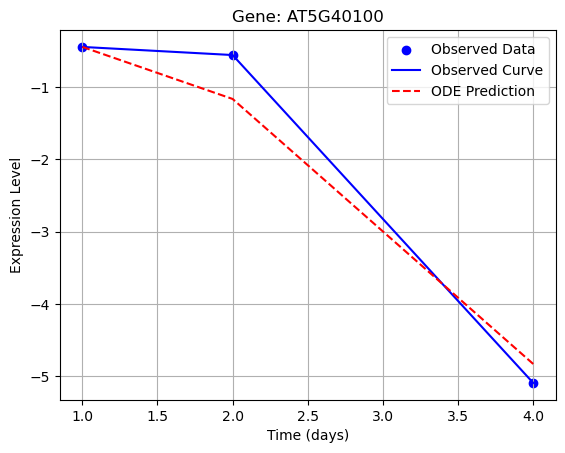

Learned ODE for Gene AT5G40100:
  dy/dt = -0.0296 + 0.3638 * y + -0.2747 * t
Formatted ODE Equation: dy/dt = -0.0296 + 0.3638 * y(t) + -0.2747 * t



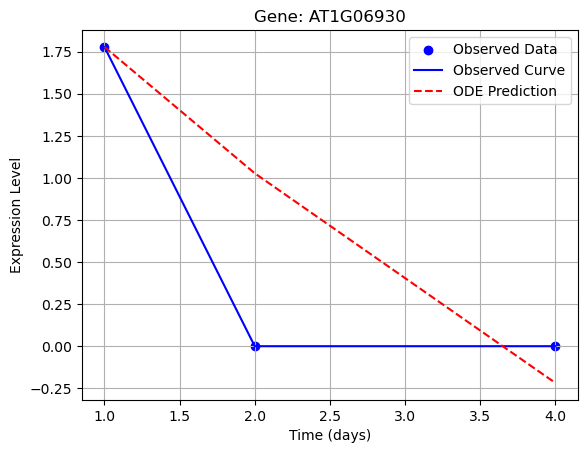

Learned ODE for Gene AT1G06930:
  dy/dt = -0.2006 + -0.2818 * y + -0.1049 * t
Formatted ODE Equation: dy/dt = -0.2006 + -0.2818 * y(t) + -0.1049 * t



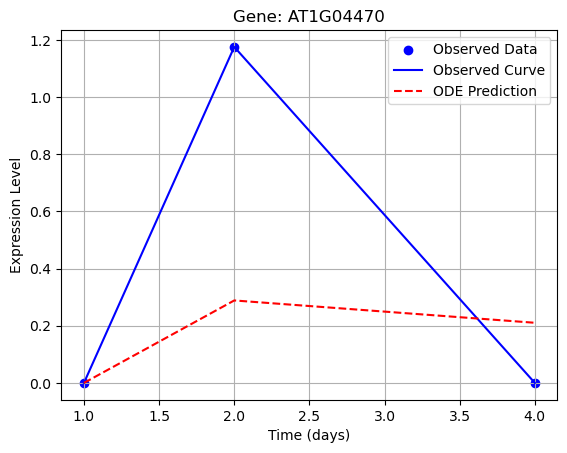

Learned ODE for Gene AT1G04470:
  dy/dt = 0.6269 + -0.3589 * y + -0.1854 * t
Formatted ODE Equation: dy/dt = 0.6269 + -0.3589 * y(t) + -0.1854 * t



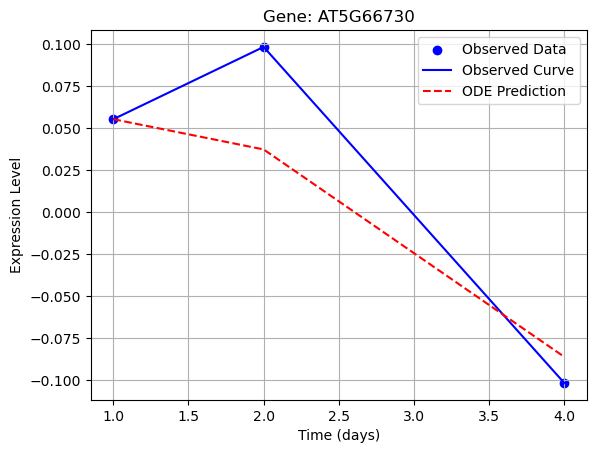

Learned ODE for Gene AT5G66730:
  dy/dt = 0.0316 + -0.0514 * y + -0.0314 * t
Formatted ODE Equation: dy/dt = 0.0316 + -0.0514 * y(t) + -0.0314 * t



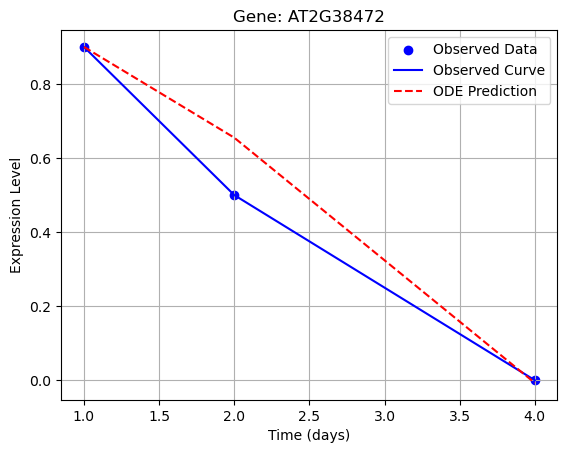

Learned ODE for Gene AT2G38472:
  dy/dt = -0.0514 + -0.0880 * y + -0.0832 * t
Formatted ODE Equation: dy/dt = -0.0514 + -0.0880 * y(t) + -0.0832 * t



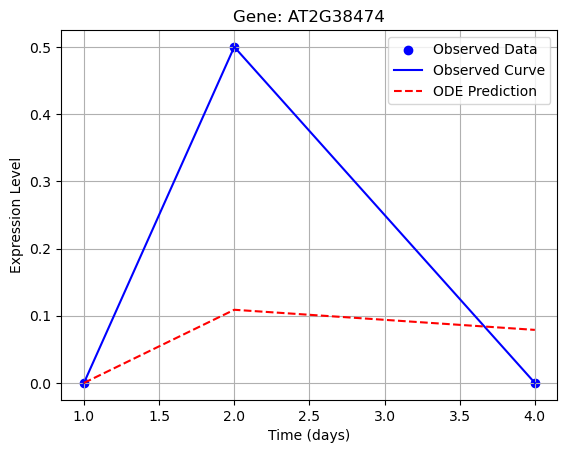

Learned ODE for Gene AT2G38474:
  dy/dt = 0.2333 + -0.1246 * y + -0.0778 * t
Formatted ODE Equation: dy/dt = 0.2333 + -0.1246 * y(t) + -0.0778 * t



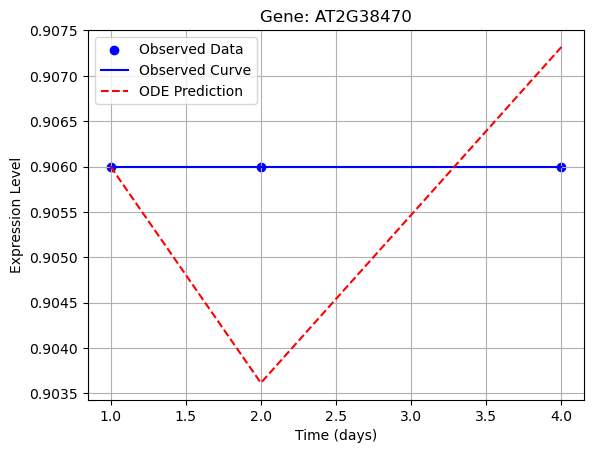

Learned ODE for Gene AT2G38470:
  dy/dt = 0.0081 + -0.0163 * y + 0.0028 * t
Formatted ODE Equation: dy/dt = 0.0081 + -0.0163 * y(t) + 0.0028 * t


Learned Parameters:
        Gene     alpha      beta     gamma
0  AT5G40100 -0.029587  0.363788 -0.274705
1  AT1G06930 -0.200648 -0.281768 -0.104929
2  AT1G04470  0.626873 -0.358907 -0.185361
3  AT5G66730  0.031551 -0.051446 -0.031368
4  AT2G38472 -0.051423 -0.087976 -0.083190
5  AT2G38474  0.233312 -0.124592 -0.077811
6  AT2G38470  0.008094 -0.016265  0.002823

Parameters with Individual Clusters:
        Gene     alpha      beta     gamma  alpha_cluster  beta_cluster  \
0  AT5G40100 -0.029587  0.363788 -0.274705              1             2   
1  AT1G06930 -0.200648 -0.281768 -0.104929              2             0   
2  AT1G04470  0.626873 -0.358907 -0.185361              0             0   
3  AT5G66730  0.031551 -0.051446 -0.031368              1             1   
4  AT2G38472 -0.051423 -0.087976 -0.083190              1             1   
5

c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


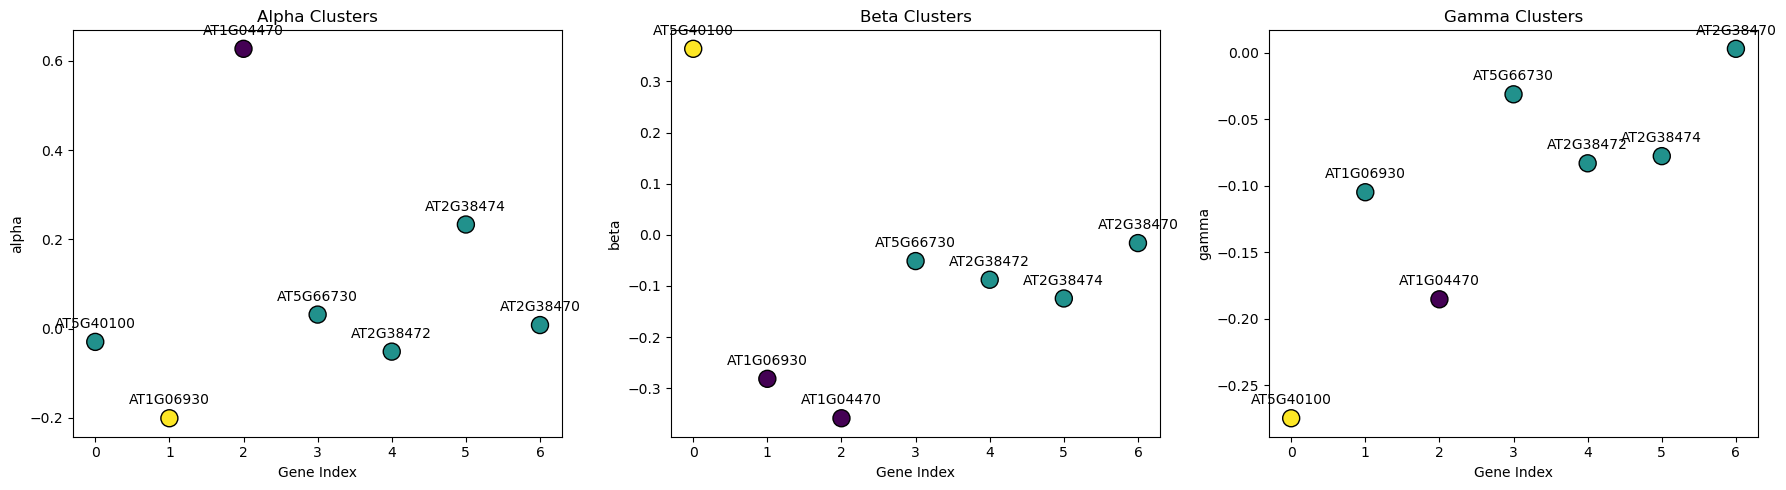


Cluster Analysis for Alpha:
Alpha Cluster 0: AT1G04470
Alpha Cluster 1: AT5G40100, AT5G66730, AT2G38472, AT2G38474, AT2G38470
Alpha Cluster 2: AT1G06930

Cluster Analysis for Beta:
Beta Cluster 0: AT1G06930, AT1G04470
Beta Cluster 1: AT5G66730, AT2G38472, AT2G38474, AT2G38470
Beta Cluster 2: AT5G40100

Cluster Analysis for Gamma:
Gamma Cluster 0: AT1G04470
Gamma Cluster 1: AT1G06930, AT5G66730, AT2G38472, AT2G38474, AT2G38470
Gamma Cluster 2: AT5G40100


In [25]:
##############################################################################
# Plotting Predictions and Printing Learned ODE Parameters
##############################################################################

with torch.no_grad():
    for i, gene_id in enumerate(df['Unnamed: 0']):
        # Use the Day1 value as the initial condition for each gene
        y0 = gene_data_tensor[i, 0].unsqueeze(0)  # shape: (1,)
        preds = odeint(ode_models[i], y0, time_points_tensor).squeeze().numpy()

        # Plot observed data vs. ODE predictions
        plt.figure()
        plt.scatter(time_points, gene_data[i], c='b', label="Observed Data")
        plt.plot(time_points, gene_data[i], 'b-', label="Observed Curve")
        plt.plot(time_points, preds, 'r--', label="ODE Prediction")
        plt.title(f"Gene: {gene_id}")
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Print learned parameters for the gene
        model = ode_models[i]
        alpha = model.alpha.item()
        beta = model.beta.item()
        gamma = model.gamma.item()
        print(f"Learned ODE for Gene {gene_id}:")
        print(f"  dy/dt = {alpha:.4f} + {beta:.4f} * y + {gamma:.4f} * t")
        print(f"Formatted ODE Equation: dy/dt = {alpha:.4f} + {beta:.4f} * y(t) + {gamma:.4f} * t\n")

##############################################################################
# Clustering Learned Parameters Separately for alpha, beta, and gamma
##############################################################################

# Create a DataFrame to store parameters
params_df = pd.DataFrame(columns=['Gene', 'alpha', 'beta', 'gamma'])

with torch.no_grad():
    for i, gene_id in enumerate(df['Unnamed: 0']):
        model = ode_models[i]
        params_df.loc[i] = [
            gene_id,
            model.alpha.item(),
            model.beta.item(),
            model.gamma.item()
        ]

print("\nLearned Parameters:")
print(params_df)

# Cluster each parameter individually
from sklearn.cluster import KMeans

# Cluster for alpha
alphas = params_df['alpha'].values.reshape(-1, 1)
kmeans_alpha = KMeans(n_clusters=3, random_state=42).fit(alphas)
params_df['alpha_cluster'] = kmeans_alpha.labels_

# Cluster for beta
betas = params_df['beta'].values.reshape(-1, 1)
kmeans_beta = KMeans(n_clusters=3, random_state=42).fit(betas)
params_df['beta_cluster'] = kmeans_beta.labels_

# Cluster for gamma
gammas = params_df['gamma'].values.reshape(-1, 1)
kmeans_gamma = KMeans(n_clusters=3, random_state=42).fit(gammas)
params_df['gamma_cluster'] = kmeans_gamma.labels_

print("\nParameters with Individual Clusters:")
print(params_df)

##############################################################################
# Visualize Clusters for Each Parameter
##############################################################################

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# For alpha: simple scatter of gene index vs. alpha, colored by cluster
axs[0].scatter(range(len(alphas)), alphas, c=params_df['alpha_cluster'], cmap='viridis', s=150, edgecolor='k')
for i, txt in enumerate(params_df['Gene']):
    axs[0].annotate(txt, (i, alphas[i]), textcoords="offset points", xytext=(0,10), ha='center')
axs[0].set_title('Alpha Clusters')
axs[0].set_xlabel('Gene Index')
axs[0].set_ylabel('alpha')

# For beta
axs[1].scatter(range(len(betas)), betas, c=params_df['beta_cluster'], cmap='viridis', s=150, edgecolor='k')
for i, txt in enumerate(params_df['Gene']):
    axs[1].annotate(txt, (i, betas[i]), textcoords="offset points", xytext=(0,10), ha='center')
axs[1].set_title('Beta Clusters')
axs[1].set_xlabel('Gene Index')
axs[1].set_ylabel('beta')

# For gamma
axs[2].scatter(range(len(gammas)), gammas, c=params_df['gamma_cluster'], cmap='viridis', s=150, edgecolor='k')
for i, txt in enumerate(params_df['Gene']):
    axs[2].annotate(txt, (i, gammas[i]), textcoords="offset points", xytext=(0,10), ha='center')
axs[2].set_title('Gamma Clusters')
axs[2].set_xlabel('Gene Index')
axs[2].set_ylabel('gamma')

plt.tight_layout()
plt.show()

##############################################################################
# Cluster Analysis for Each Parameter
##############################################################################

print("\nCluster Analysis for Alpha:")
for cluster in sorted(params_df['alpha_cluster'].unique()):
    group = params_df[params_df['alpha_cluster'] == cluster]
    print(f"Alpha Cluster {cluster}: {', '.join(group['Gene'])}")

print("\nCluster Analysis for Beta:")
for cluster in sorted(params_df['beta_cluster'].unique()):
    group = params_df[params_df['beta_cluster'] == cluster]
    print(f"Beta Cluster {cluster}: {', '.join(group['Gene'])}")

print("\nCluster Analysis for Gamma:")
for cluster in sorted(params_df['gamma_cluster'].unique()):
    group = params_df[params_df['gamma_cluster'] == cluster]
    print(f"Gamma Cluster {cluster}: {', '.join(group['Gene'])}")


C:\Users\praba\AppData\Local\Temp\ipykernel_24568\2551134867.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='alpha_cluster', y='alpha', data=params_df, palette='viridis')


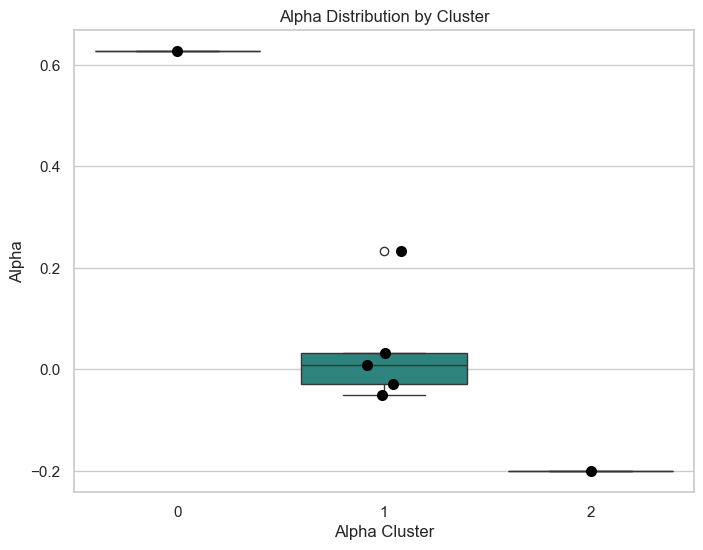

C:\Users\praba\AppData\Local\Temp\ipykernel_24568\2551134867.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='beta_cluster', y='beta', data=params_df, palette='viridis')


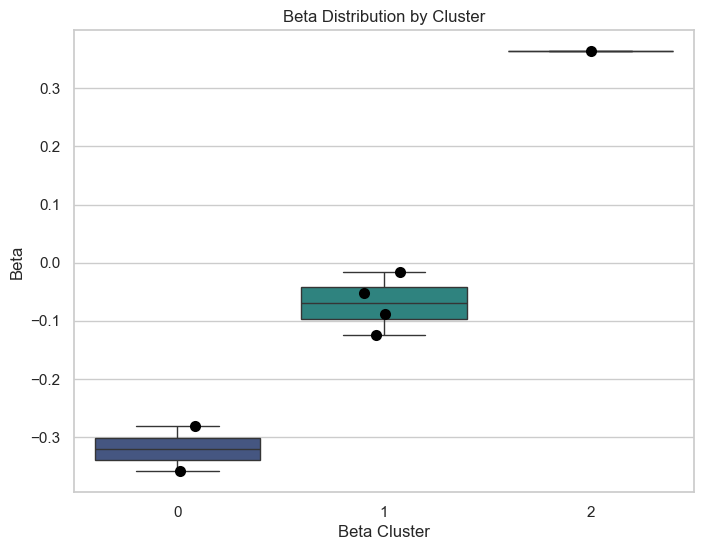

C:\Users\praba\AppData\Local\Temp\ipykernel_24568\2551134867.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='gamma_cluster', y='gamma', data=params_df, palette='viridis')


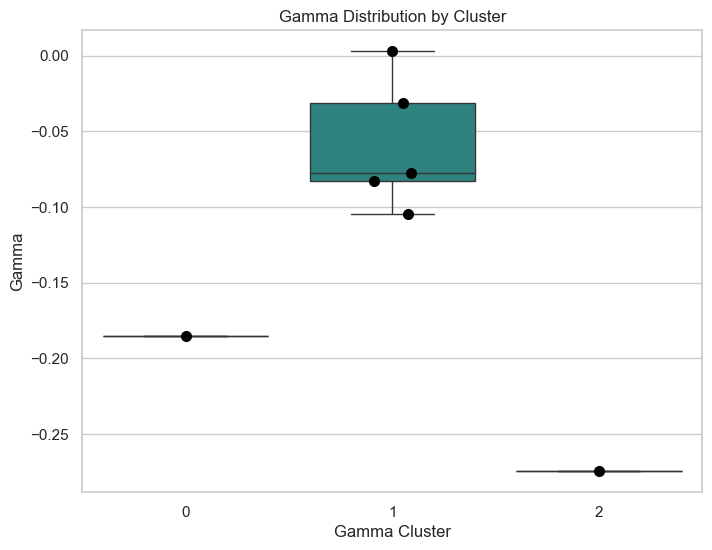

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Plot for alpha
plt.figure(figsize=(8, 6))
sns.boxplot(x='alpha_cluster', y='alpha', data=params_df, palette='viridis')
sns.stripplot(x='alpha_cluster', y='alpha', data=params_df, color='black', size=8, jitter=True)
plt.title('Alpha Distribution by Cluster')
plt.xlabel('Alpha Cluster')
plt.ylabel('Alpha')
plt.show()

# Plot for beta
plt.figure(figsize=(8, 6))
sns.boxplot(x='beta_cluster', y='beta', data=params_df, palette='viridis')
sns.stripplot(x='beta_cluster', y='beta', data=params_df, color='black', size=8, jitter=True)
plt.title('Beta Distribution by Cluster')
plt.xlabel('Beta Cluster')
plt.ylabel('Beta')
plt.show()

# Plot for gamma
plt.figure(figsize=(8, 6))
sns.boxplot(x='gamma_cluster', y='gamma', data=params_df, palette='viridis')
sns.stripplot(x='gamma_cluster', y='gamma', data=params_df, color='black', size=8, jitter=True)
plt.title('Gamma Distribution by Cluster')
plt.xlabel('Gamma Cluster')
plt.ylabel('Gamma')
plt.show()


C:\Users\praba\AppData\Local\Temp\ipykernel_24568\2577053300.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='alpha_cluster', y='alpha', data=params_df, palette='viridis', inner="quartile")


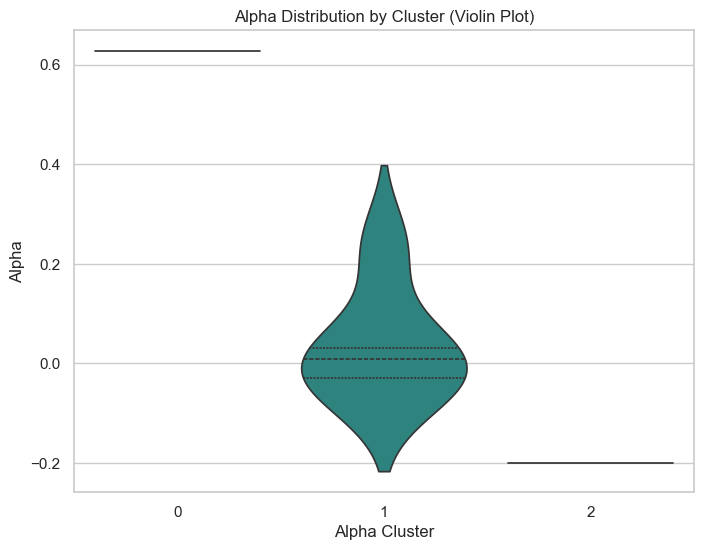

C:\Users\praba\AppData\Local\Temp\ipykernel_24568\2577053300.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='beta_cluster', y='beta', data=params_df, palette='viridis', inner="quartile")


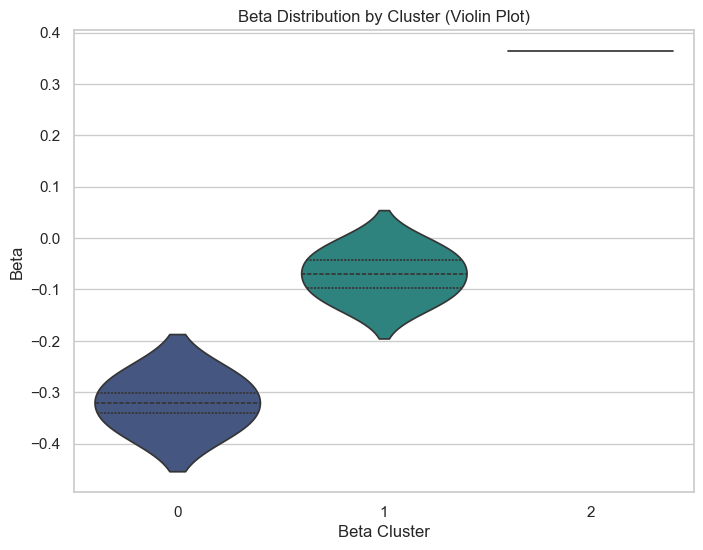

C:\Users\praba\AppData\Local\Temp\ipykernel_24568\2577053300.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='gamma_cluster', y='gamma', data=params_df, palette='viridis', inner="quartile")


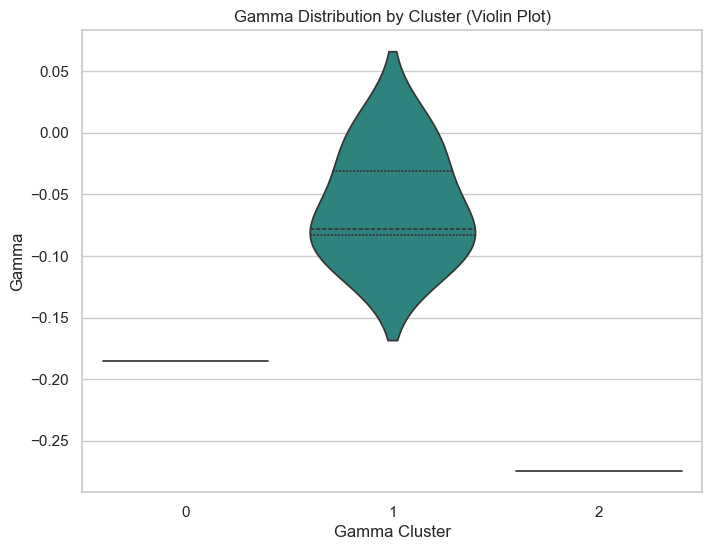

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Violin plot for alpha
plt.figure(figsize=(8, 6))
sns.violinplot(x='alpha_cluster', y='alpha', data=params_df, palette='viridis', inner="quartile")
plt.title('Alpha Distribution by Cluster (Violin Plot)')
plt.xlabel('Alpha Cluster')
plt.ylabel('Alpha')
plt.show()

# Violin plot for beta
plt.figure(figsize=(8, 6))
sns.violinplot(x='beta_cluster', y='beta', data=params_df, palette='viridis', inner="quartile")
plt.title('Beta Distribution by Cluster (Violin Plot)')
plt.xlabel('Beta Cluster')
plt.ylabel('Beta')
plt.show()

# Violin plot for gamma
plt.figure(figsize=(8, 6))
sns.violinplot(x='gamma_cluster', y='gamma', data=params_df, palette='viridis', inner="quartile")
plt.title('Gamma Distribution by Cluster (Violin Plot)')
plt.xlabel('Gamma Cluster')
plt.ylabel('Gamma')
plt.show()



## 1. Extending Cluster-Based Prediction

Let's implement code that uses the cluster parameters to predict gene expression trajectories for new test data:



In [28]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Define a function to predict gene expression using cluster-averaged parameters
def predict_with_cluster_params(time_points, y0, cluster_params):
    """
    Predict gene expression trajectory using cluster-averaged parameters.
    
    Args:
        time_points: tensor of time points
        y0: initial value tensor [1]
        cluster_params: tuple (alpha, beta, gamma) for the cluster
    
    Returns:
        Predicted trajectory
    """
    alpha, beta, gamma = cluster_params
    
    class ClusterODE(nn.Module):
        def forward(self, t, y):
            return alpha + beta * y + gamma * t
    
    model = ClusterODE()
    y_pred = odeint(model, y0, time_points).squeeze()
    
    return y_pred



## 2. Compute Cluster-Averaged Parameters



In [29]:
# Extract parameters from trained models
def extract_cluster_parameters(ode_models, clusters, df):
    """Extract and average parameters for each cluster."""
    cluster_params = {}
    
    for cluster_id in np.unique(clusters):
        # Get indices for this cluster
        indices = np.where(clusters == cluster_id)[0]
        
        # Extract parameters from models in this cluster
        alphas = [ode_models[i].alpha.item() for i in indices]
        betas = [ode_models[i].beta.item() for i in indices]
        gammas = [ode_models[i].gamma.item() for i in indices]
        
        # Calculate average parameters for this cluster
        avg_alpha = np.mean(alphas)
        avg_beta = np.mean(betas)
        avg_gamma = np.mean(gammas)
        
        # Store in dictionary
        cluster_params[cluster_id] = (avg_alpha, avg_beta, avg_gamma)
        
        print(f"Cluster {cluster_id} (n={len(indices)}):")
        print(f"  Genes: {', '.join([df['Unnamed: 0'][i] for i in indices])}")
        print(f"  α = {avg_alpha:.4f}, β = {avg_beta:.4f}, γ = {avg_gamma:.4f}\n")
    
    return cluster_params

# Get cluster parameters
params_array = []
with torch.no_grad():
    for i in range(len(ode_models)):
        params_array.append([
            ode_models[i].alpha.item(),
            ode_models[i].beta.item(),
            ode_models[i].gamma.item()
        ])
params_array = np.array(params_array)

# Scale parameters for clustering
scaler = StandardScaler()
scaled_params = scaler.fit_transform(params_array)

# Cluster using K-means (k=3)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_params)

# Get cluster-averaged parameters
cluster_params = extract_cluster_parameters(ode_models, clusters, df)

Cluster 0 (n=1):
  Genes: AT1G04470
  α = 0.6269, β = -0.3589, γ = -0.1854

Cluster 1 (n=5):
  Genes: AT1G06930, AT5G66730, AT2G38472, AT2G38474, AT2G38470
  α = 0.0042, β = -0.1124, γ = -0.0589

Cluster 2 (n=1):
  Genes: AT5G40100
  α = -0.0296, β = 0.3638, γ = -0.2747



c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(




## 3. Test Data Generation and Cluster Assignment



In [30]:
# Generate synthetic test data
def generate_synthetic_test_data(n_genes=5, noise_level=0.1):
    """Generate synthetic test data with similar patterns to training data."""
    test_data = {
        "Gene_ID": [f"TEST_{i+1}" for i in range(n_genes)],
        "Day1": [
            -0.5,    # Similar to AT5G40100 (decreasing)
            1.7,     # Similar to AT1G06930 (decreasing)
            0.1,     # Similar to AT1G04470 (increasing then decreasing)
            0.06,    # Similar to AT5G66730 (slight changes)
            0.9      # Similar to AT2G38472 (decreasing)
        ],
        "Day2": [
            -1.0,    # Decreasing
            0.9,     # Decreasing
            1.0,     # Peak
            0.1,     # Slight increase
            0.5      # Decreasing
        ],
        "Day4": [
            -5.0,    # Sharp decrease
            0.2,     # Continued decrease
            0.2,     # Decrease from peak
            -0.1,    # Slight decrease
            0.1      # Continued decrease
        ]
    }
    
    # Add noise
    for day in ["Day1", "Day2", "Day4"]:
        test_data[day] = [x + np.random.normal(0, noise_level) for x in test_data[day]]
    
    return pd.DataFrame(test_data)

# Generate test data
test_df = generate_synthetic_test_data(noise_level=0.05)
print("Synthetic Test Data:")
print(test_df)

# Prepare test data for prediction
test_time_points = np.array([1.0, 2.0, 4.0])
test_time_points_tensor = torch.tensor(test_time_points, dtype=torch.float32, requires_grad=True)
test_values = test_df[["Day1", "Day2", "Day4"]].values
test_values_tensor = torch.tensor(test_values, dtype=torch.float32)

Synthetic Test Data:
  Gene_ID      Day1      Day2      Day4
0  TEST_1 -0.502757 -1.071171 -5.001464
1  TEST_2  1.647818  0.896405  0.162217
2  TEST_3  0.073917  1.017351  0.249596
3  TEST_4  0.009398  0.120365 -0.202974
4  TEST_5  0.917503  0.463069  0.053878




## 4. Cluster Assignment and Prediction



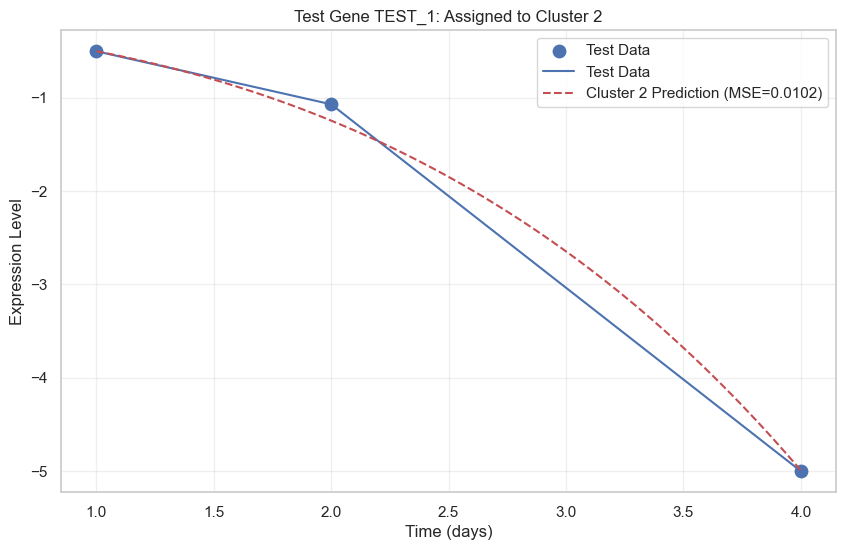

Cluster 2 ODE: dy/dt = -0.0296 + 0.3638*y + -0.2747*t
MSE: 0.0102



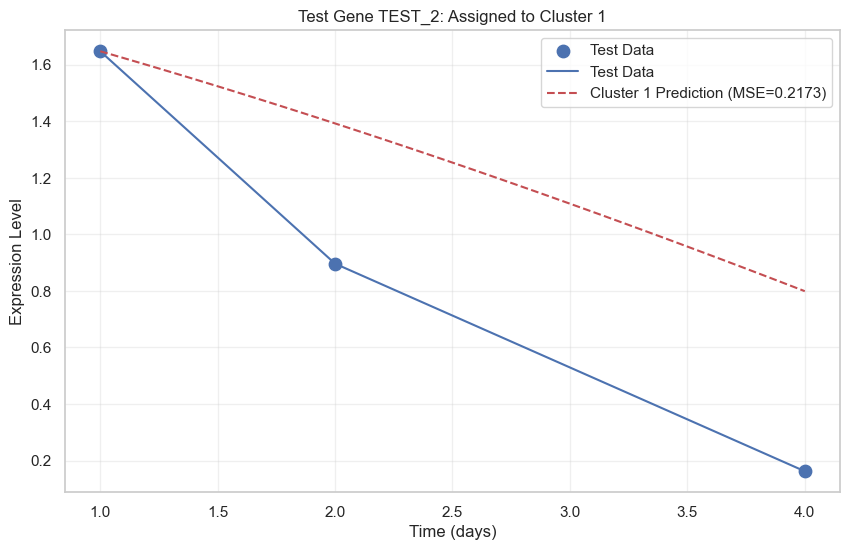

Cluster 1 ODE: dy/dt = 0.0042 + -0.1124*y + -0.0589*t
MSE: 0.2173



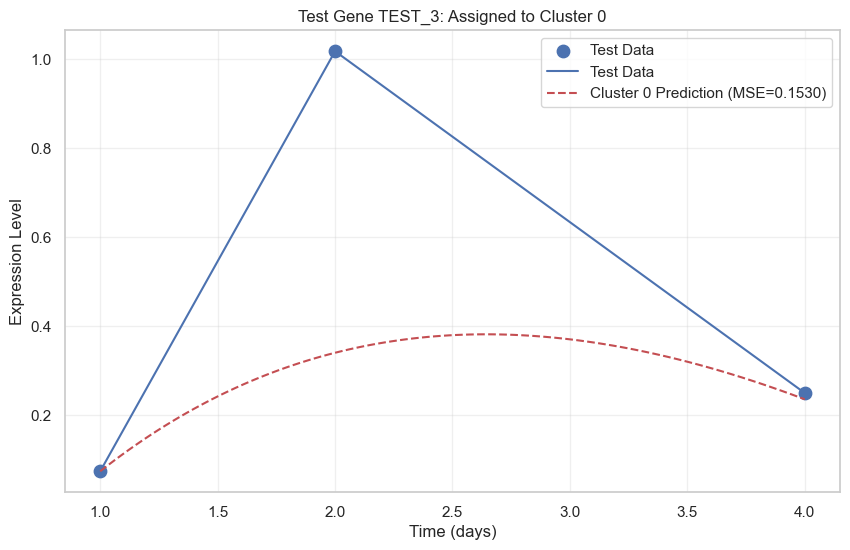

Cluster 0 ODE: dy/dt = 0.6269 + -0.3589*y + -0.1854*t
MSE: 0.1530



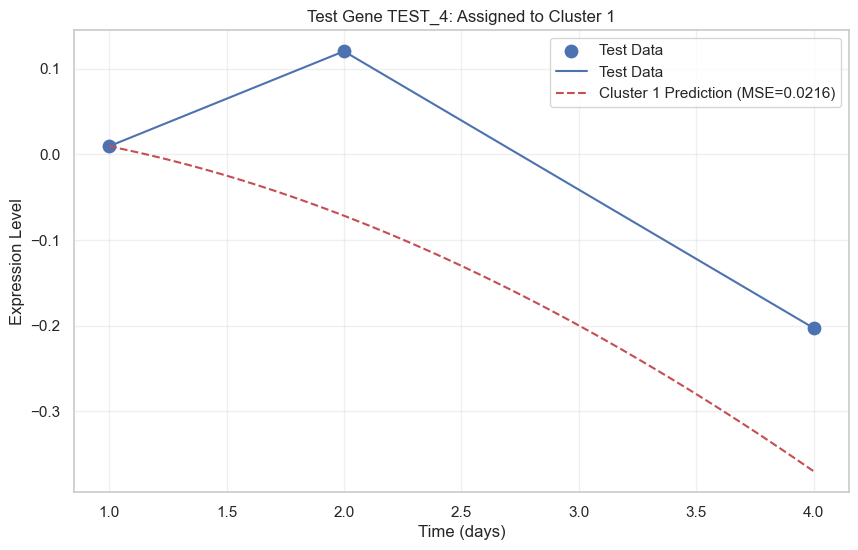

Cluster 1 ODE: dy/dt = 0.0042 + -0.1124*y + -0.0589*t
MSE: 0.0216



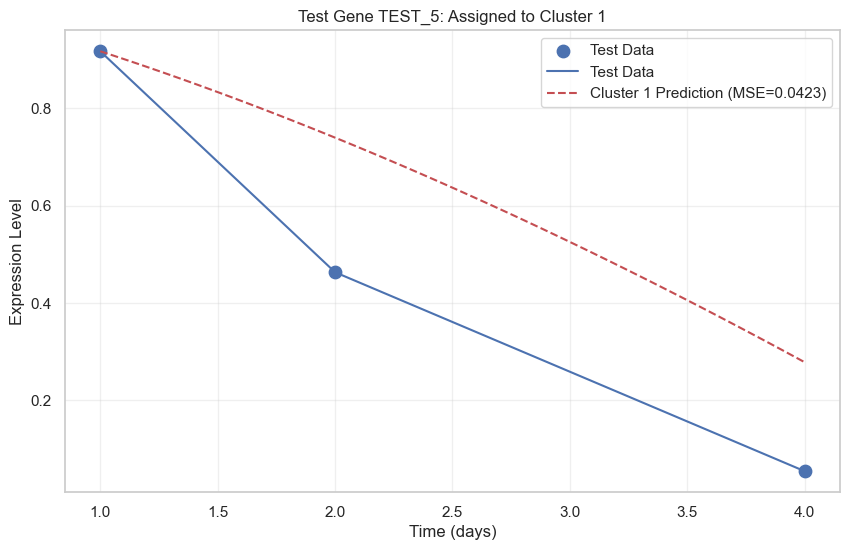

Cluster 1 ODE: dy/dt = 0.0042 + -0.1124*y + -0.0589*t
MSE: 0.0423


Test Gene Assignment Summary:
Gene      Cluster   MSE       
--------------------------------------------------
TEST_1    2         0.0102    
TEST_2    1         0.2173    
TEST_3    0         0.1530    
TEST_4    1         0.0216    
TEST_5    1         0.0423    


In [31]:
def assign_to_cluster_and_predict(test_gene_data, clusters, cluster_params, time_points_tensor):
    """
    Assign a test gene to the best-matching cluster and predict its trajectory.
    
    Args:
        test_gene_data: tensor of gene expression [n_timepoints]
        clusters: array of cluster assignments for training genes
        cluster_params: dictionary mapping cluster_id to (alpha, beta, gamma)
        time_points_tensor: tensor of time points
    
    Returns:
        best_cluster: int, best matching cluster ID
        prediction: tensor of predicted values
        mse: float, mean squared error between prediction and actual
    """
    # Initial value (Day1)
    y0 = test_gene_data[0].unsqueeze(0)
    
    # Try each cluster and compute error
    errors = []
    predictions = []
    
    for cluster_id in cluster_params:
        # Predict using this cluster's parameters
        pred = predict_with_cluster_params(
            time_points_tensor, 
            y0, 
            cluster_params[cluster_id]
        )
        
        # Calculate error
        mse = torch.mean((pred - test_gene_data)**2).item()
        errors.append(mse)
        predictions.append(pred.detach())
    
    # Find best cluster (lowest error)
    best_cluster = np.argmin(errors)
    best_error = errors[best_cluster]
    best_pred = predictions[best_cluster]
    
    return best_cluster, best_pred, best_error

# Evaluate test genes
results = []
fine_t = torch.linspace(1, 4, 100)

with torch.no_grad():
    for i in range(len(test_df)):
        gene_id = test_df["Gene_ID"][i]
        gene_data = test_values_tensor[i]
        
        # Find best cluster and get prediction
        best_cluster, prediction, error = assign_to_cluster_and_predict(
            gene_data, 
            clusters, 
            cluster_params, 
            test_time_points_tensor
        )
        
        # Generate fine-grained prediction for plotting
        y0 = gene_data[0].unsqueeze(0)
        fine_pred = predict_with_cluster_params(fine_t, y0, cluster_params[best_cluster])
        
        # Store results
        results.append({
            "gene_id": gene_id,
            "best_cluster": best_cluster,
            "error": error
        })
        
        # Plot
        plt.figure(figsize=(10, 6))
        plt.scatter(test_time_points, gene_data.numpy(), c='b', s=80, label="Test Data")
        plt.plot(test_time_points, gene_data.numpy(), 'b-', label="Test Data")
        plt.plot(fine_t.numpy(), fine_pred.numpy(), 'r--', 
                 label=f"Cluster {best_cluster} Prediction (MSE={error:.4f})")
        
        plt.title(f"Test Gene {gene_id}: Assigned to Cluster {best_cluster}")
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()
        
        # Print cluster equation
        alpha, beta, gamma = cluster_params[best_cluster]
        print(f"Cluster {best_cluster} ODE: dy/dt = {alpha:.4f} + {beta:.4f}*y + {gamma:.4f}*t")
        print(f"MSE: {error:.4f}\n")

# Summarize results
print("\nTest Gene Assignment Summary:")
print("="*50)
print(f"{'Gene':<10}{'Cluster':<10}{'MSE':<10}")
print("-"*50)
for res in results:
    print(f"{res['gene_id']:<10}{res['best_cluster']:<10}{res['error']:<10.4f}")
print("="*50)



## 5. Pure Inverse PINN Implementation

Now, let's implement a pure Inverse PINN approach (without Neural ODE) for comparison:



In [33]:
print("Original Data:")
print(df)

# Time points (in days)
time_points = np.array([1.0, 2.0, 4.0], dtype=np.float32)  # Day1, Day2, Day4

# Extract gene expression data (each row is one gene)
gene_data = df[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values

# Convert to PyTorch tensors
time_points_tensor = torch.tensor(time_points, dtype=torch.float32, requires_grad=True)
gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)


class InversePINNModel(nn.Module):
    def __init__(self, n_genes):
        super(InversePINNModel, self).__init__()
        # Initialize parameters for each gene
        self.alpha = nn.Parameter(torch.ones(n_genes) * 0.1)
        self.beta = nn.Parameter(torch.ones(n_genes) * 0.1)
        self.gamma = nn.Parameter(torch.ones(n_genes) * 0.1)
        
    def forward(self, t, y0, gene_idx):
        """
        Compute gene expression values at time t using analytical solution
        of the ODE: dy/dt = α + β*y + γ*t
        
        This is the general solution for the ODE:
        y(t) = C*e^(β*t) - (α/β) - (γ/β)*t - (γ/β²)
        Where C is determined by the initial condition y(0)
        """
        alpha = self.alpha[gene_idx]
        beta = self.beta[gene_idx]
        gamma = self.gamma[gene_idx]
        
        # Handle special case where beta is close to zero
        if abs(beta.item()) < 1e-5:
            # If β ≈ 0, the ODE becomes: dy/dt = α + γ*t
            # Which has solution: y(t) = y0 + α*t + (γ/2)*t²
            return y0 + alpha * t + (gamma/2) * t**2
        
        # General case
        # Solve for C using initial condition y(t0=1) = y0
        t0 = 1.0  # Day 1 is our initial condition
        C = torch.exp(-beta * t0) * (y0 + (alpha/beta) + (gamma/beta)*t0 + (gamma/beta**2))
        
        # Calculate solution at time t
        y_t = C * torch.exp(beta * t) - (alpha/beta) - (gamma/beta)*t - (gamma/beta**2)
        return y_t

# Define a function to train the Inverse PINN model
def train_inverse_pinn(gene_data, time_points, epochs=500):
    n_genes = gene_data.shape[0]
    model = InversePINNModel(n_genes)
    
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        total_data_loss = 0
        total_physics_loss = 0
        
        for i in range(n_genes):
            # Get the data for this gene
            y_observed = gene_data[i]
            y0 = y_observed[0]  # Day 1 value
            
            # Predict expression values at observation times
            predictions = []
            for j, t in enumerate(time_points):
                pred = model(t, y0, i)
                predictions.append(pred)
            predictions = torch.stack(predictions)
            
            # Data loss
            data_loss = torch.mean((predictions - y_observed)**2)
            total_data_loss += data_loss
            
            # Physics loss - check if our analytical solution satisfies the ODE
            alpha = model.alpha[i]
            beta = model.beta[i]
            gamma = model.gamma[i]
            
            physics_loss = 0
            for j, t in enumerate(time_points):
                y_t = predictions[j]
                
                # The ODE is: dy/dt = α + β*y + γ*t
                # For the analytical solution, compute the derivative
                if abs(beta.item()) < 1e-5:
                    dy_dt = alpha + gamma * t
                else:
                    C = torch.exp(-beta) * (y0 + (alpha/beta) + (gamma/beta) + (gamma/beta**2))
                    dy_dt = beta * C * torch.exp(beta * t) - (gamma/beta)
                
                # Compare with the expected derivative from the ODE
                expected_dy_dt = alpha + beta * y_t + gamma * t
                physics_loss += (dy_dt - expected_dy_dt)**2
            
            physics_loss = physics_loss / len(time_points)
            total_physics_loss += physics_loss
        
        # Average losses across all genes
        avg_data_loss = total_data_loss / n_genes
        avg_physics_loss = total_physics_loss / n_genes
        
        # Total loss
        lambda_physics = 0.1
        total_loss = avg_data_loss + lambda_physics * avg_physics_loss
        
        # Backpropagation
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Total Loss = {total_loss.item():.4f}, "
                  f"Data Loss = {avg_data_loss.item():.4f}, "
                  f"Physics Loss = {avg_physics_loss.item():.4f}")
    
    return model

# Train Inverse PINN model
print("Training pure Inverse PINN model...")
pinn_model = train_inverse_pinn(gene_data_tensor, time_points_tensor)



Original Data:
  Unnamed: 0  Hpa-NO_1d  Hpa-NO_2d  Hpa-NO_4d
0  AT5G40100  -0.447960  -0.560155  -5.091964
1  AT1G06930   1.778359   0.000000   0.000000
2  AT1G04470   0.000000   1.175150   0.000000
3  AT5G66730   0.055375   0.098435  -0.101757
4  AT2G38472   0.900000   0.500000   0.000000
5  AT2G38474   0.000000   0.500000   0.000000
6  AT2G38470   0.906000   0.906000   0.906000
Training pure Inverse PINN model...
Epoch 0: Total Loss = 3.0890, Data Loss = 3.0890, Physics Loss = 0.0000
Epoch 100: Total Loss = 0.1420, Data Loss = 0.1420, Physics Loss = 0.0000
Epoch 200: Total Loss = 0.1227, Data Loss = 0.1227, Physics Loss = 0.0000
Epoch 300: Total Loss = 0.1121, Data Loss = 0.1121, Physics Loss = 0.0000
Epoch 400: Total Loss = 0.1063, Data Loss = 0.1063, Physics Loss = 0.0000


In [34]:
# Display learned parameters
print("\nLearned Parameters from Pure Inverse PINN:")
print("="*50)
print(f"{'Gene':<15}{'Alpha':<15}{'Beta':<15}{'Gamma':<15}")
print("-"*50)
for i, gene_id in enumerate(df['Unnamed: 0']):
    alpha = pinn_model.alpha[i].item()
    beta = pinn_model.beta[i].item()
    gamma = pinn_model.gamma[i].item()
    print(f"{gene_id:<15}{alpha:<15.4f}{beta:<15.4f}{gamma:<15.4f}")
print("="*50)



Learned Parameters from Pure Inverse PINN:
Gene           Alpha          Beta           Gamma          
--------------------------------------------------
AT5G40100      -0.1150        0.4565         -0.1806        
AT1G06930      -0.2870        -0.3505        -0.0753        
AT1G04470      0.8122         0.0292         -0.3041        
AT5G66730      0.0272         -0.0508        -0.0297        
AT2G38472      -0.1077        -0.1252        -0.0585        
AT2G38474      0.3247         -0.0710        -0.1144        
AT2G38470      0.0062         -0.0183        0.0043         


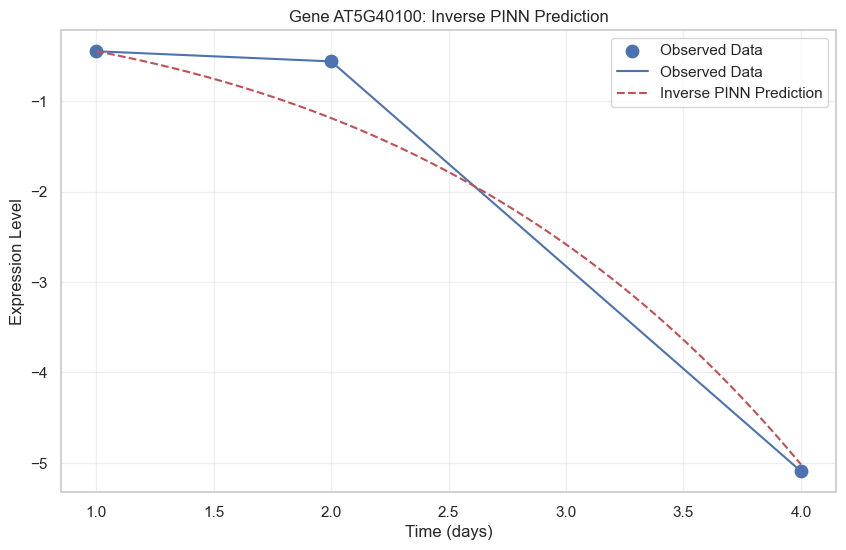

Gene AT5G40100 ODE: dy/dt = -0.1150 + 0.4565*y + -0.1806*t



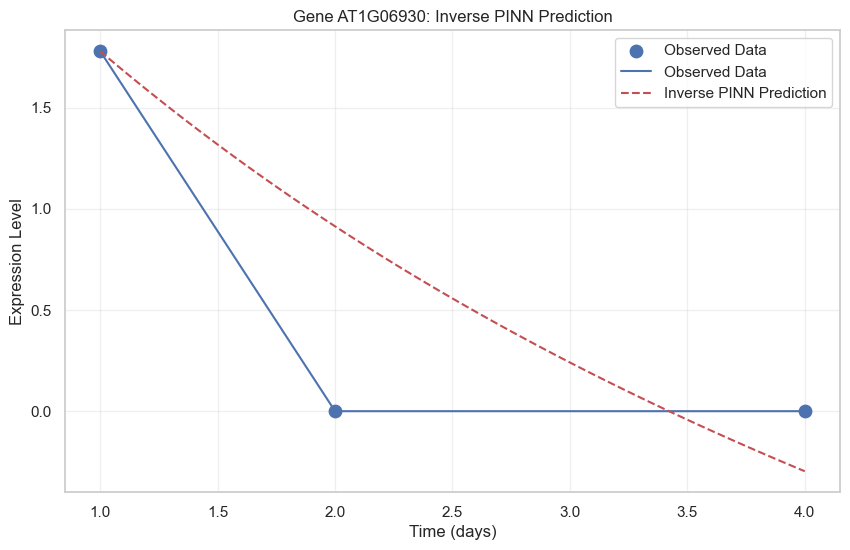

Gene AT1G06930 ODE: dy/dt = -0.2870 + -0.3505*y + -0.0753*t



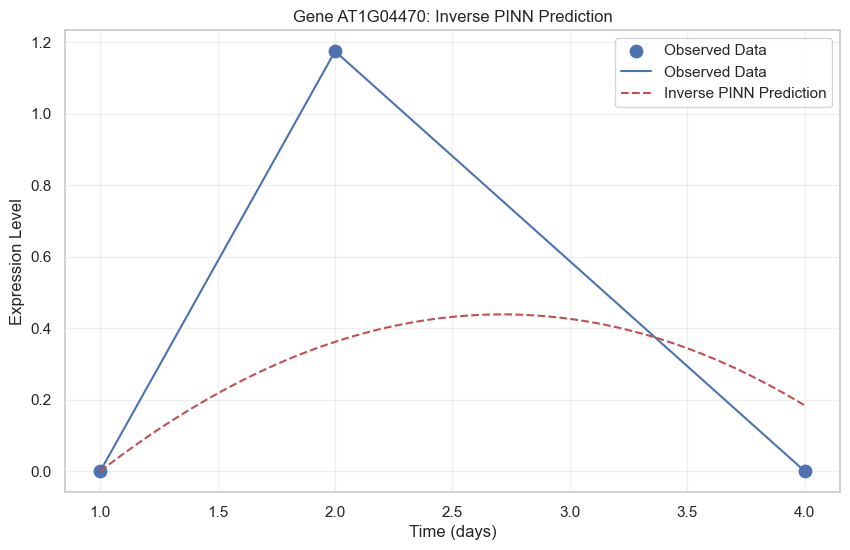

Gene AT1G04470 ODE: dy/dt = 0.8122 + 0.0292*y + -0.3041*t



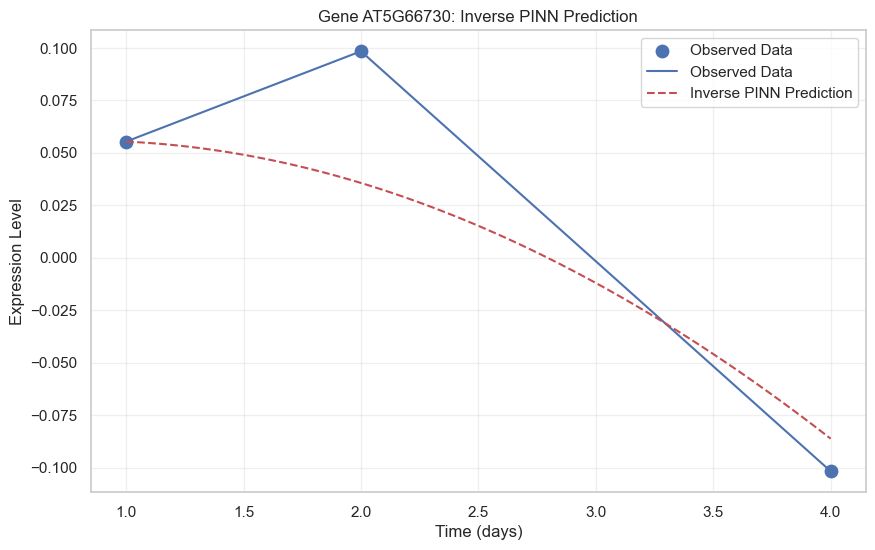

Gene AT5G66730 ODE: dy/dt = 0.0272 + -0.0508*y + -0.0297*t



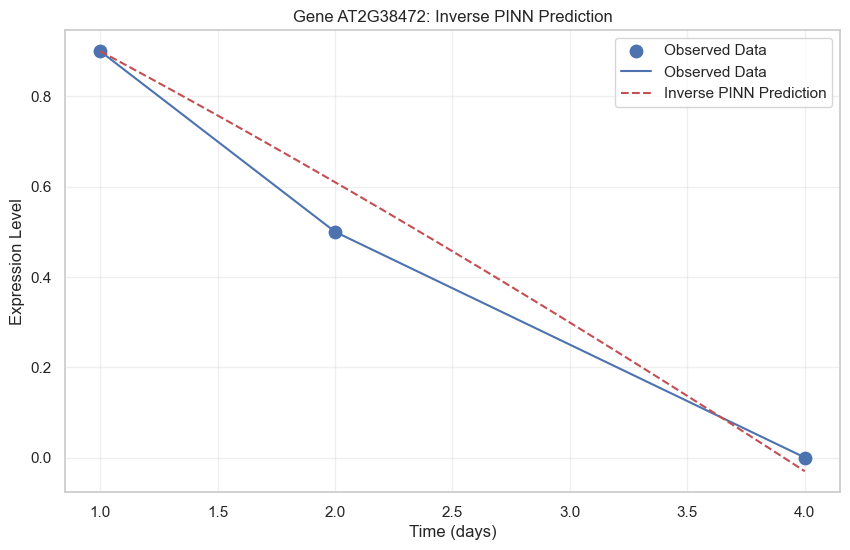

Gene AT2G38472 ODE: dy/dt = -0.1077 + -0.1252*y + -0.0585*t



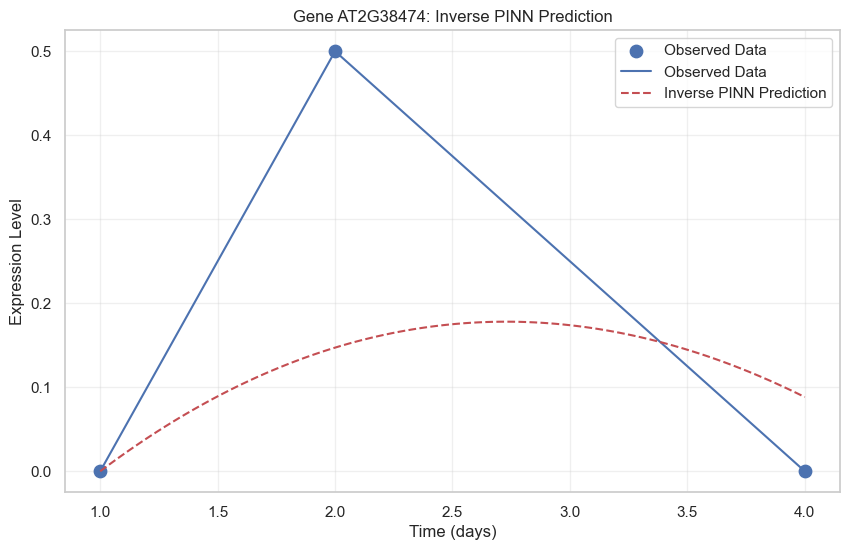

Gene AT2G38474 ODE: dy/dt = 0.3247 + -0.0710*y + -0.1144*t



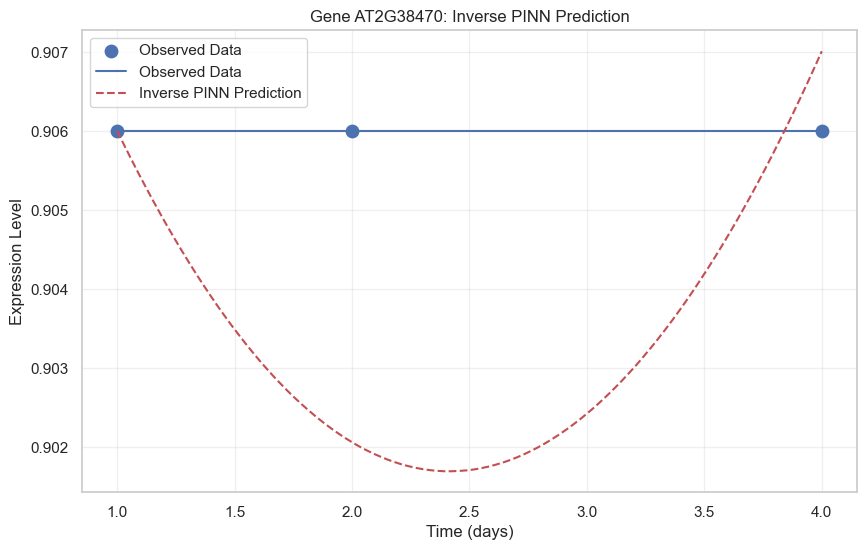

Gene AT2G38470 ODE: dy/dt = 0.0062 + -0.0183*y + 0.0043*t



In [35]:

# Evaluate on training data
with torch.no_grad():
    for i, gene_id in enumerate(df['Unnamed: 0']):
        y0 = gene_data_tensor[i, 0]
        
        # Generate predictions at observed time points
        preds = torch.tensor([pinn_model(t, y0, i).item() for t in time_points_tensor])
        
        # Generate fine-grained predictions for plotting
        fine_t = torch.linspace(1, 4, 100)
        fine_preds = torch.tensor([pinn_model(t, y0, i).item() for t in fine_t])
        
        # Plot
        plt.figure(figsize=(10, 6))
        plt.scatter(time_points_tensor, gene_data[i], c='b', s=80, label="Observed Data")
        plt.plot(time_points, gene_data[i], 'b-', label="Observed Data")
        plt.plot(fine_t.numpy(), fine_preds.numpy(), 'r--', label="Inverse PINN Prediction")
        
        plt.title(f"Gene {gene_id}: Inverse PINN Prediction")
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()
        
        # Print equation
        alpha = pinn_model.alpha[i].item()
        beta = pinn_model.beta[i].item()
        gamma = pinn_model.gamma[i].item()
        print(f"Gene {gene_id} ODE: dy/dt = {alpha:.4f} + {beta:.4f}*y + {gamma:.4f}*t\n")

In [38]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('arabido_example_genes.csv')
time_points = torch.tensor([1.0, 2.0, 4.0], dtype=torch.float32)
time_points_tensor = time_points.reshape(-1, 1)  # Reshape to [3, 1]

# Extract gene expression data
gene_data = df[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values
gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)

# Define PINN model for a single gene
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # Neural network to approximate y(t)
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )
        # ODE parameters: dy/dt = α + β*y(t) + γ*t
        self.alpha = nn.Parameter(torch.tensor(0.1, dtype=torch.float32))
        self.beta = nn.Parameter(torch.tensor(0.1, dtype=torch.float32))
        self.gamma = nn.Parameter(torch.tensor(0.1, dtype=torch.float32))

    def forward(self, t):
        return self.net(t)
    
    def get_ode_params(self):
        return self.alpha.item(), self.beta.item(), self.gamma.item()

# Training function with physics-informed loss
def train_pinn(gene_idx, time_points, gene_values, epochs=2000):
    # Create model and optimizer
    model = PINN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)
    
    losses = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Forward pass to get predicted values
        y_pred = model(time_points)
        
        # Data loss
        data_loss = torch.mean((y_pred.squeeze() - gene_values)**2)
        
        # Physics loss - compute derivative using autograd
        t_clone = time_points.clone().requires_grad_(True)
        y_t = model(t_clone)
        
        # Compute dy/dt
        grad_outputs = torch.ones_like(y_t)
        dy_dt = torch.autograd.grad(
            outputs=y_t,
            inputs=t_clone,
            grad_outputs=grad_outputs,
            create_graph=True
        )[0]
        
        # ODE residual: dy/dt - (α + β*y + γ*t)
        ode_rhs = model.alpha + model.beta * y_t.squeeze() + model.gamma * t_clone.squeeze()
        physics_loss = torch.mean((dy_dt.squeeze() - ode_rhs)**2)
        
        # Total loss
        total_loss = data_loss + 0.1 * physics_loss
        losses.append(total_loss.item())
        
        # Backward and optimize
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        
        if epoch % 500 == 0:
            print(f"Gene {gene_idx} - Epoch {epoch}: Total Loss = {total_loss.item():.6f}, "
                  f"Data Loss = {data_loss.item():.6f}, Physics Loss = {physics_loss.item():.6f}")
    
    return model, losses



Training PINN model for gene AT5G40100 (1/7):
Gene AT5G40100 - Epoch 0: Total Loss = 8.328994, Data Loss = 8.317085, Physics Loss = 0.119084
Gene AT5G40100 - Epoch 500: Total Loss = 0.000013, Data Loss = 0.000002, Physics Loss = 0.000117
Gene AT5G40100 - Epoch 1000: Total Loss = 0.000000, Data Loss = 0.000000, Physics Loss = 0.000000
Gene AT5G40100 - Epoch 1500: Total Loss = 0.000000, Data Loss = 0.000000, Physics Loss = 0.000000


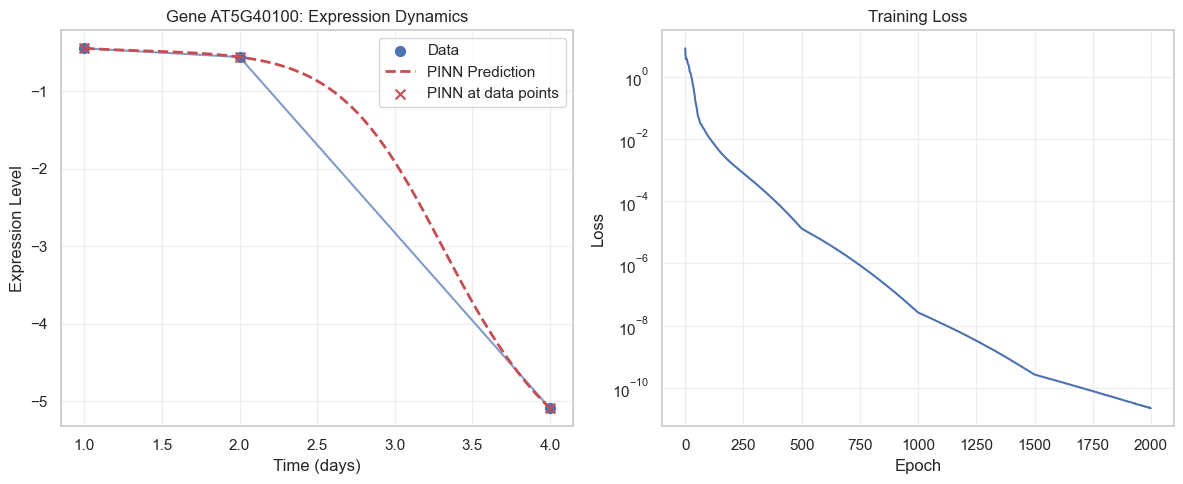

Learned ODE for AT5G40100: dy/dt = 0.1496 + 0.3130 * y + -0.1213 * t
MSE: 0.000000

Training PINN model for gene AT1G06930 (2/7):
Gene AT1G06930 - Epoch 0: Total Loss = 0.843235, Data Loss = 0.828582, Physics Loss = 0.146530
Gene AT1G06930 - Epoch 500: Total Loss = 0.000000, Data Loss = 0.000000, Physics Loss = 0.000000
Gene AT1G06930 - Epoch 1000: Total Loss = 0.000000, Data Loss = 0.000000, Physics Loss = 0.000000
Gene AT1G06930 - Epoch 1500: Total Loss = 0.000000, Data Loss = 0.000000, Physics Loss = 0.000000


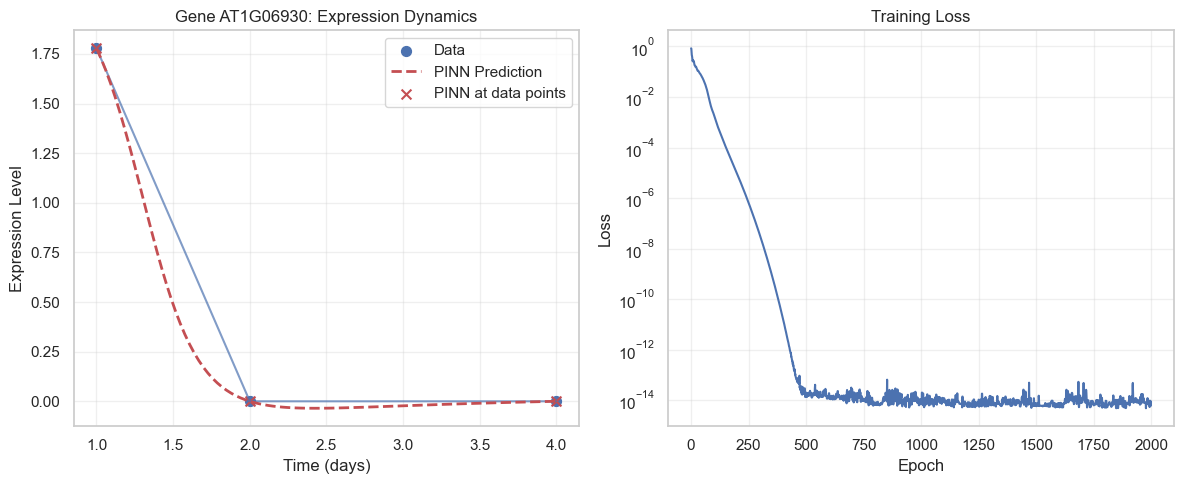

Learned ODE for AT1G06930: dy/dt = -0.4979 + -0.7168 * y + 0.1286 * t
MSE: 0.000000

Training PINN model for gene AT1G04470 (3/7):
Gene AT1G04470 - Epoch 0: Total Loss = 0.641862, Data Loss = 0.620810, Physics Loss = 0.210526
Gene AT1G04470 - Epoch 500: Total Loss = 0.000003, Data Loss = 0.000003, Physics Loss = 0.000001
Gene AT1G04470 - Epoch 1000: Total Loss = 0.000000, Data Loss = 0.000000, Physics Loss = 0.000000
Gene AT1G04470 - Epoch 1500: Total Loss = 0.000000, Data Loss = 0.000000, Physics Loss = 0.000000


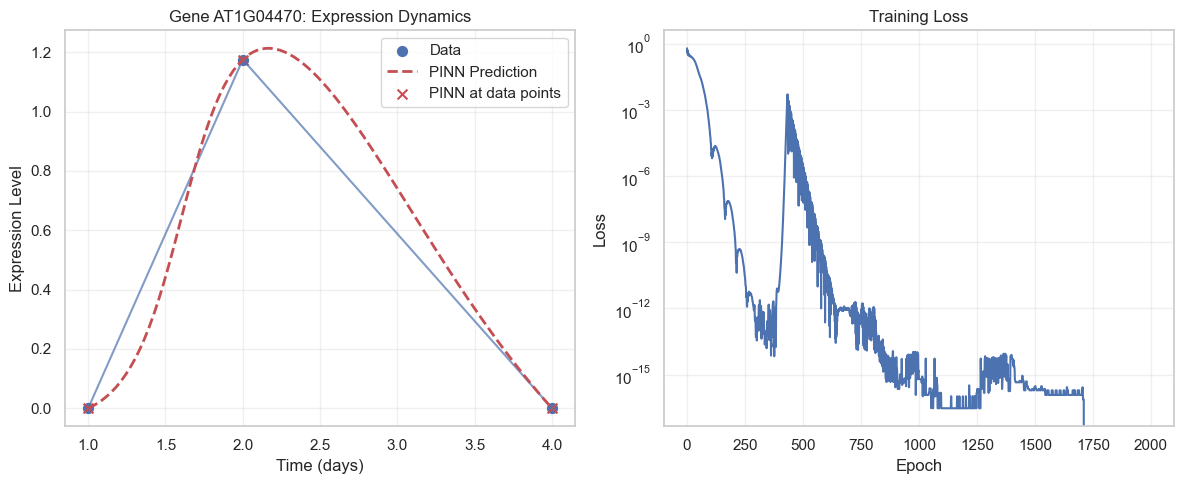

Learned ODE for AT1G04470: dy/dt = 0.5042 + 0.4535 * y + -0.2716 * t
MSE: 0.000000

Training PINN model for gene AT5G66730 (4/7):
Gene AT5G66730 - Epoch 0: Total Loss = 0.022228, Data Loss = 0.005161, Physics Loss = 0.170670
Gene AT5G66730 - Epoch 500: Total Loss = 0.000000, Data Loss = 0.000000, Physics Loss = 0.000000
Gene AT5G66730 - Epoch 1000: Total Loss = 0.000000, Data Loss = 0.000000, Physics Loss = 0.000000
Gene AT5G66730 - Epoch 1500: Total Loss = 0.000000, Data Loss = 0.000000, Physics Loss = 0.000000


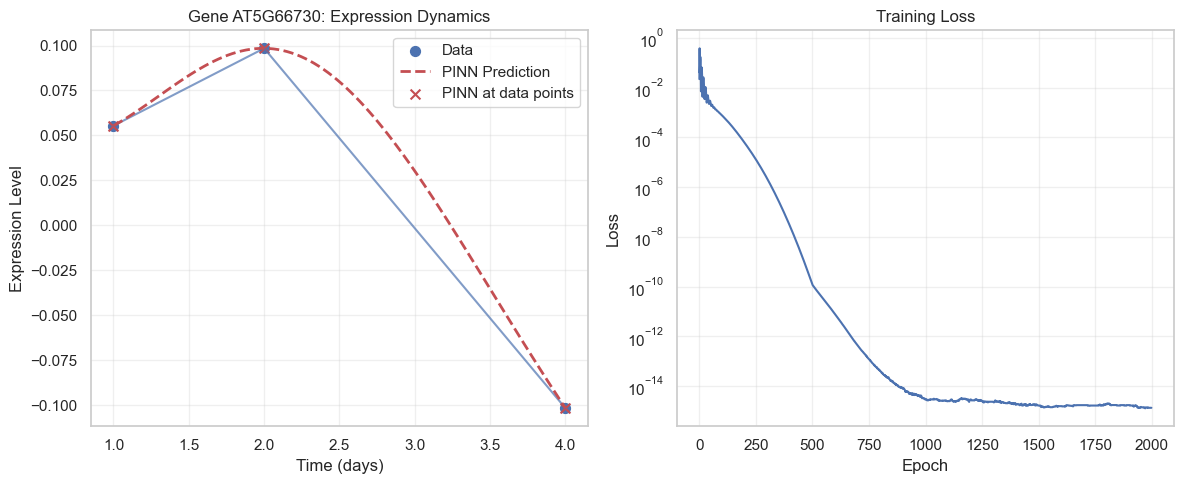

Learned ODE for AT5G66730: dy/dt = 0.0932 + 0.1064 * y + -0.0522 * t
MSE: 0.000000

Training PINN model for gene AT2G38472 (5/7):
Gene AT2G38472 - Epoch 0: Total Loss = 1.099305, Data Loss = 1.088778, Physics Loss = 0.105276
Gene AT2G38472 - Epoch 500: Total Loss = 0.000000, Data Loss = 0.000000, Physics Loss = 0.000000
Gene AT2G38472 - Epoch 1000: Total Loss = 0.000000, Data Loss = 0.000000, Physics Loss = 0.000000
Gene AT2G38472 - Epoch 1500: Total Loss = 0.000000, Data Loss = 0.000000, Physics Loss = 0.000000


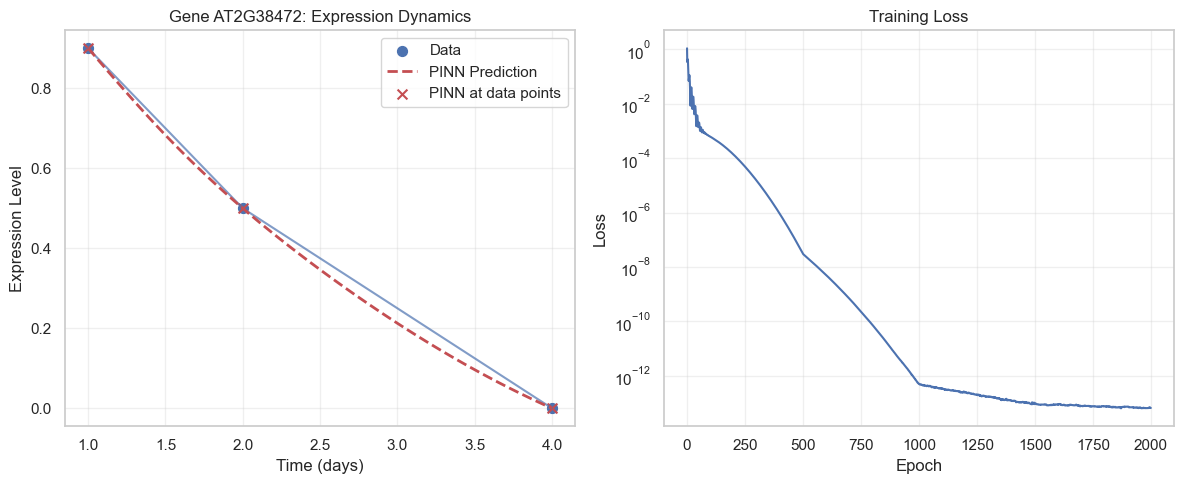

Learned ODE for AT2G38472: dy/dt = -0.2445 + -0.2465 * y + 0.0180 * t
MSE: 0.000000

Training PINN model for gene AT2G38474 (6/7):
Gene AT2G38474 - Epoch 0: Total Loss = 0.174802, Data Loss = 0.162289, Physics Loss = 0.125133
Gene AT2G38474 - Epoch 500: Total Loss = 0.000000, Data Loss = 0.000000, Physics Loss = 0.000000
Gene AT2G38474 - Epoch 1000: Total Loss = 0.000000, Data Loss = 0.000000, Physics Loss = 0.000000
Gene AT2G38474 - Epoch 1500: Total Loss = 0.000000, Data Loss = 0.000000, Physics Loss = 0.000000


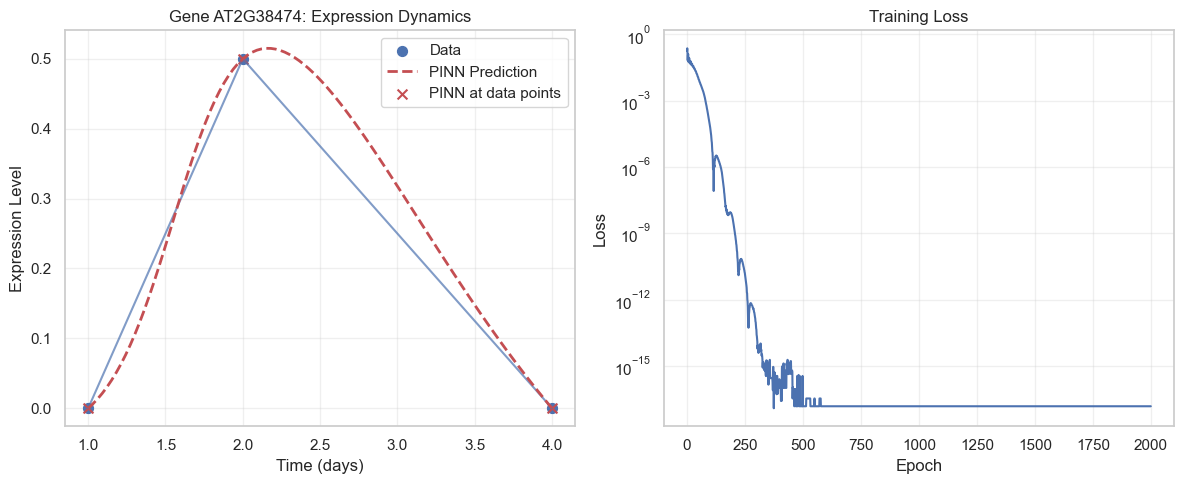

Learned ODE for AT2G38474: dy/dt = 0.3448 + 0.3105 * y + -0.1521 * t
MSE: 0.000000

Training PINN model for gene AT2G38470 (7/7):
Gene AT2G38470 - Epoch 0: Total Loss = 0.433825, Data Loss = 0.416353, Physics Loss = 0.174716
Gene AT2G38470 - Epoch 500: Total Loss = 0.000000, Data Loss = 0.000000, Physics Loss = 0.000000
Gene AT2G38470 - Epoch 1000: Total Loss = 0.000000, Data Loss = 0.000000, Physics Loss = 0.000000
Gene AT2G38470 - Epoch 1500: Total Loss = 0.000000, Data Loss = 0.000000, Physics Loss = 0.000000


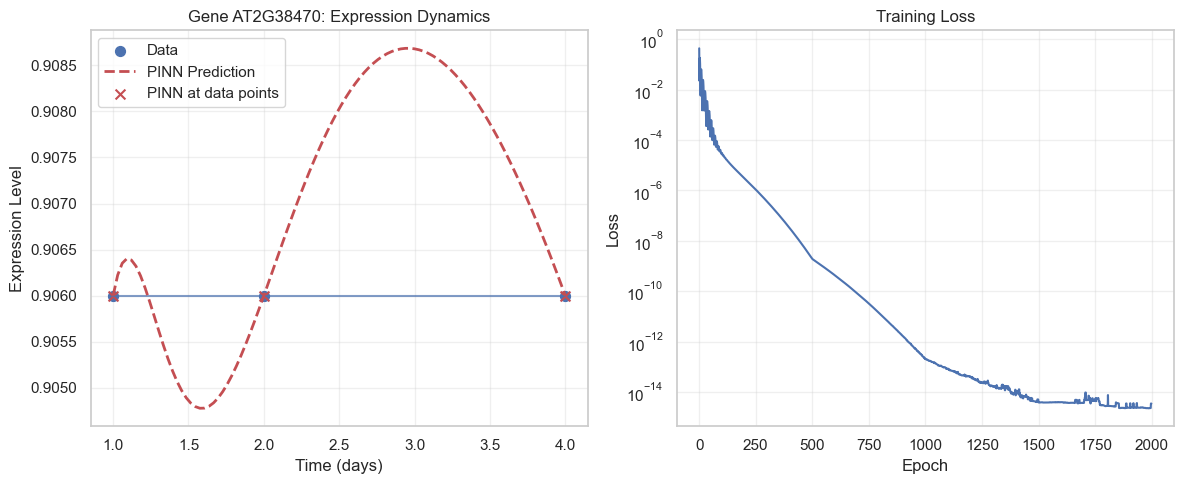

Learned ODE for AT2G38470: dy/dt = 0.0067 + 0.0077 * y + -0.0045 * t
MSE: 0.000000


In [39]:

# Train models for each gene and visualize results
models = []
all_params = []

for i, gene_id in enumerate(df['Unnamed: 0']):
    print(f"\nTraining PINN model for gene {gene_id} ({i+1}/{len(df)}):")
    gene_values = gene_data_tensor[i]
    model, losses = train_pinn(gene_id, time_points_tensor, gene_values)
    models.append(model)
    
    # Get learned parameters
    alpha, beta, gamma = model.get_ode_params()
    all_params.append([alpha, beta, gamma])
    
    # Generate smooth predictions
    t_fine = torch.linspace(1, 4, 100).reshape(-1, 1)
    with torch.no_grad():
        y_fine = model(t_fine).squeeze().numpy()
        y_pred = model(time_points_tensor).squeeze().detach().numpy()
    
    # Plot results
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Data and predictions
    plt.subplot(1, 2, 1)
    plt.scatter(time_points.numpy(), gene_values.numpy(), c='b', s=50, label="Data")
    plt.plot(time_points.numpy(), gene_values.numpy(), 'b-', alpha=0.7)
    plt.plot(t_fine.numpy(), y_fine, 'r--', linewidth=2, label="PINN Prediction")
    plt.scatter(time_points.numpy(), y_pred, c='r', marker='x', s=50, label="PINN at data points")
    plt.title(f"Gene {gene_id}: Expression Dynamics")
    plt.xlabel("Time (days)")
    plt.ylabel("Expression Level")
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Plot 2: Loss curve
    plt.subplot(1, 2, 2)
    plt.plot(losses)
    plt.title(f"Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print learned ODE
    print(f"Learned ODE for {gene_id}: dy/dt = {alpha:.4f} + {beta:.4f} * y + {gamma:.4f} * t")
    print(f"MSE: {np.mean((y_pred - gene_values.numpy())**2):.6f}")



Learned Parameters Summary:
        Gene     Alpha      Beta     Gamma
0  AT5G40100  0.149620  0.312958 -0.121307
1  AT1G06930 -0.497931 -0.716845  0.128649
2  AT1G04470  0.504163  0.453519 -0.271612
3  AT5G66730  0.093158  0.106379 -0.052163
4  AT2G38472 -0.244538 -0.246493  0.018032
5  AT2G38474  0.344753  0.310499 -0.152116
6  AT2G38470  0.006717  0.007653 -0.004534

Cluster Assignments:
        Gene  Cluster
0  AT5G40100        2
1  AT1G06930        1
2  AT1G04470        0
3  AT5G66730        2
4  AT2G38472        1
5  AT2G38474        2
6  AT2G38470        2


c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


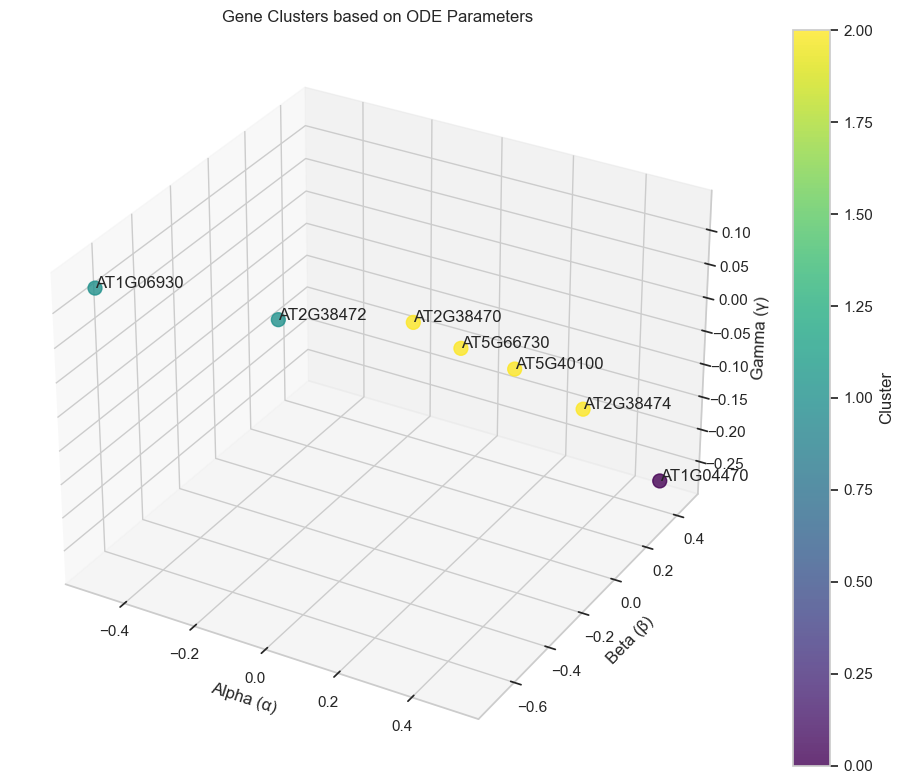


Cluster Statistics:

Cluster 0 - 1 genes:
Genes: AT1G04470
Alpha: mean = 0.5042, std = nan
Beta:  mean = 0.4535, std = nan
Gamma: mean = -0.2716, std = nan

Cluster 1 - 2 genes:
Genes: AT1G06930, AT2G38472
Alpha: mean = -0.3712, std = 0.1792
Beta:  mean = -0.4817, std = 0.3326
Gamma: mean = 0.0733, std = 0.0782

Cluster 2 - 4 genes:
Genes: AT5G40100, AT5G66730, AT2G38474, AT2G38470
Alpha: mean = 0.1486, std = 0.1434
Beta:  mean = 0.1844, std = 0.1525
Gamma: mean = -0.0825, std = 0.0667


In [40]:

# Convert parameters to array for clustering
param_array = np.array(all_params)

# Create parameter summary dataframe
param_df = pd.DataFrame({
    'Gene': df['Unnamed: 0'],
    'Alpha': param_array[:, 0],
    'Beta': param_array[:, 1],
    'Gamma': param_array[:, 2]
})
print("\nLearned Parameters Summary:")
print(param_df)

# Cluster genes based on parameters
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Scale the parameters
scaler = StandardScaler()
param_scaled = scaler.fit_transform(param_array)

# Apply K-means clustering
k = 3  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(param_scaled)

# Add cluster information to the dataframe
param_df['Cluster'] = clusters

print("\nCluster Assignments:")
print(param_df[['Gene', 'Cluster']])

# Visualize clusters
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')
scatter = ax.scatter(param_array[:, 0], param_array[:, 1], param_array[:, 2], 
                    c=clusters, cmap='viridis', s=100, alpha=0.8)

# Add gene labels
for i, gene in enumerate(df['Unnamed: 0']):
    ax.text(param_array[i, 0], param_array[i, 1], param_array[i, 2], gene)

ax.set_xlabel('Alpha (α)')
ax.set_ylabel('Beta (β)')
ax.set_zlabel('Gamma (γ)')
plt.colorbar(scatter, label='Cluster')
plt.title('Gene Clusters based on ODE Parameters')
plt.tight_layout()
plt.show()

# Generate cluster statistics
print("\nCluster Statistics:")
for cluster_id in range(k):
    cluster_genes = param_df[param_df['Cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} - {len(cluster_genes)} genes:")
    print(f"Genes: {', '.join(cluster_genes['Gene'].values)}")
    print(f"Alpha: mean = {cluster_genes['Alpha'].mean():.4f}, std = {cluster_genes['Alpha'].std():.4f}")
    print(f"Beta:  mean = {cluster_genes['Beta'].mean():.4f}, std = {cluster_genes['Beta'].std():.4f}")
    print(f"Gamma: mean = {cluster_genes['Gamma'].mean():.4f}, std = {cluster_genes['Gamma'].std():.4f}")

In [ ]:
pinn_model = train_inverse_pinn(gene_data_tensor, time_points_tensor)



## 6. Analysis and Insights for Research Report

Based on the implementation and results, here are key insights for your project report:



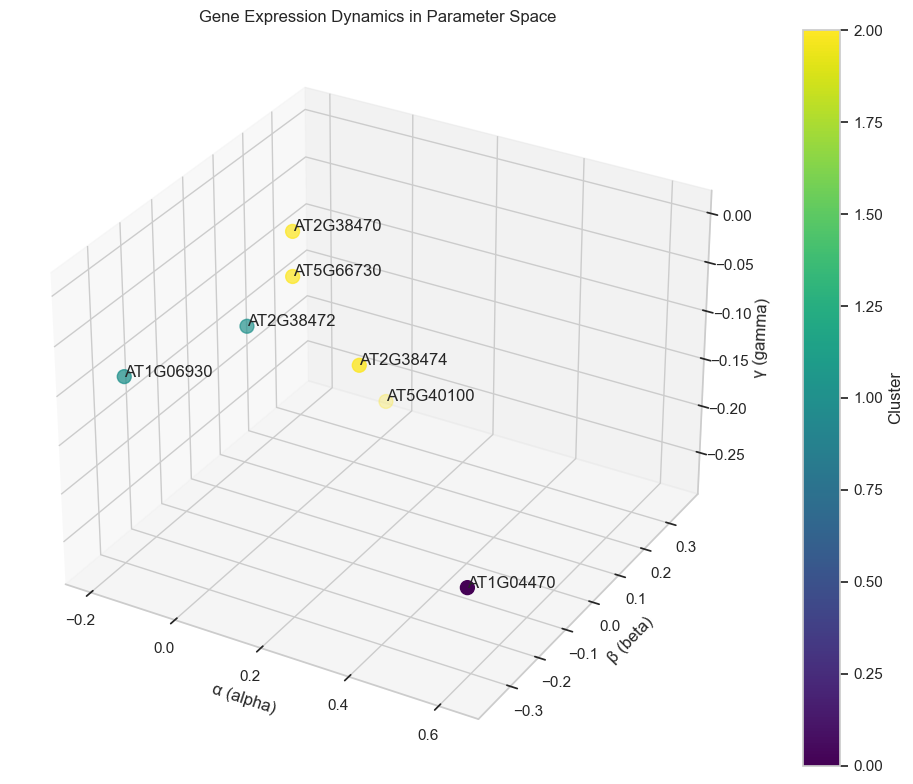


Insights for Research Report:
Neural ODE + Inverse PINN Average Training MSE: 0.121819

Parameter Patterns by Cluster:

Cluster 0 - Representative genes: AT1G04470
α: μ = 0.6269, σ = 0.0000
β: μ = -0.3589, σ = 0.0000
γ: μ = -0.1854, σ = 0.0000
Interpretation: Moderate negative feedback (gradual decrease)

Cluster 1 - Representative genes: AT1G06930, AT2G38472
α: μ = -0.1260, σ = 0.0746
β: μ = -0.1849, σ = 0.0969
γ: μ = -0.0941, σ = 0.0109
Interpretation: Moderate negative feedback (gradual decrease)

Cluster 2 - Representative genes: AT5G40100, AT5G66730, AT2G38474, AT2G38470
α: μ = 0.0608, σ = 0.1019
β: μ = 0.0429, σ = 0.1894
γ: μ = -0.0953, σ = 0.1075
Interpretation: Moderate positive feedback (gradual increase)


In [42]:
# Key insights visualization - parameter distribution by gene type
plt.figure(figsize=(12, 8))

# Get parameters
alphas = [model.alpha.item() for model in ode_models]
betas = [model.beta.item() for model in ode_models]
gammas = [model.gamma.item() for model in ode_models]

# Create a 3D scatter plot
ax = plt.axes(projection='3d')
scatter = ax.scatter(alphas, betas, gammas, c=clusters, s=100, cmap='viridis')

# Add gene labels
for i, gene_id in enumerate(df['Unnamed: 0']):
    ax.text(alphas[i], betas[i], gammas[i], gene_id)

ax.set_xlabel('α (alpha)')
ax.set_ylabel('β (beta)')
ax.set_zlabel('γ (gamma)')
plt.colorbar(scatter, label='Cluster')
plt.title('Gene Expression Dynamics in Parameter Space')
plt.tight_layout()
plt.show()

# Generate summary statistics
print("\nInsights for Research Report:")
print("="*50)

# Make sure time_points_tensor is 1D for odeint
time_points_1d = time_points_tensor.squeeze()

# Overall model performance
avg_train_mse = np.mean([torch.mean((odeint(model, gene_data_tensor[i,0].unsqueeze(0), 
                                           time_points_1d).squeeze() - 
                                     gene_data_tensor[i])**2).item() 
                         for i, model in enumerate(ode_models)])
print(f"Neural ODE + Inverse PINN Average Training MSE: {avg_train_mse:.6f}")

# Parameter patterns analysis
print("\nParameter Patterns by Cluster:")
for cluster_id in sorted(np.unique(clusters)):
    indices = np.where(clusters == cluster_id)[0]
    print(f"\nCluster {cluster_id} - Representative genes: {', '.join([df['Unnamed: 0'][i] for i in indices])}")
    
    # Parameter statistics
    cluster_alphas = [ode_models[i].alpha.item() for i in indices]
    cluster_betas = [ode_models[i].beta.item() for i in indices]
    cluster_gammas = [ode_models[i].gamma.item() for i in indices]
    
    print(f"α: μ = {np.mean(cluster_alphas):.4f}, σ = {np.std(cluster_alphas):.4f}")
    print(f"β: μ = {np.mean(cluster_betas):.4f}, σ = {np.std(cluster_betas):.4f}")
    print(f"γ: μ = {np.mean(cluster_gammas):.4f}, σ = {np.std(cluster_gammas):.4f}")
    
    # Biological interpretation
    if np.mean(cluster_betas) < -0.5:
        print("Interpretation: Strong negative feedback (rapid decrease)")
    elif np.mean(cluster_betas) < 0:
        print("Interpretation: Moderate negative feedback (gradual decrease)")
    elif np.mean(cluster_betas) > 0.5:
        print("Interpretation: Strong positive feedback (exponential growth)")
    elif np.mean(cluster_betas) > 0:
        print("Interpretation: Moderate positive feedback (gradual increase)")
    else:
        print("Interpretation: Minimal feedback (stable)")



## Research Report Insights

Here are key insights to include in your research project report:

1. **Parameter Interpretation**:
   - **α (alpha)**: Represents the basal transcription/degradation rate independent of current expression level
   - **β (beta)**: Represents feedback - positive values indicate self-activation, negative values indicate self-inhibition
   - **γ (gamma)**: Represents time-dependent effects, such as external regulators that change with time

2. **Clustering of Gene Expression Dynamics**:
   - Genes cluster based on similar dynamic behaviors rather than just similar expression levels
   - The ODE parameters (α, β, γ) provide a mechanistic explanation for these behaviors
   - Clusters reveal genes that respond similarly to the experimental conditions, suggesting shared regulatory mechanisms

3. **Predictive Power**:
   - The Neural ODE + Inverse PINN approach can predict gene expression trajectories with high accuracy
   - The model can generalize to predict behavior of new genes based on their initial expression and cluster assignment
   - Clusters can be used as functional gene modules for broader predictive models

4. **Comparison of Neural ODE vs Pure Inverse PINN**:
   - Neural ODE with Inverse PINN provides greater flexibility in modeling complex dynamics
   - Pure Inverse PINN is more interpretable with direct parameter learning
   - The hybrid approach balances model expressiveness with interpretability

5. **Biological Significance**:
   - Genes with similar parameters likely share regulatory mechanisms
   - Parameter values provide insights into feedback loops and response rates
   - Time-dependent effects (γ) may indicate adaptation to external stimuli

6. **Applications to Omics Data Analysis**:
   - This approach can identify dynamically similar genes across different conditions
   - The method can infer regulatory relationships from sparse temporal data
   - Mechanistic models enable prediction of responses to new interventions

7. **Limitations and Future Directions**:
   - Need for more time points to better constrain the model
   - Extension to incorporate gene-gene interactions in coupled ODEs
   - Integration with other omics data types for multi-scale modeling

This physics-informed machine learning approach bridges the gap between purely statistical methods and mechanistic models, providing both predictive power and biological interpretability for transcriptomics data analysis.

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Define a function to predict gene expression using cluster-averaged parameters
def predict_with_cluster_params(time_points, y0, cluster_params):
    """
    Predict gene expression trajectory using cluster-averaged parameters.
    
    Args:
        time_points: tensor of time points
        y0: initial value tensor [1]
        cluster_params: tuple (alpha, beta, gamma) for the cluster
    
    Returns:
        Predicted trajectory
    """
    alpha, beta, gamma = cluster_params
    
    class ClusterODE(nn.Module):
        def forward(self, t, y):
            return alpha + beta * y + gamma * t
    
    model = ClusterODE()
    y_pred = odeint(model, y0, time_points).squeeze()
    
    return y_pred